In [11]:
from typing import Union

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data, flatten
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.ds.challenge_dataset import load_challenge_data
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.model.sliding_attention_classifier import SlidingAttentionClassifier, SlidingAttentionClassifierHyperParameters
from lib.torch_generic_model_training import train_model_with_cv
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch, calculate_average_metrics
from lib.ds.bird_combiner import combine_birds
from lib.challenge import predict_for_challenge, save_results_to_csv, load_results_from_csv
from lib.label_fixing import fix_labels_information_gain
from lib.binary_classification import to_binary
import lib.torch_device as tdev

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [3]:
data_raw, labels = load_all_data('dataset')
print(f'{data_raw.shape = }')
print(f'{labels.shape   = }')

data_raw.shape = (1200, 100, 548)
labels.shape   = (1200, 100)


In [30]:
dataset_raw_train, dataset_raw_test = split(NumpyDataset(data_raw, labels), test_size_pct=0.1, seed=6942066)

### Create sequences

In [31]:
sequences_ds_train = combine_birds(
    dataset_raw_train, 
    sequence_length=300,
    random_seed=42
)
print(f'{sequences_ds_train.data.shape   = }')
print(f'{sequences_ds_train.labels.shape = }\n\n')


sequences_ds_test = combine_birds(
    dataset_raw_test, 
    sequence_length=300,
    random_seed=42
)

if sequences_ds_test is not None:
    print(f'{sequences_ds_test.data.shape   = }')
    print(f'{sequences_ds_test.labels.shape = }')
else:
    print('sequences_ds_test = None')

Creating random sequence (num_duplicates = 1): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108000/108000 [02:15<00:00, 798.17it/s]


sequences_ds_train.data.shape   = (360, 300, 548)
sequences_ds_train.labels.shape = (360, 300)




Creating random sequence (num_duplicates = 1): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:01<00:00, 9264.22it/s]

sequences_ds_test.data.shape   = (40, 300, 548)
sequences_ds_test.labels.shape = (40, 300)


### Binaryfication - BirdNoBird

In [32]:
train_binary_labels = to_binary(
    labels=sequences_ds_train.labels, 
    pos_labels=np.array(range(1, 7)),
    neg_labels=np.array([0]),
)
print(train_binary_labels)

sequences_ds_train_binary_labels = sequences_ds_train.copy()
sequences_ds_train_binary_labels.labels = train_binary_labels

[[1 1 0 ... 1 0 1]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 1]]


In [33]:
test_binary_labels = to_binary(
    labels=sequences_ds_test.labels, 
    pos_labels=np.array(range(1, 7)),
    neg_labels=np.array([0]),
)
print(test_binary_labels)

sequences_ds_test_binary_labels = sequences_ds_test.copy()
sequences_ds_test_binary_labels.labels = test_binary_labels

[[0 1 0 ... 0 0 0]
 [0 1 0 ... 1 1 1]
 [1 0 1 ... 1 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [1 1 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]]


# Hyper Parameters

In [34]:
ac_hyper_parameters = SlidingAttentionClassifierHyperParameters(
    in_features=data_raw.shape[-1],
    out_features=2,
    
    attention_window_size=30,
    step=6,
    
    d_model=128,
    num_heads=16,
    attention_stack_size=2,
    attention_stack_activation_provider=lambda: nn.LeakyReLU(),
    attention_dropout=0.4,
    
    in_linear_hidden_out_features=[128, 64],
    out_linear_hidden_out_features=[64, 16],
    linear_activation_provider=lambda: nn.LeakyReLU(),
    linear_dropout=0.4,
)

In [35]:
training_hyper_parameters = TrainingHyperParameters(
        batch_size=32,
        
        loss_weight_modifiers=torch.Tensor([
            1.0 / 2, # no bird
            1.0, # bird
        ]).to(device),
        
        optimizer_provider=lambda model, lr: optim.Adamax(
            model.parameters(),
            lr=lr,
            betas=(0.9, 0.98),
            eps=1e-9
        ),

        num_epochs=25,
        lr=1e-2,
    
        lr_scheduler_milestones=[int(m) for m in [30, 100, 250]],
        lr_scheduler_gamma=0.75,
        lr_scheduler_provider=lambda optimizer, milestones, gamma: None,
        # lr_scheduler_provider=lambda optimizer, milestones, gamma: lr_scheduler.MultiStepLR(
        #     optimizer, 
        #     milestones=milestones,
        #     gamma=gamma
        # )
    )

# Training

## Cross Validation

Creating 8 folds


CV Folds:   0%|                                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]




Executing CV for fold 0
Training fold 0


#### Training ####
##################
AttentionClassifier with 228274 parameters, in_fnn: 86848, attention_stack: 132096, out_fnn: 9330
##################

train label counts = [67263, 27237]
eval label counts  = [ 9640,  3860]

loss weights                    = [ 0.50,  2.47]
eval loss weights (theoretical) = [ 0.50,  2.50]


Training Epoch   1/25 : lr = 1.00E-02, epoch =     1, avg_loss = 0.000103, num_samples = 94500, num_correct = 29463, acc = 0.311778, bacc = 0.501112, score = -0.376444
Evaluation Epoch   1/25 : epoch =     1, avg_loss = 0.000119, num_samples = 13500, num_correct =  3860, acc = 0.285926, bacc = 0.500000, score = -0.428148
Training Epoch   2/25 : lr = 1.00E-02, epoch =     2, avg_loss = 0.000068, num_samples = 94500, num_correct = 27237, acc = 0.288222, bacc = 0.500000, score = -0.423556
Evaluation Epoch   2/25 : epoch =     2, avg_loss = 0.000129, num_samples = 13500, num_correct =  3860, acc = 0.285926, bacc = 0.500000

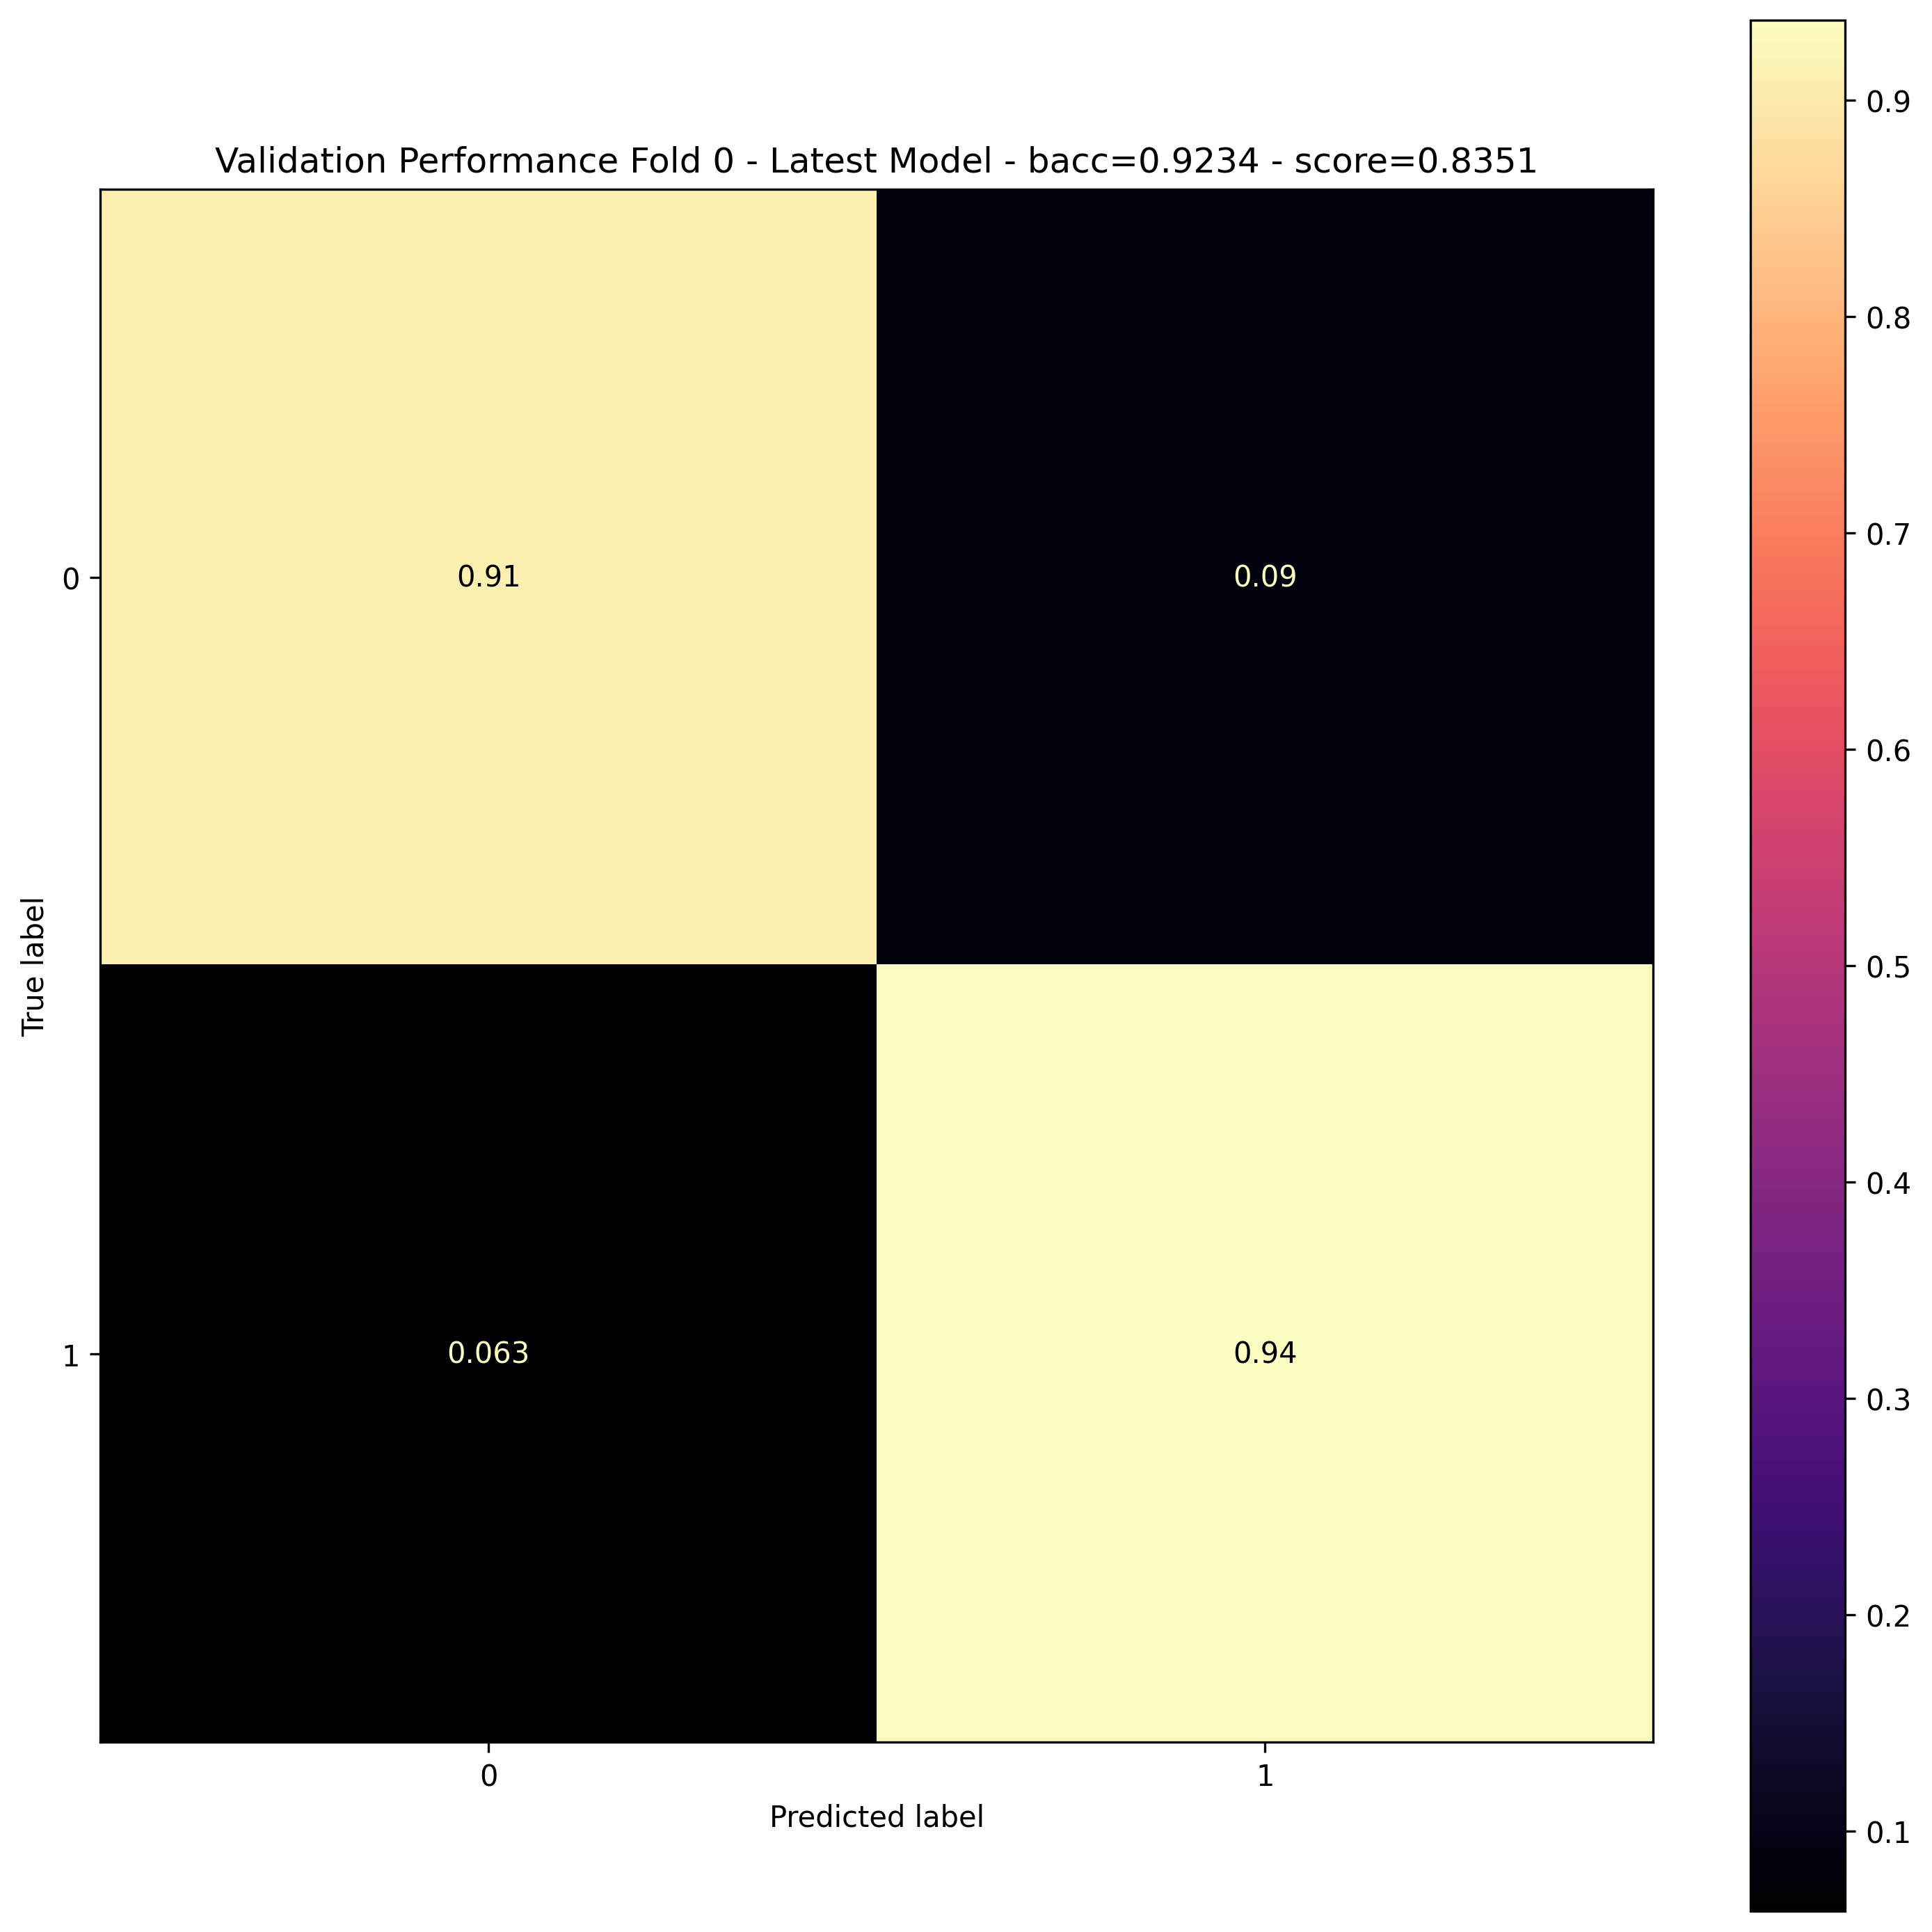

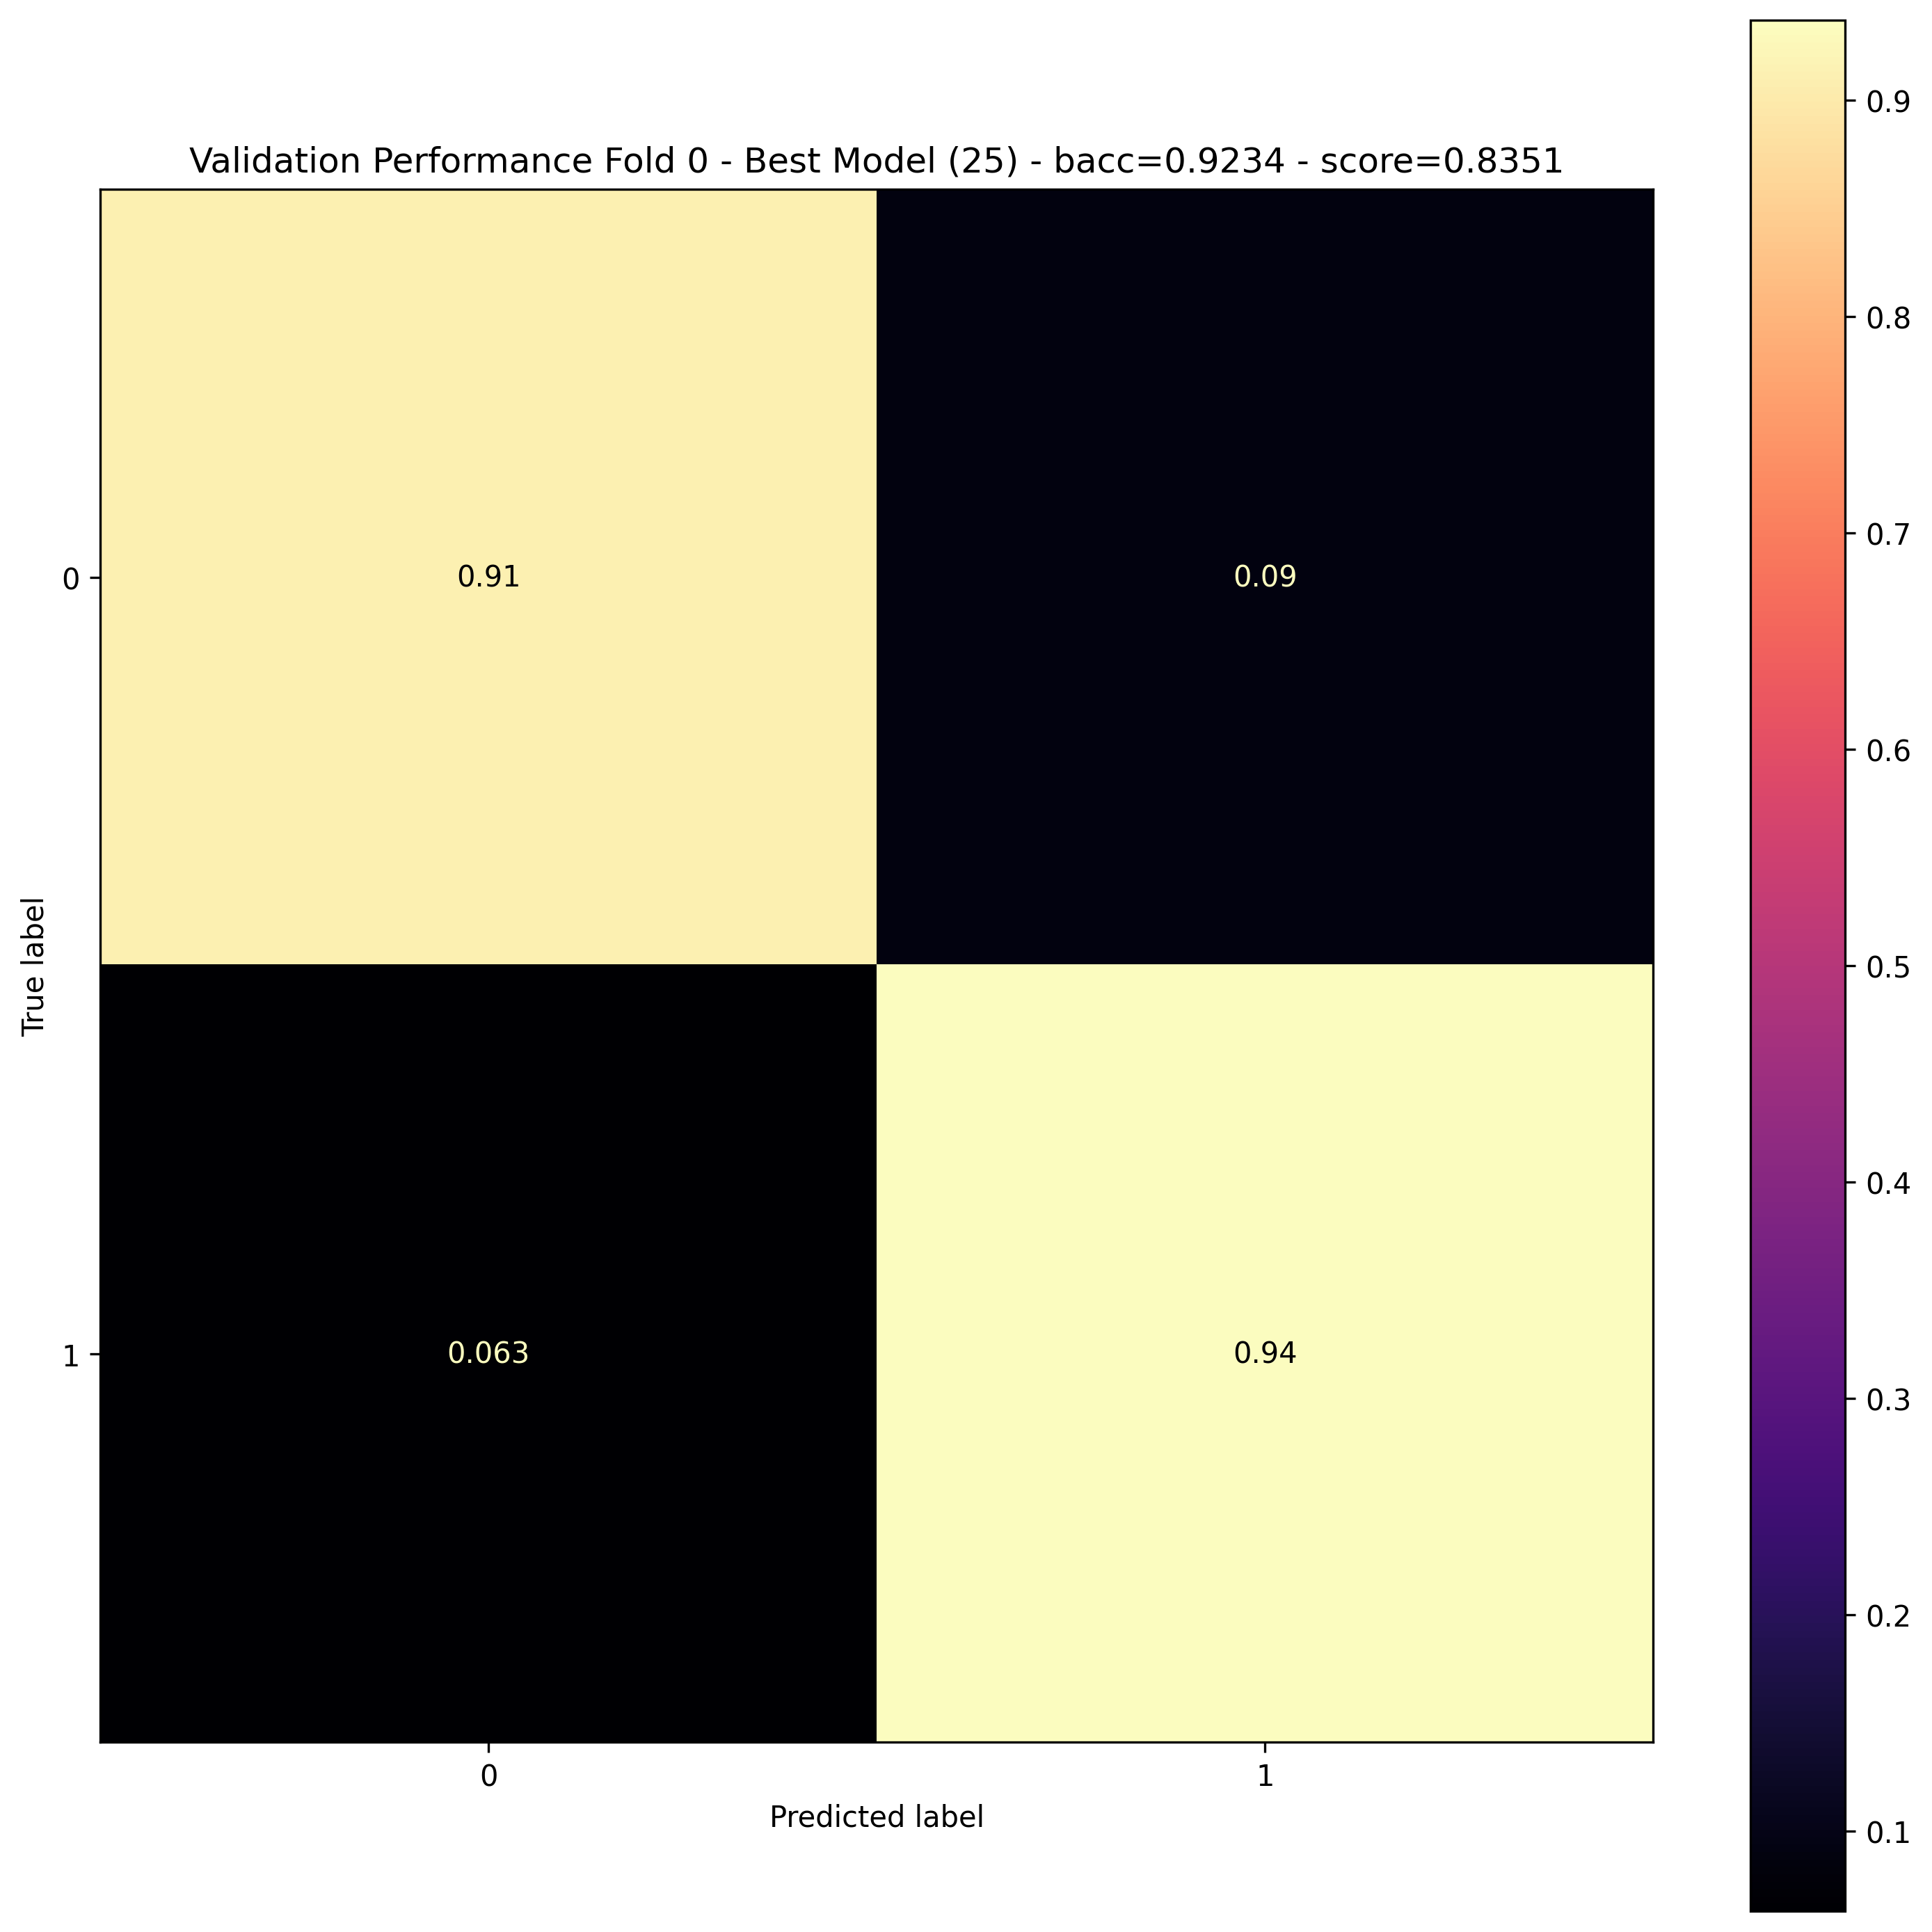


Testing fold 0


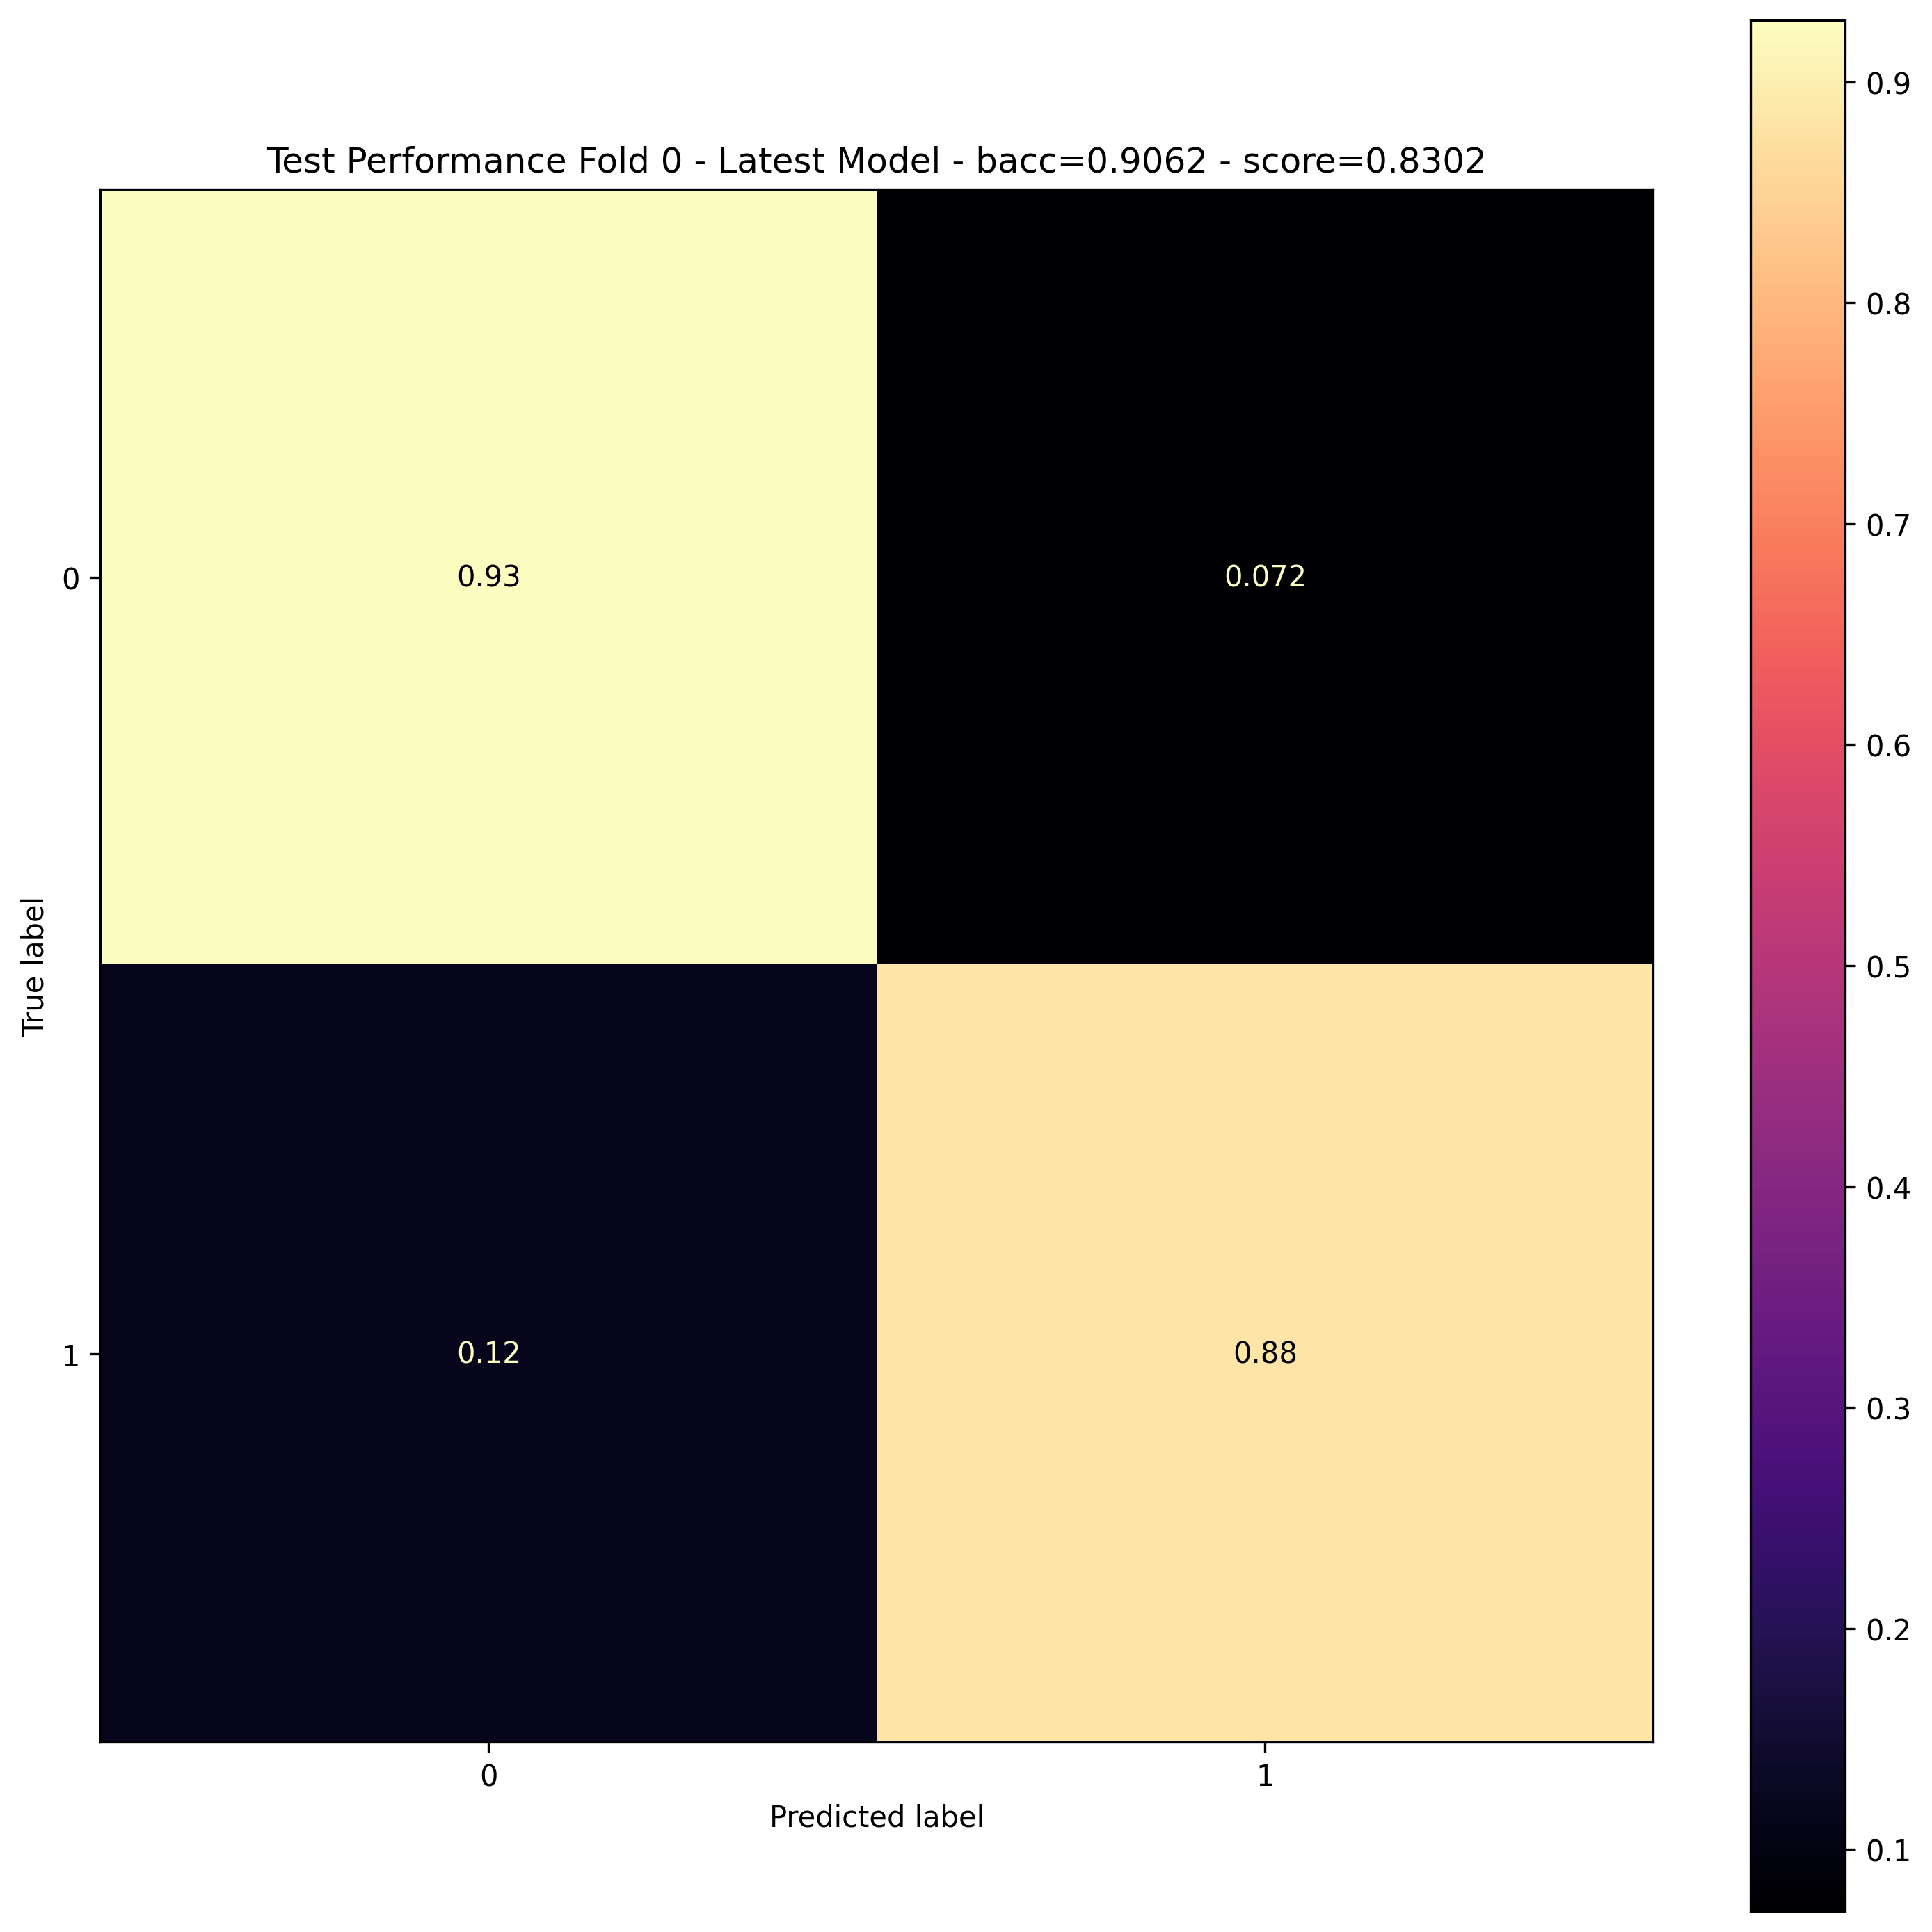

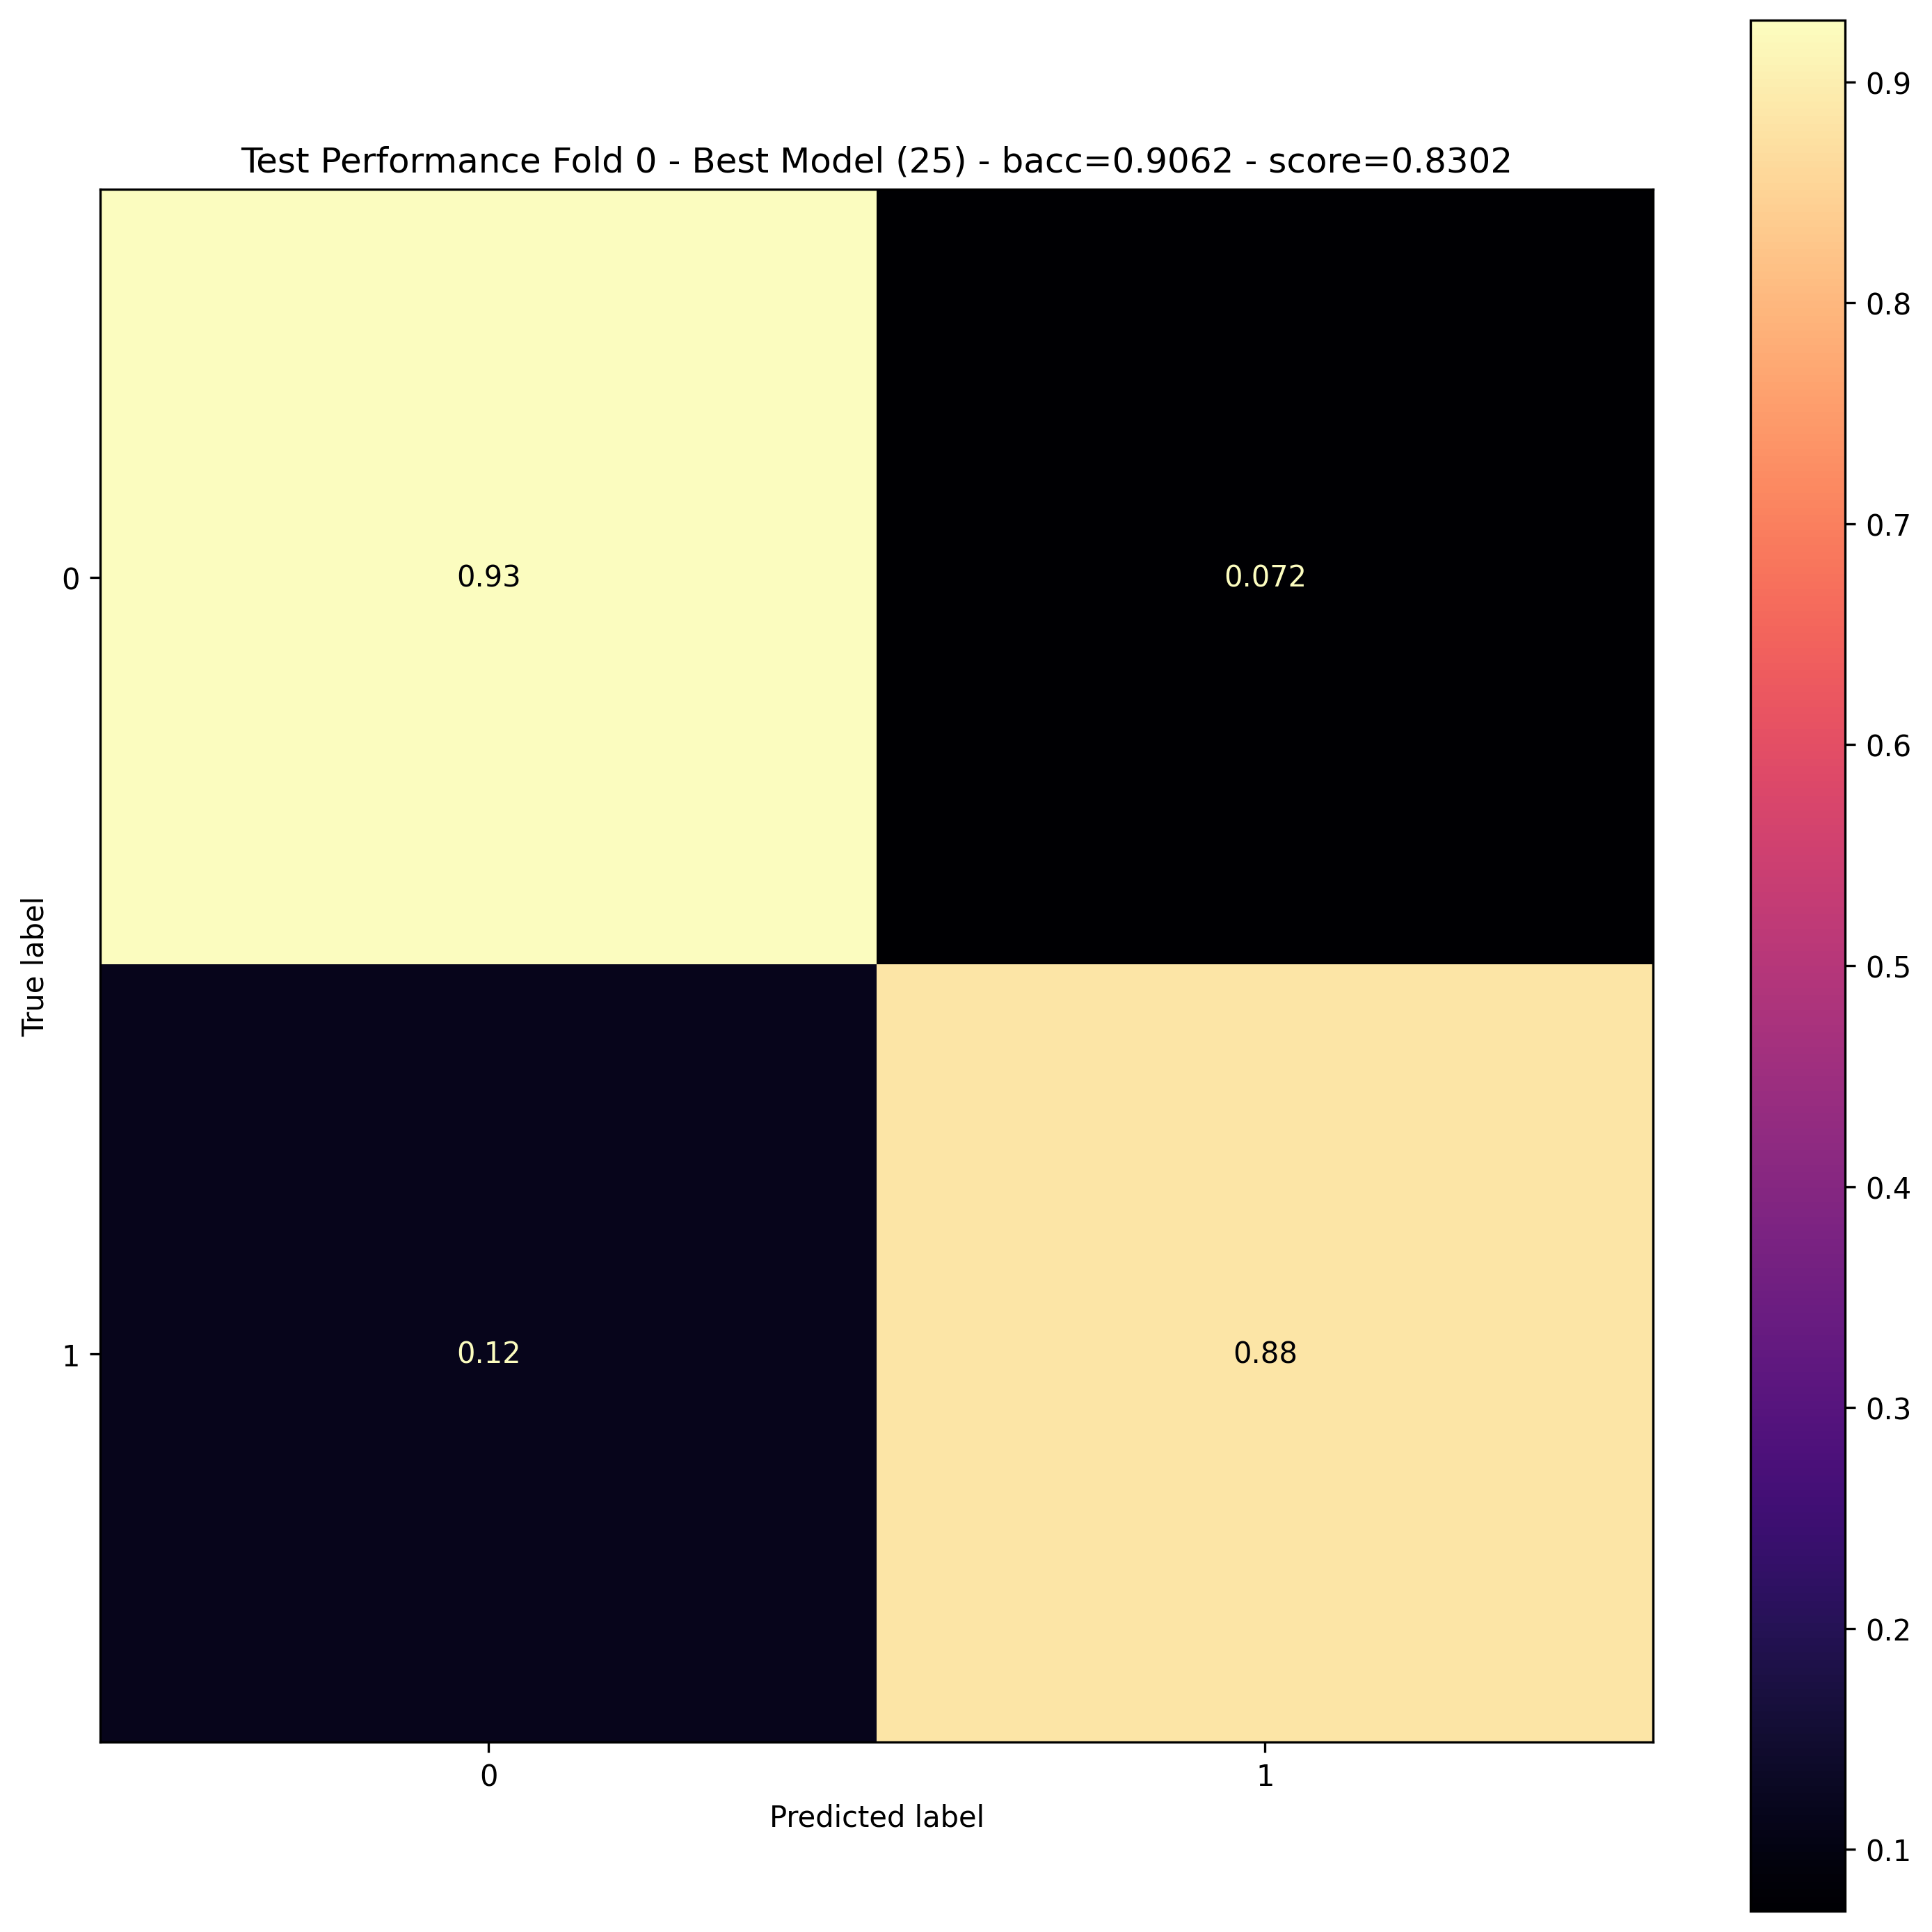

CV Folds:  12%|█████████████████████████▋                                                                                                                                                                                   | 1/8 [00:11<01:19, 11.36s/it]

Best Model Test Metrics: epoch =    -1, avg_loss = 0.000038, num_samples = 12000, num_correct = 10981, acc = 0.915083, bacc = 0.906158, score = 0.830167
Saved model with scaler as "bird_no_bird_classifier cv2023-06-15_14.38 fold-0-best eval-score=0.8351 test-score=0.8302"



Executing CV for fold 1
Training fold 1


#### Training ####
##################
AttentionClassifier with 228274 parameters, in_fnn: 86848, attention_stack: 132096, out_fnn: 9330
##################

train label counts = [67165, 27335]
eval label counts  = [ 9738,  3762]

loss weights                    = [ 0.50,  2.46]
eval loss weights (theoretical) = [ 0.50,  2.59]


Training Epoch   1/25 : lr = 1.00E-02, epoch =     1, avg_loss = 0.000069, num_samples = 94500, num_correct = 28103, acc = 0.297386, bacc = 0.499382, score = -0.405228
Evaluation Epoch   1/25 : epoch =     1, avg_loss = 0.000130, num_samples = 13500, num_correct =  3762, acc = 0.278667, bacc = 0.500000, score = -0.442667
Training Epoch   2/25 : lr = 1

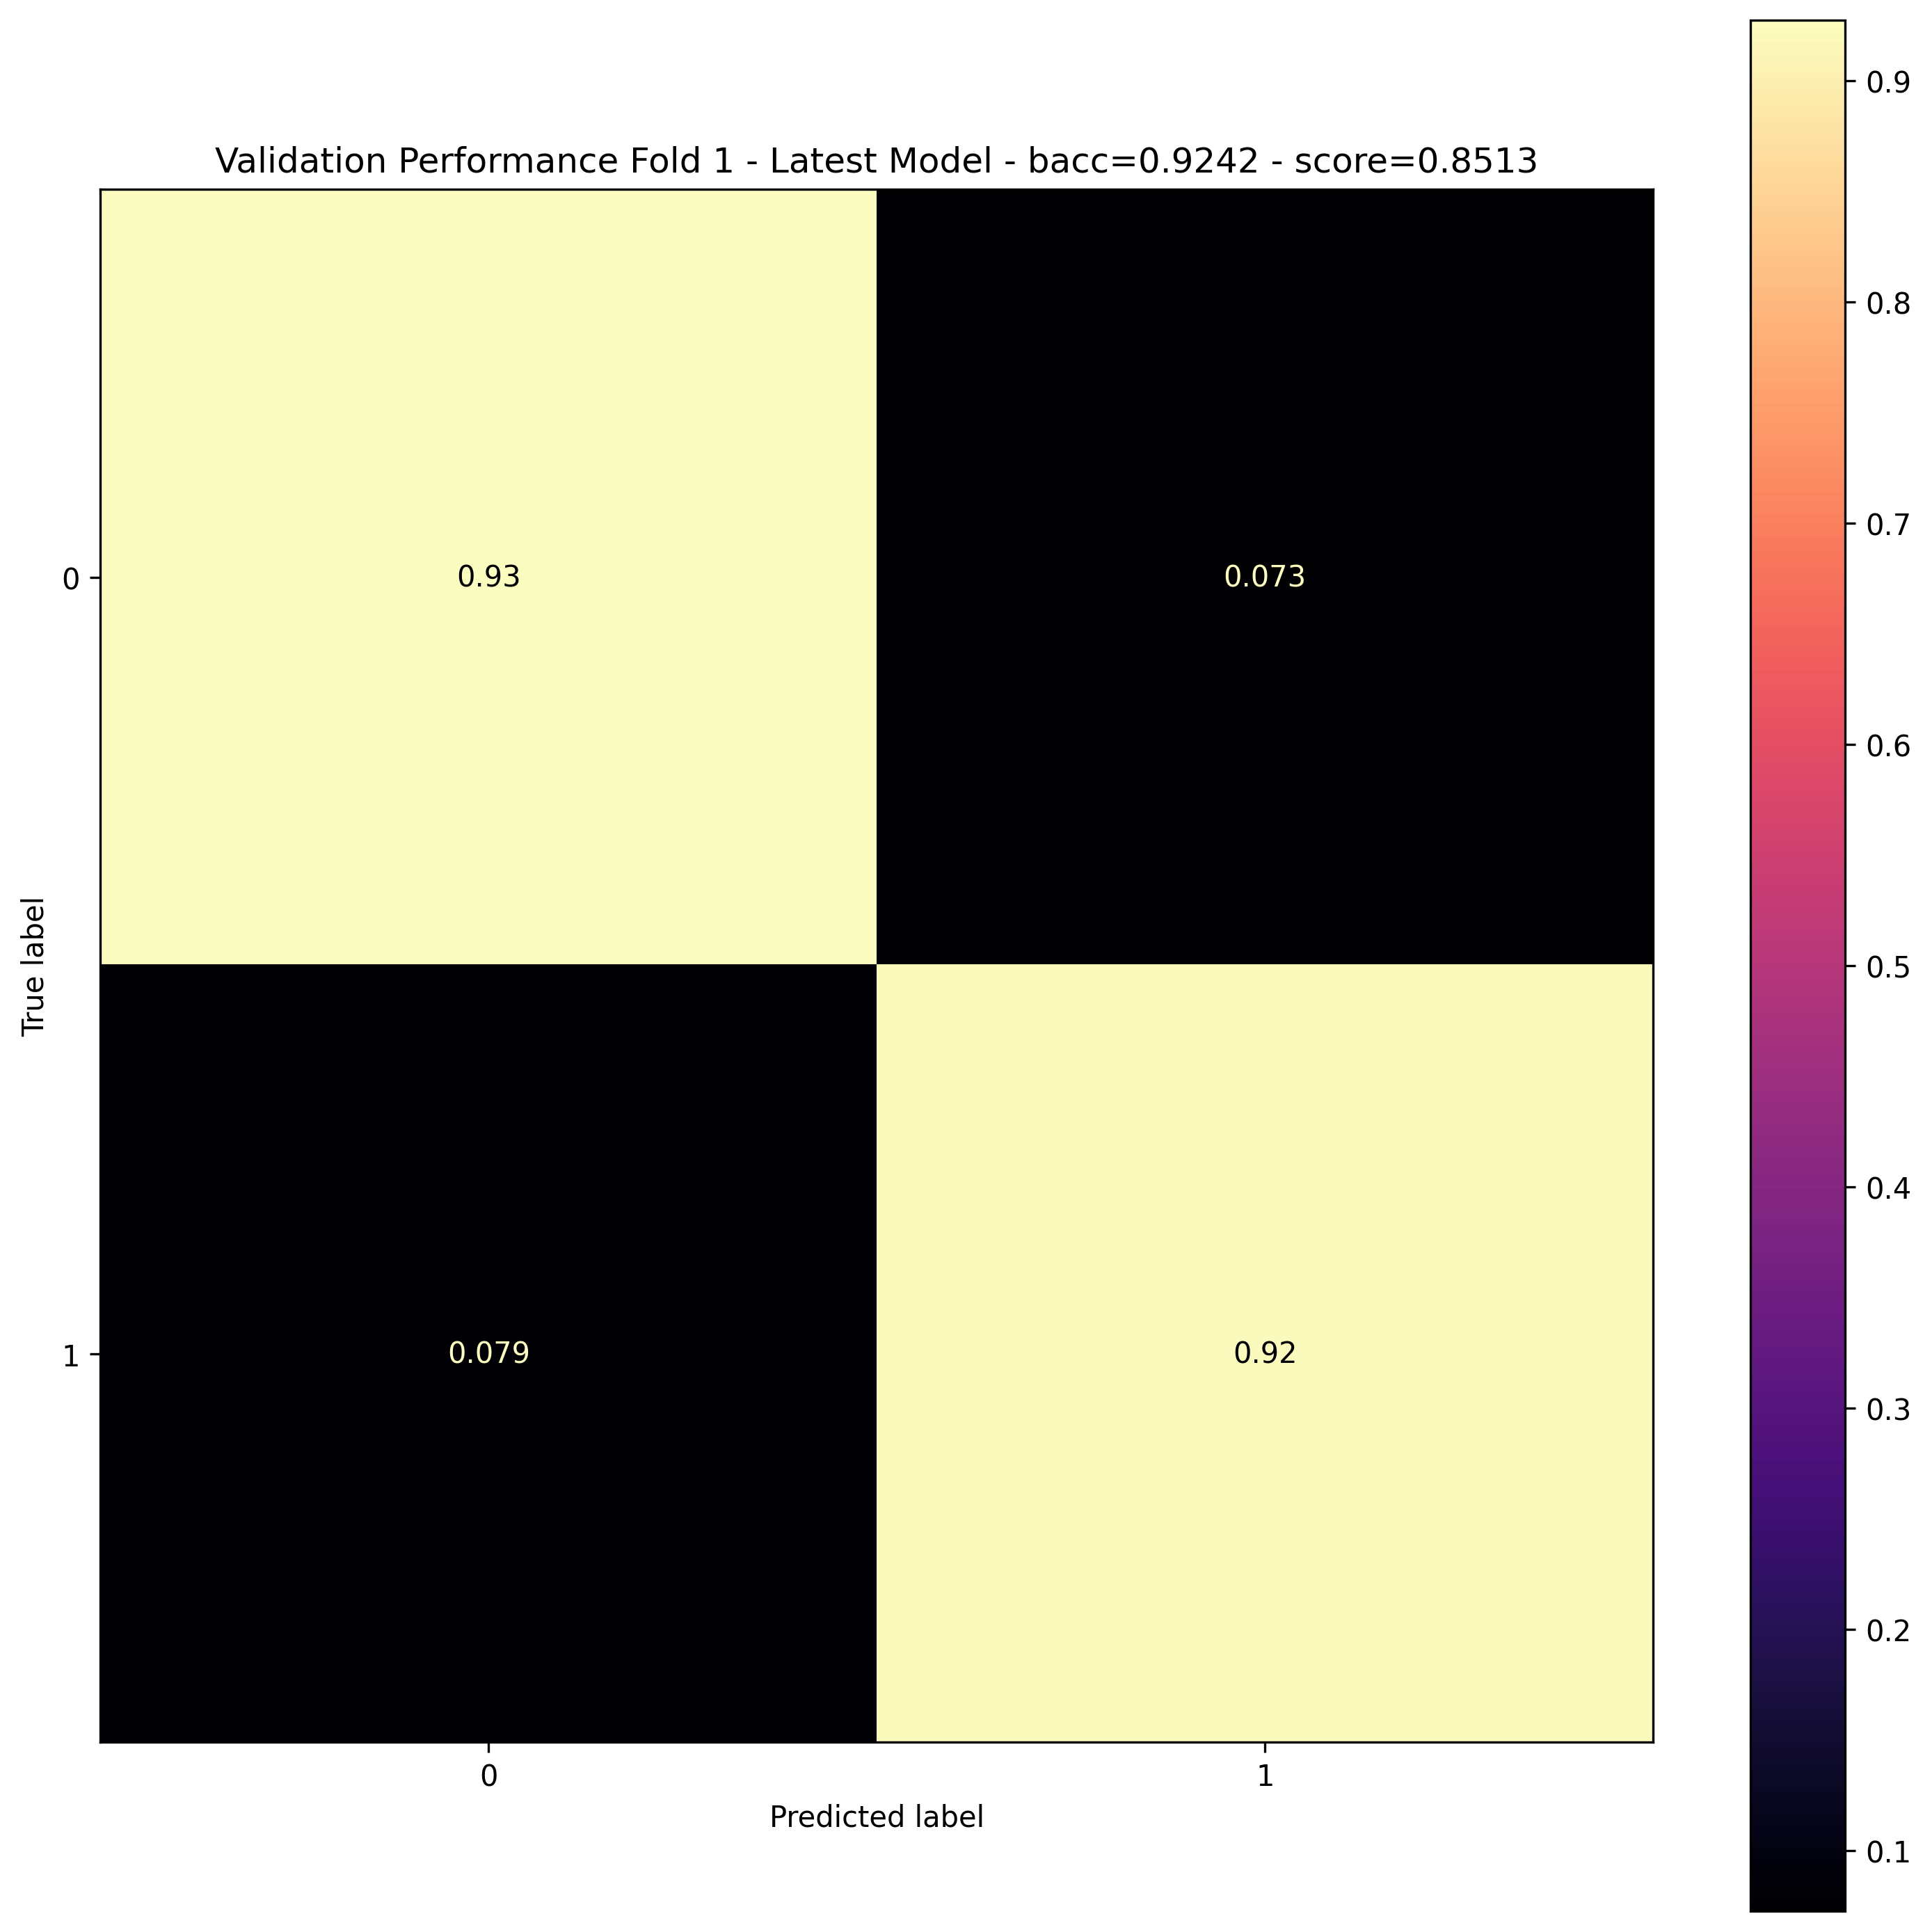

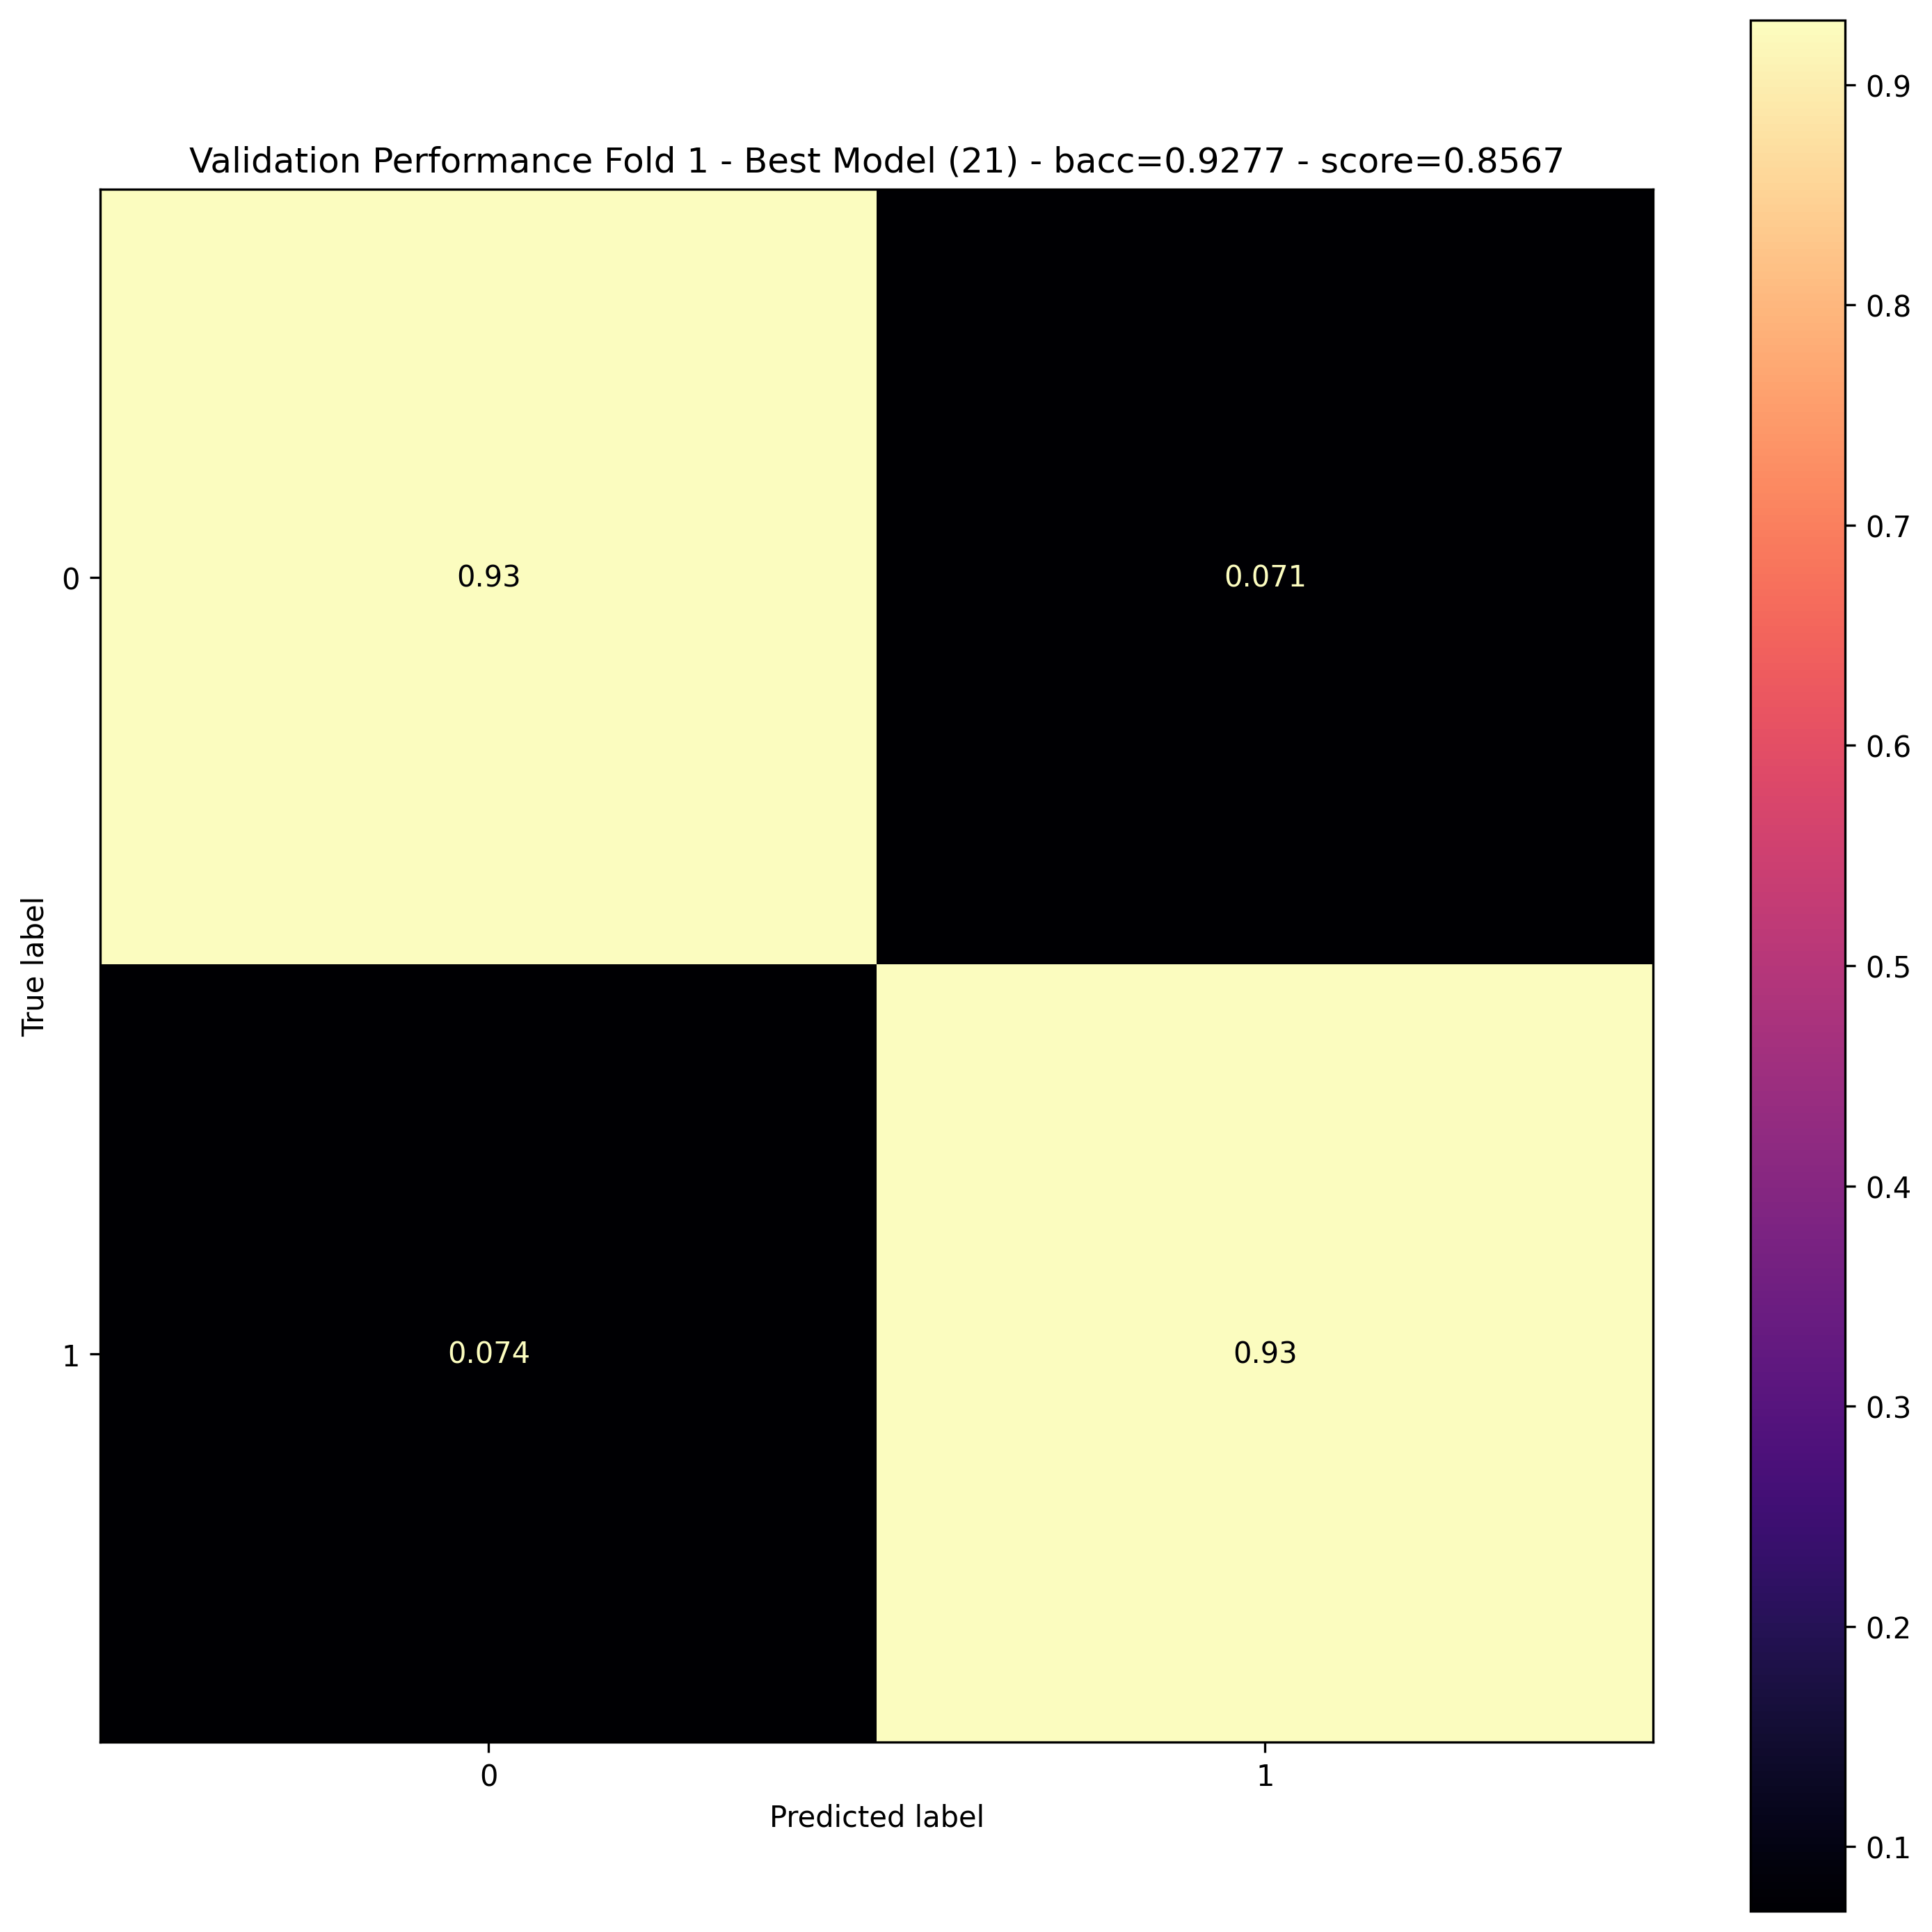


Testing fold 1


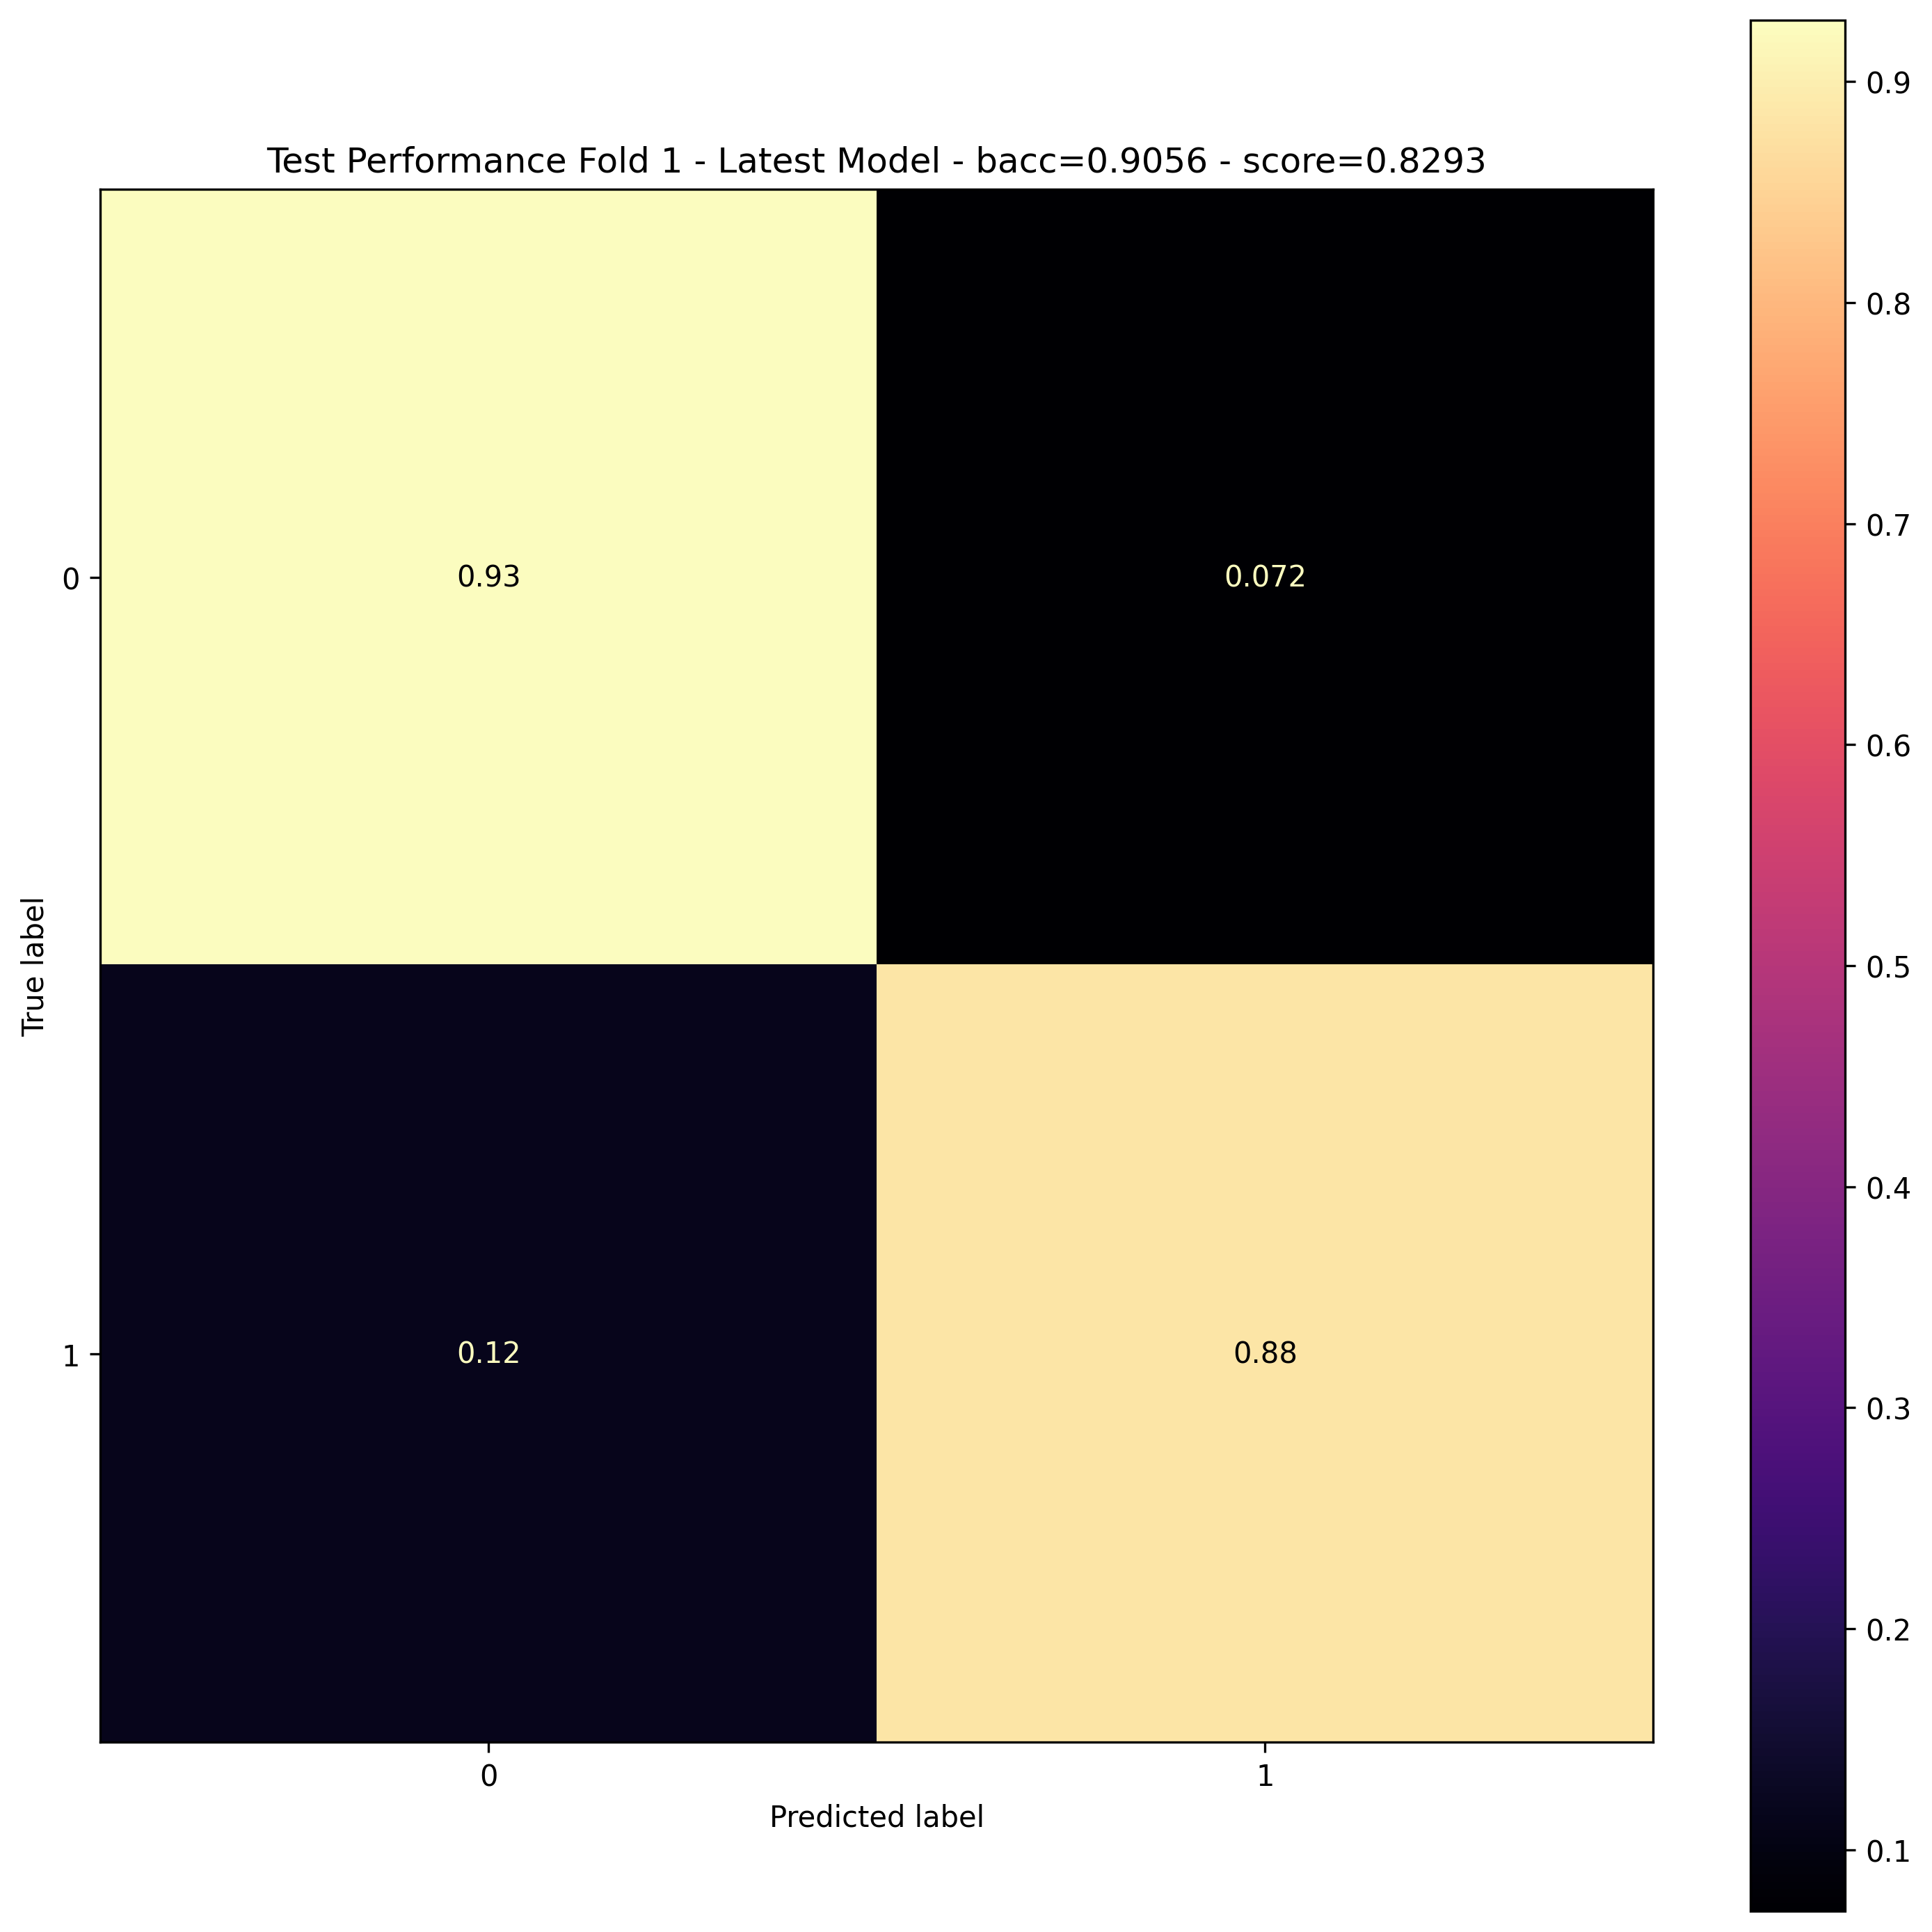

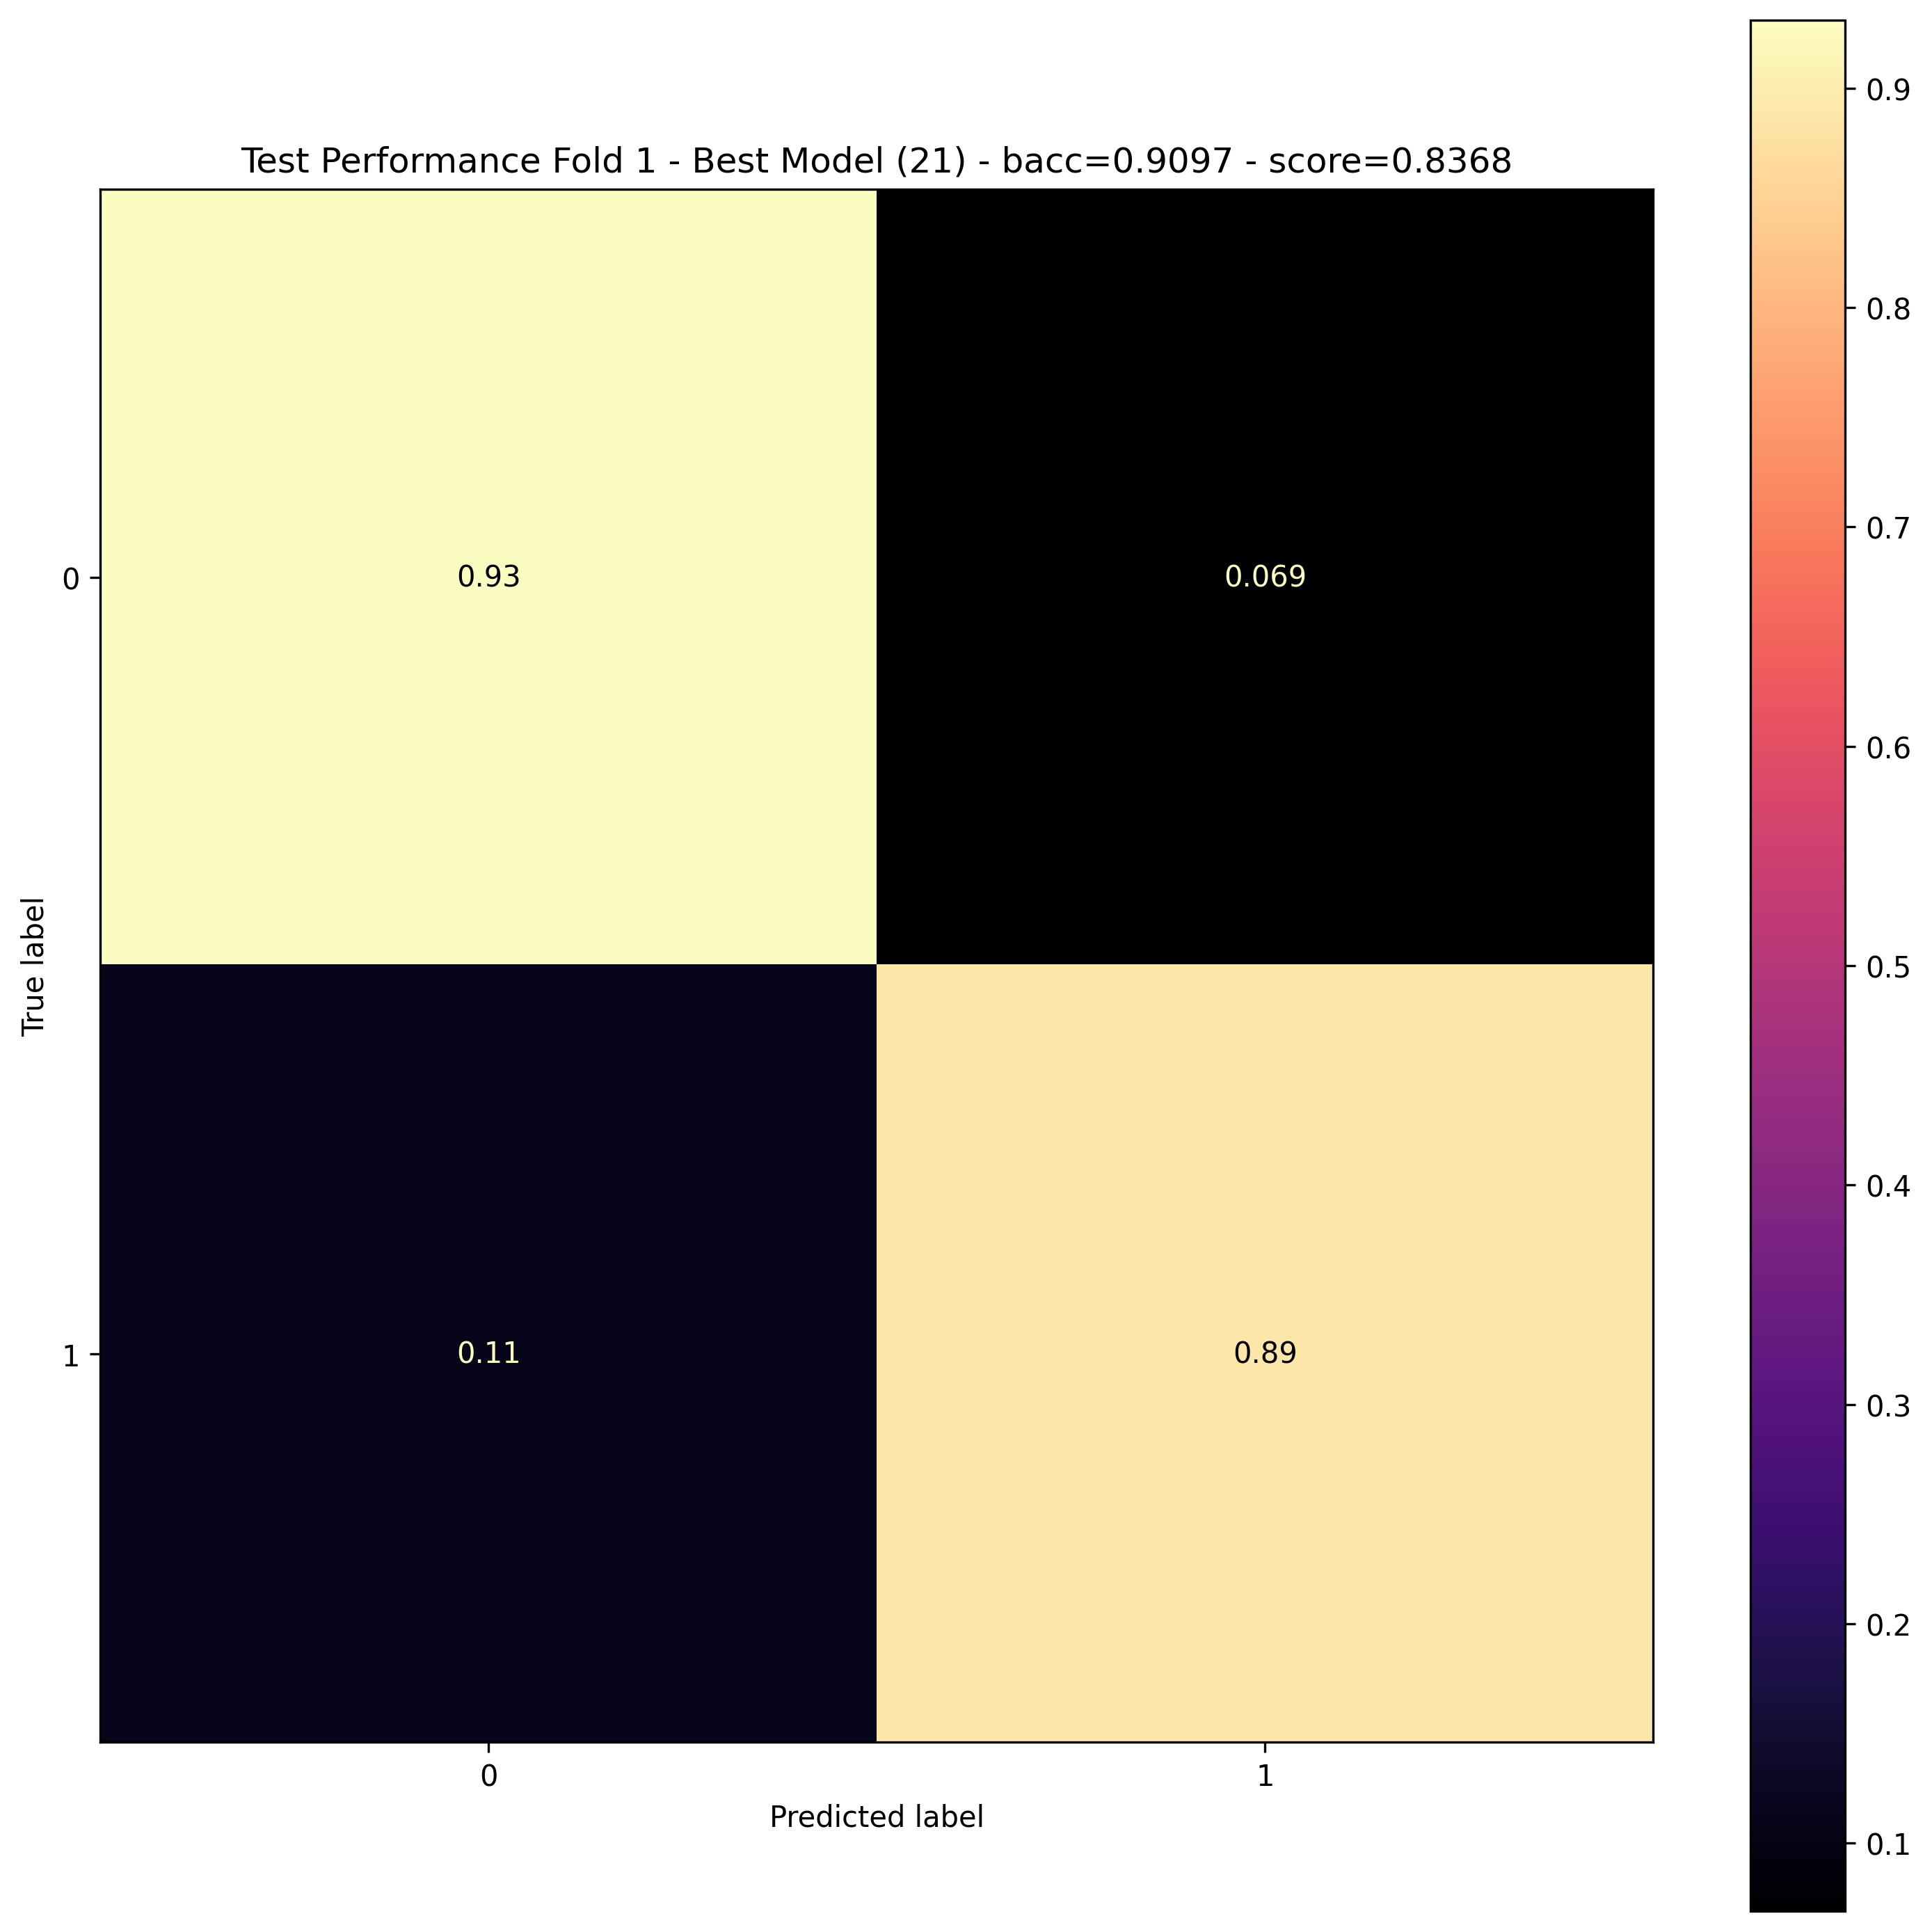

CV Folds:  25%|███████████████████████████████████████████████████▎                                                                                                                                                         | 2/8 [00:23<01:09, 11.60s/it]

Best Model Test Metrics: epoch =    -1, avg_loss = 0.000038, num_samples = 12000, num_correct = 11021, acc = 0.918417, bacc = 0.909670, score = 0.836833
Saved model with scaler as "bird_no_bird_classifier cv2023-06-15_14.38 fold-1-best eval-score=0.8567 test-score=0.8368"



Executing CV for fold 2
Training fold 2


#### Training ####
##################
AttentionClassifier with 228274 parameters, in_fnn: 86848, attention_stack: 132096, out_fnn: 9330
##################

train label counts = [67226, 27274]
eval label counts  = [ 9677,  3823]

loss weights                    = [ 0.50,  2.46]
eval loss weights (theoretical) = [ 0.50,  2.53]


Training Epoch   1/25 : lr = 1.00E-02, epoch =     1, avg_loss = 0.000072, num_samples = 94500, num_correct = 38314, acc = 0.405439, bacc = 0.499768, score = -0.189122
Evaluation Epoch   1/25 : epoch =     1, avg_loss = 0.000118, num_samples = 13500, num_correct =  3823, acc = 0.283185, bacc = 0.500000, score = -0.433630
Training Epoch   2/25 : lr = 1

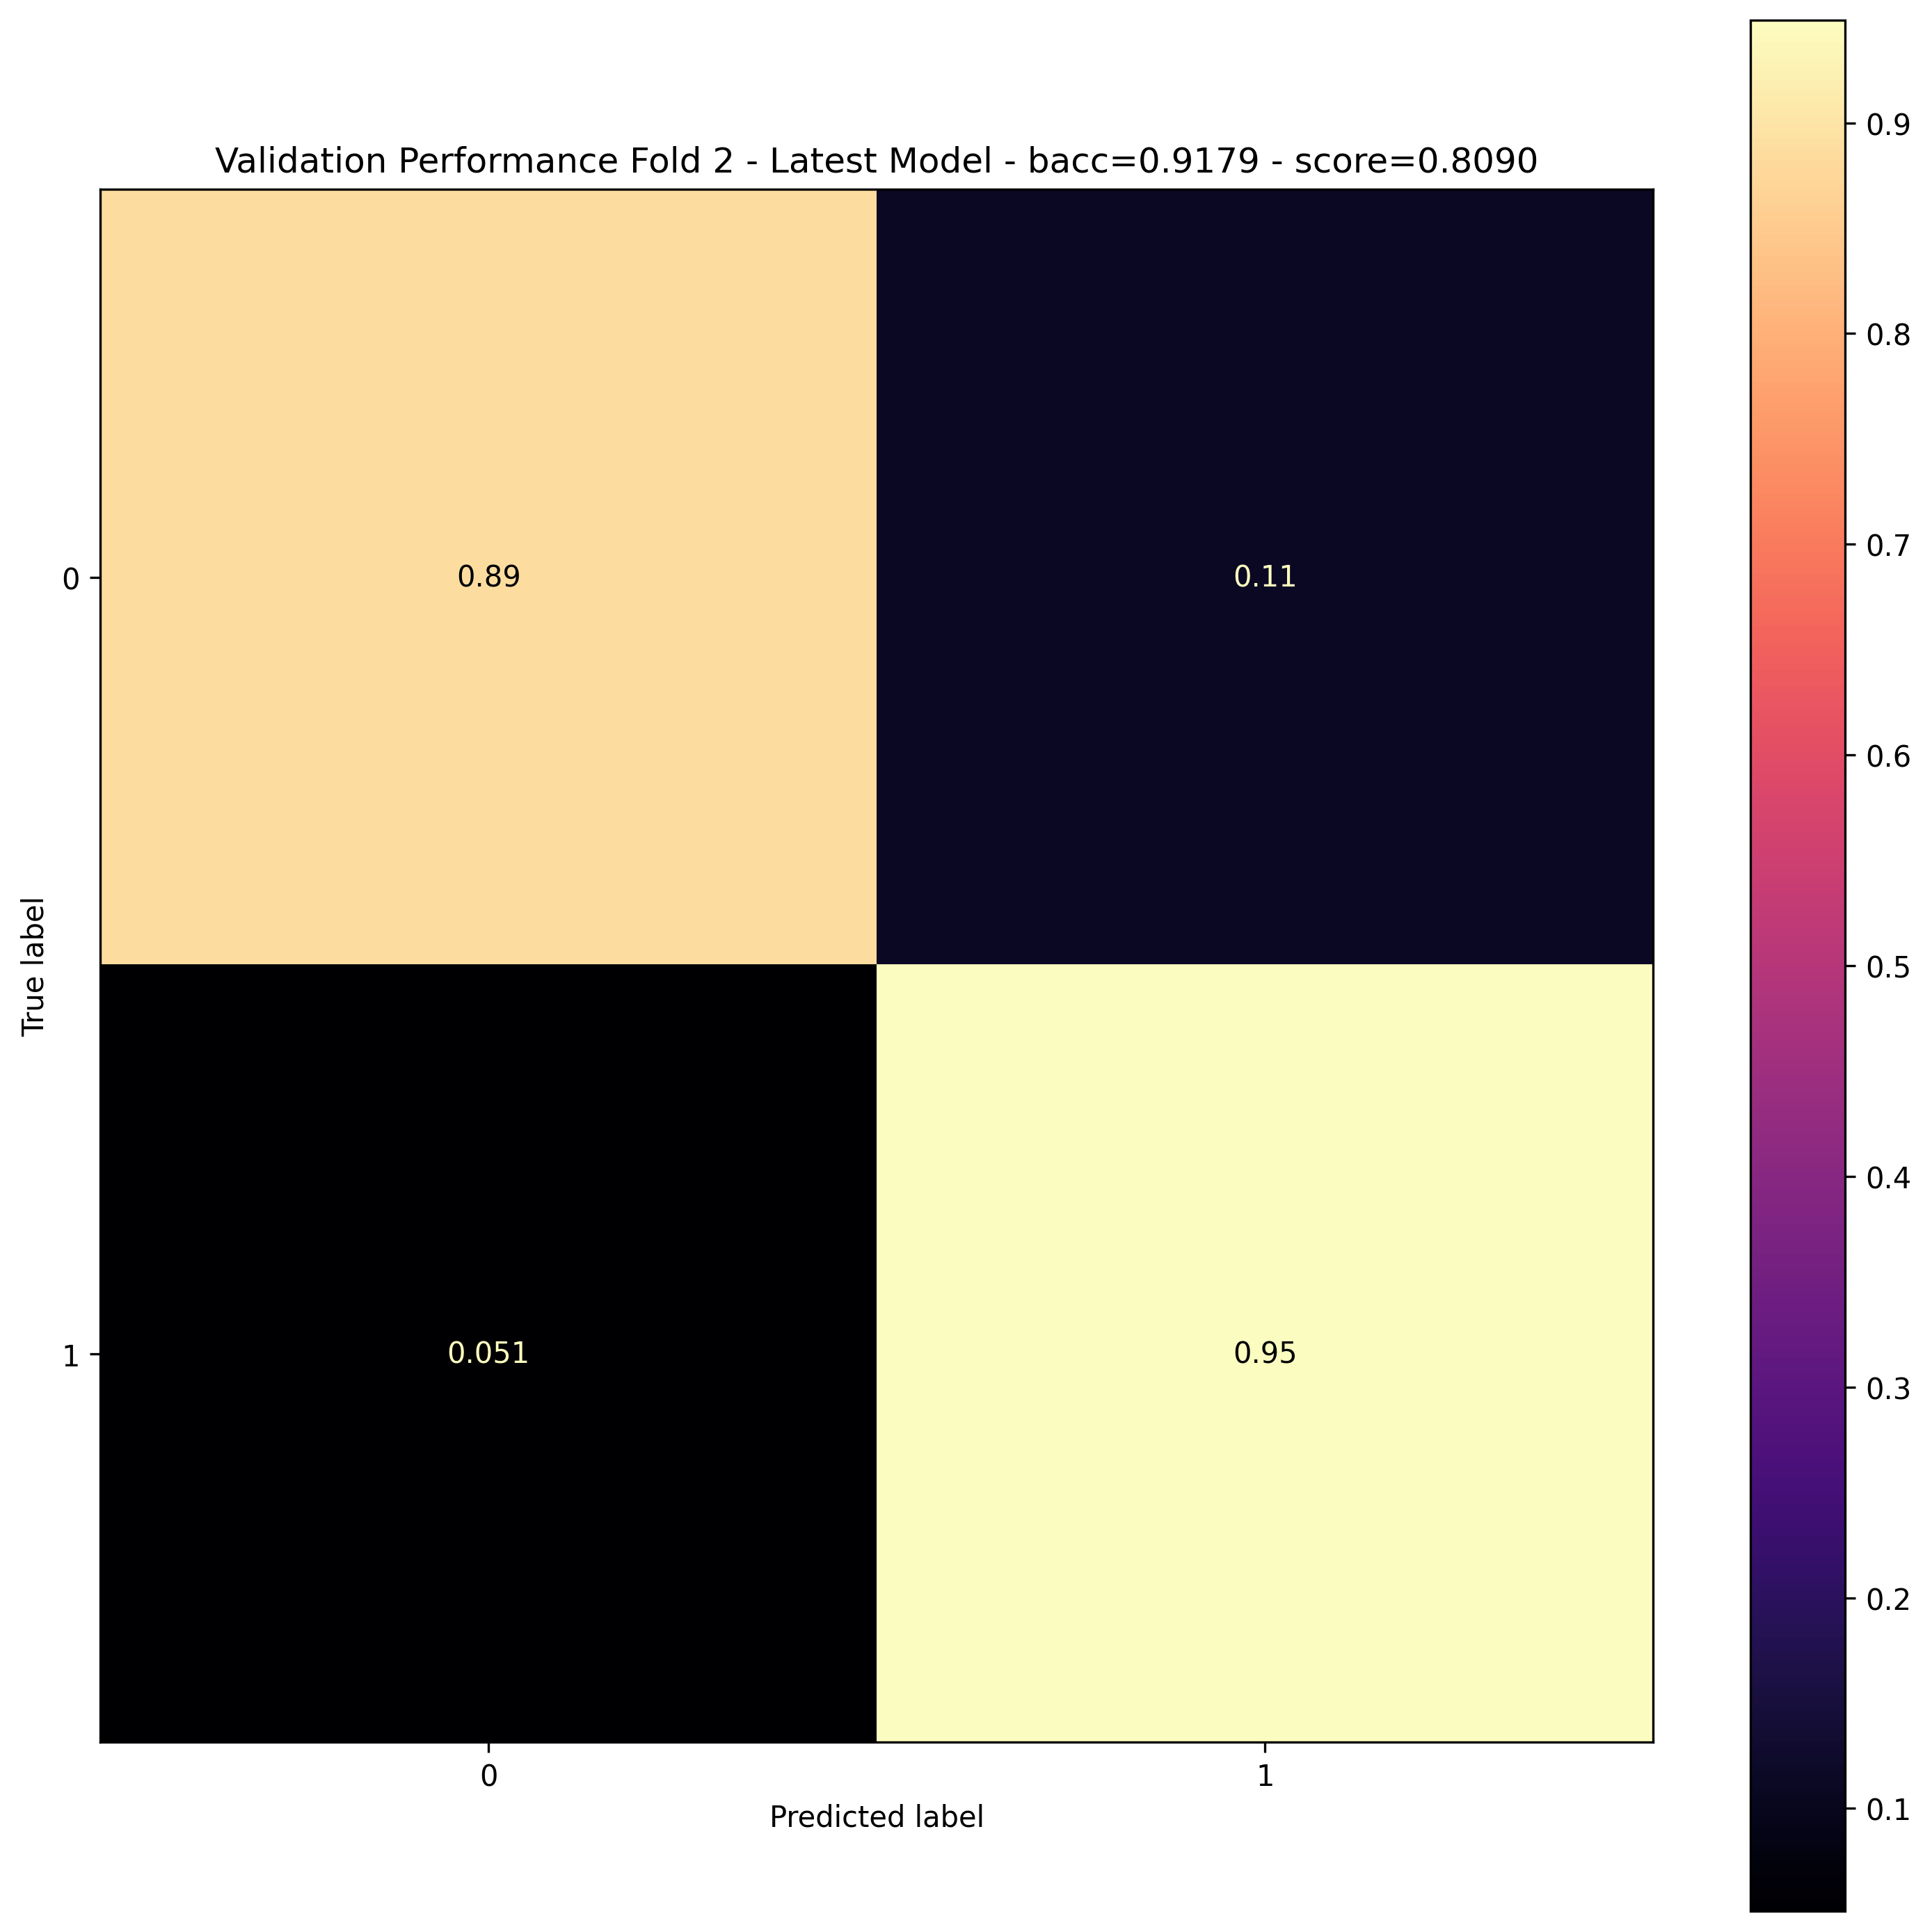

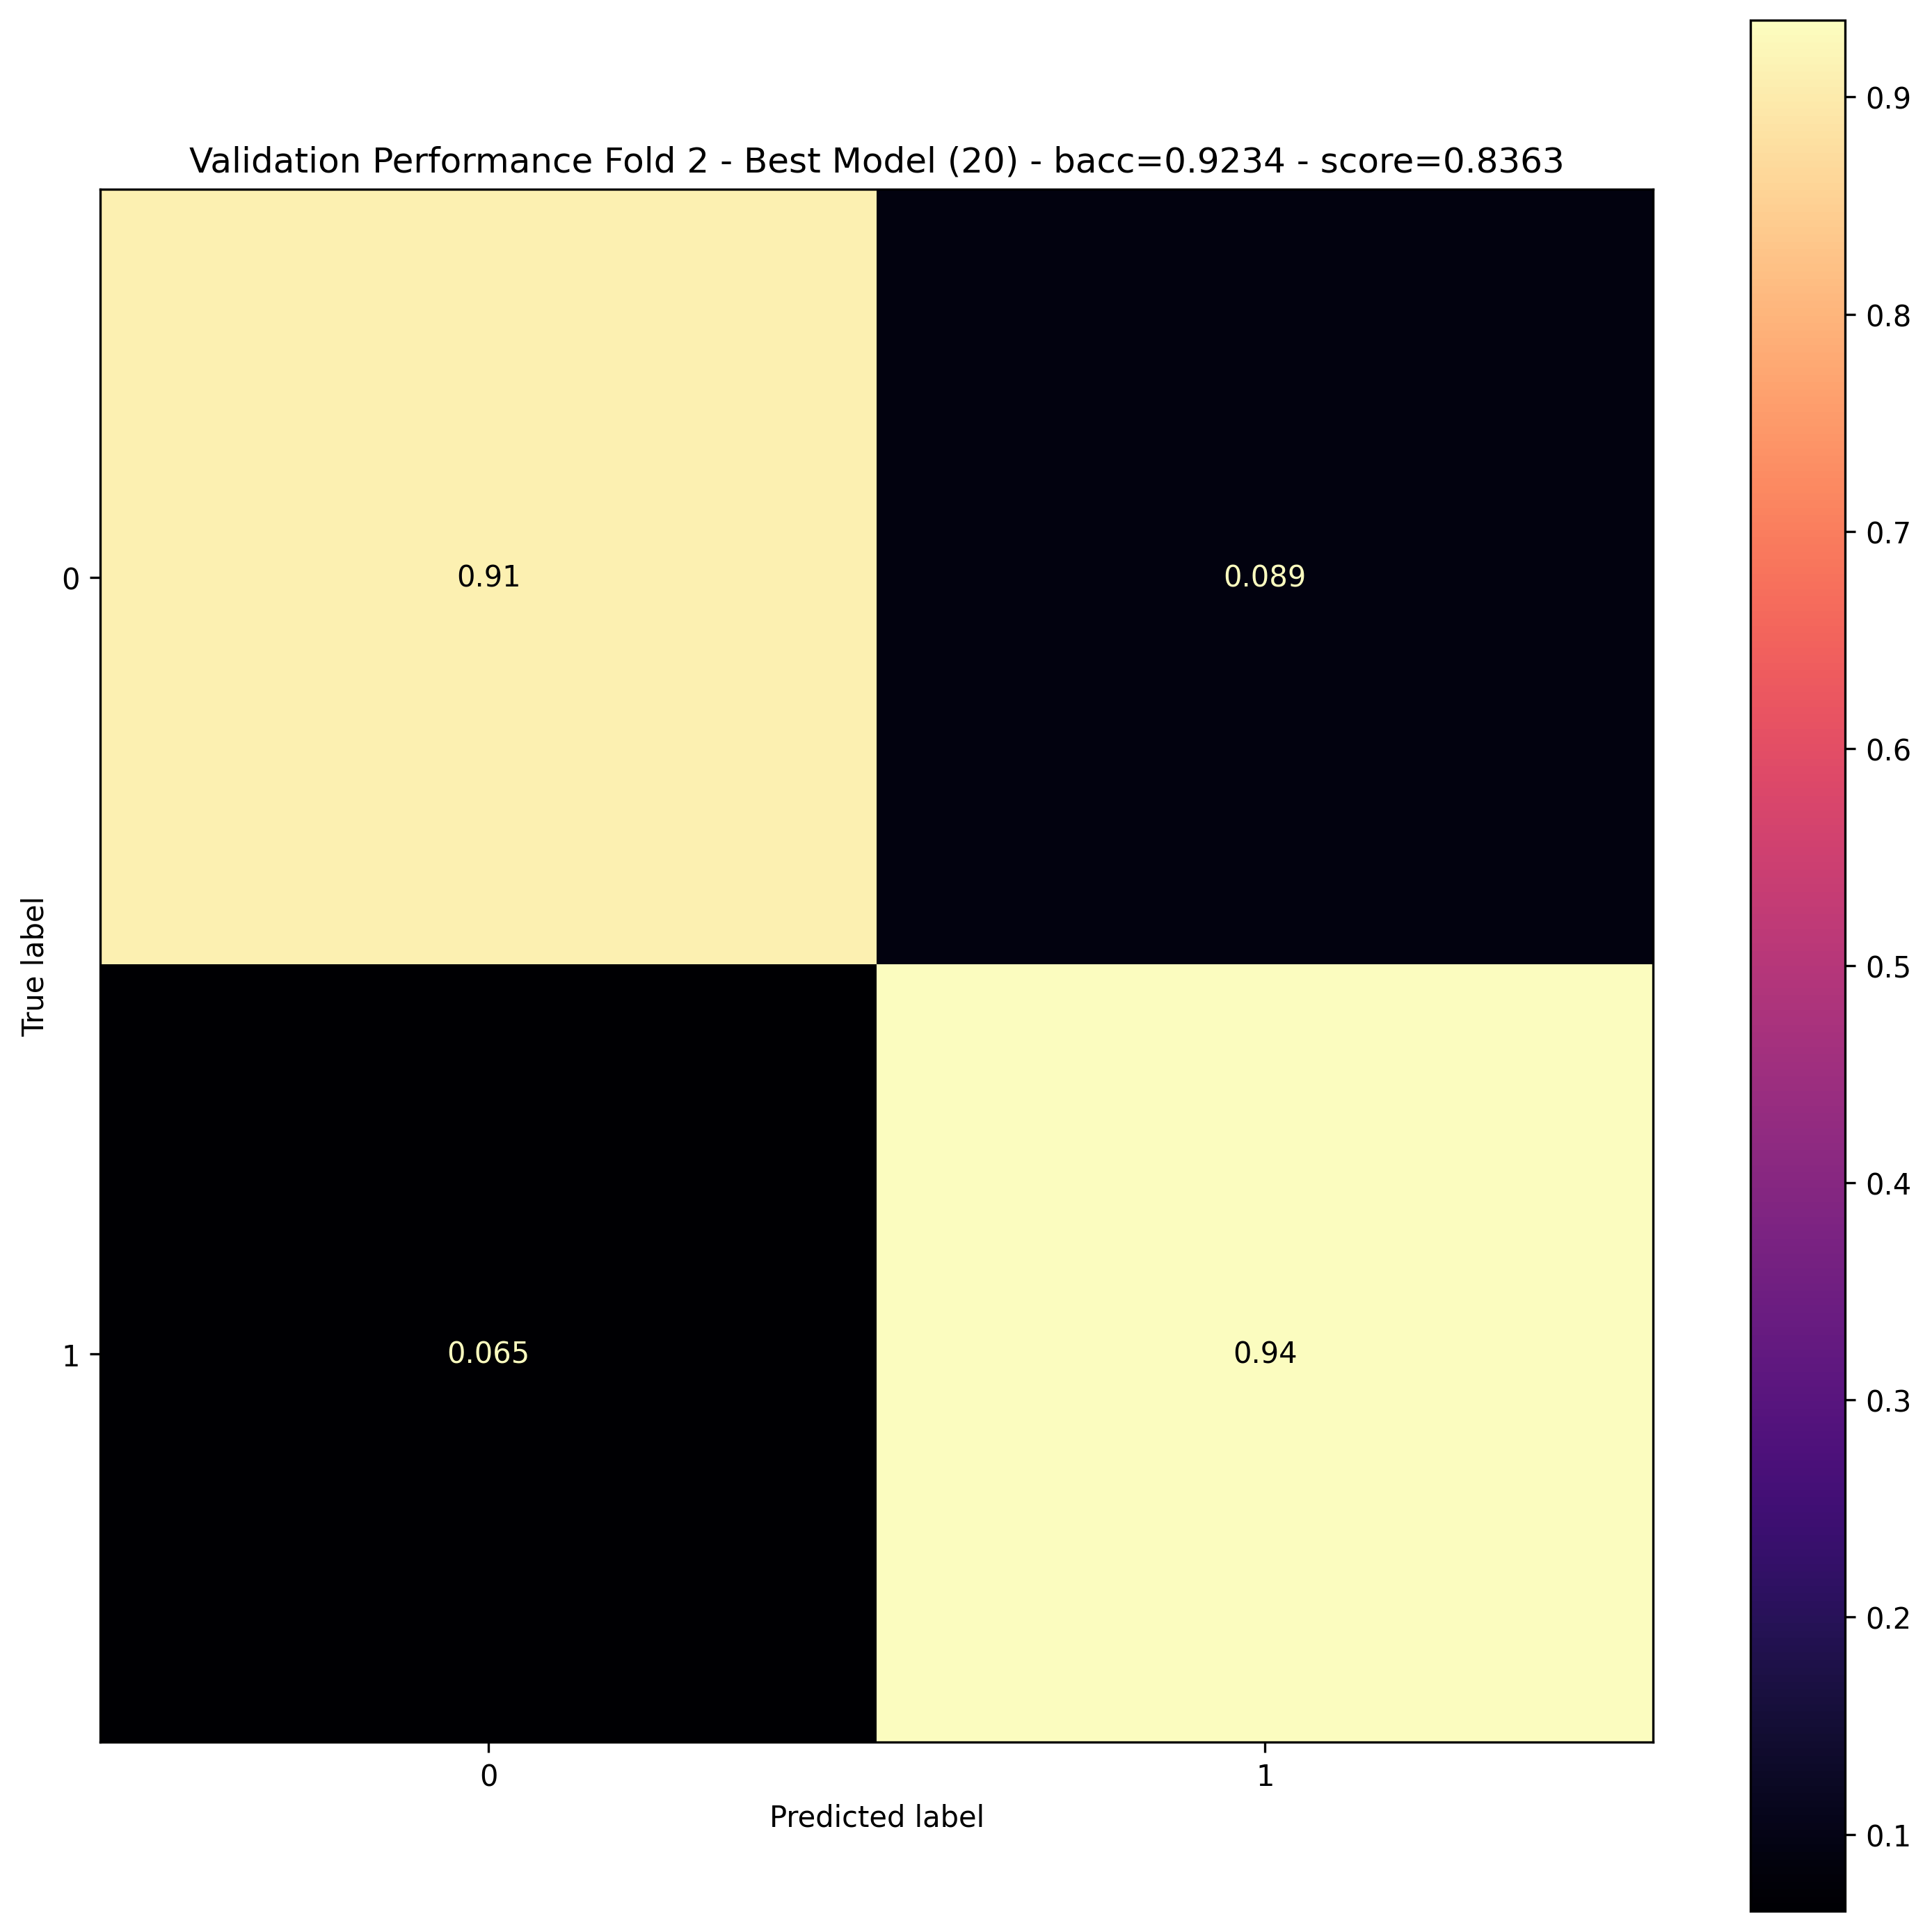


Testing fold 2


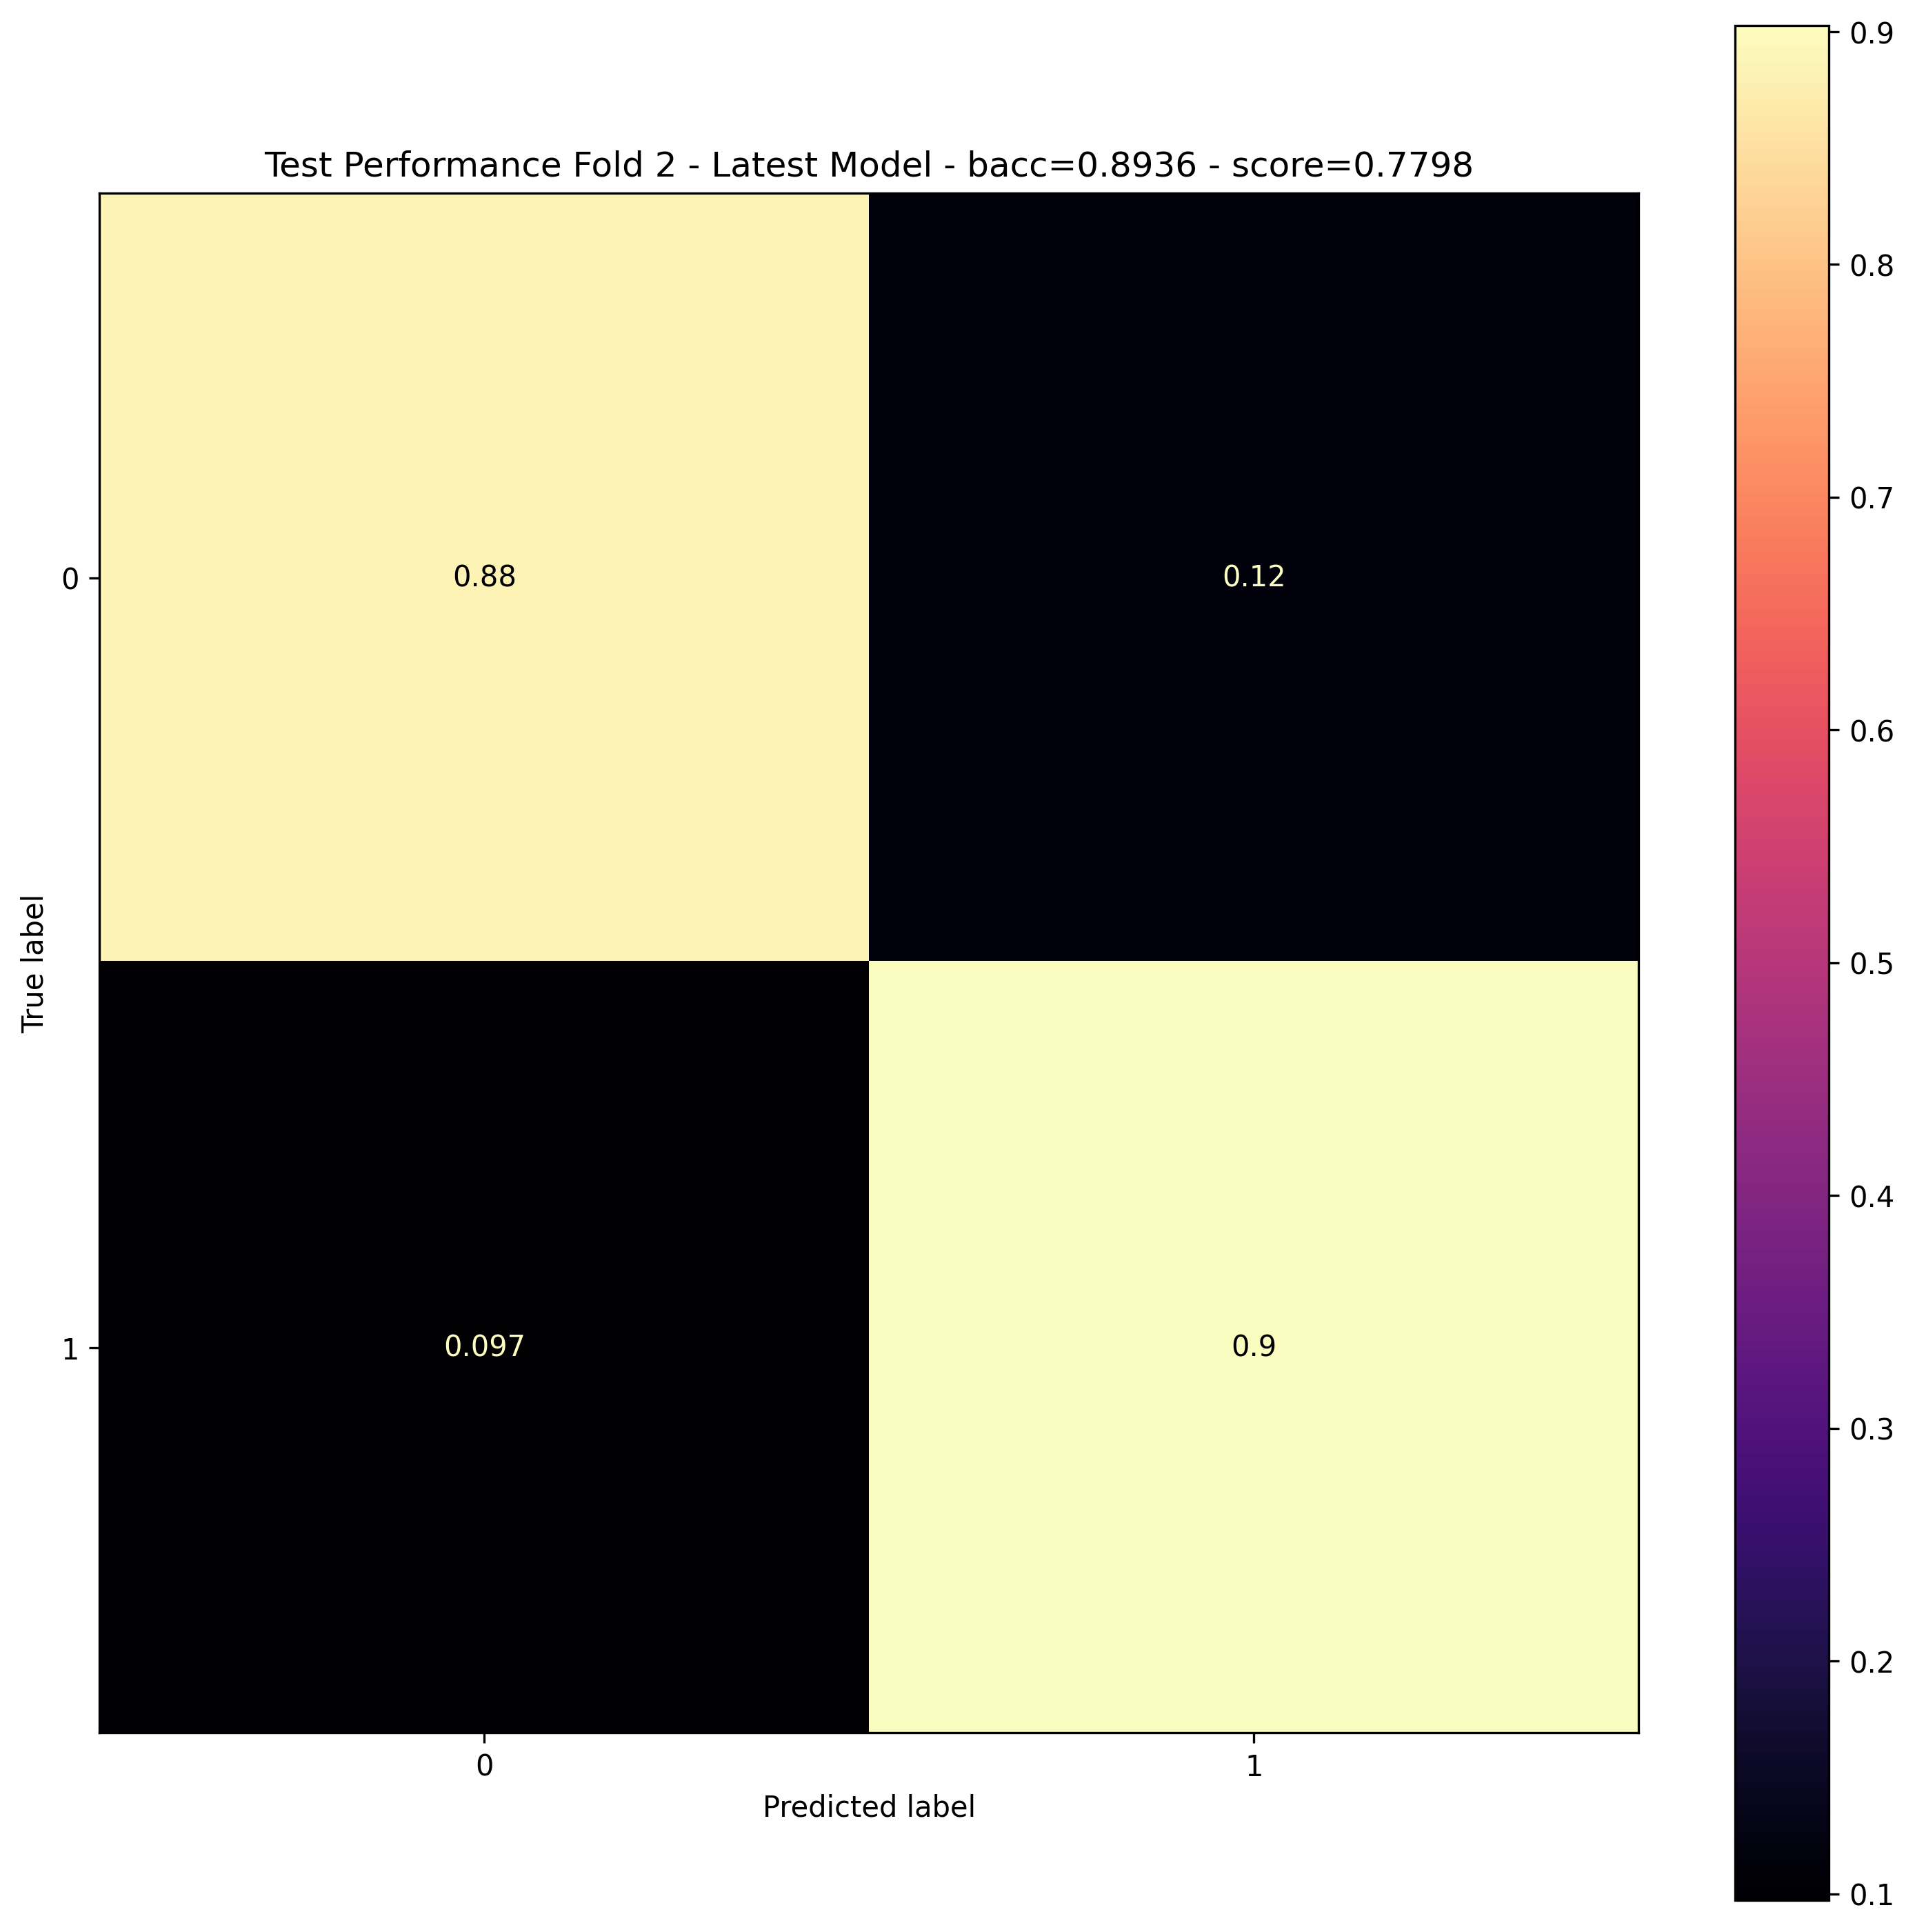

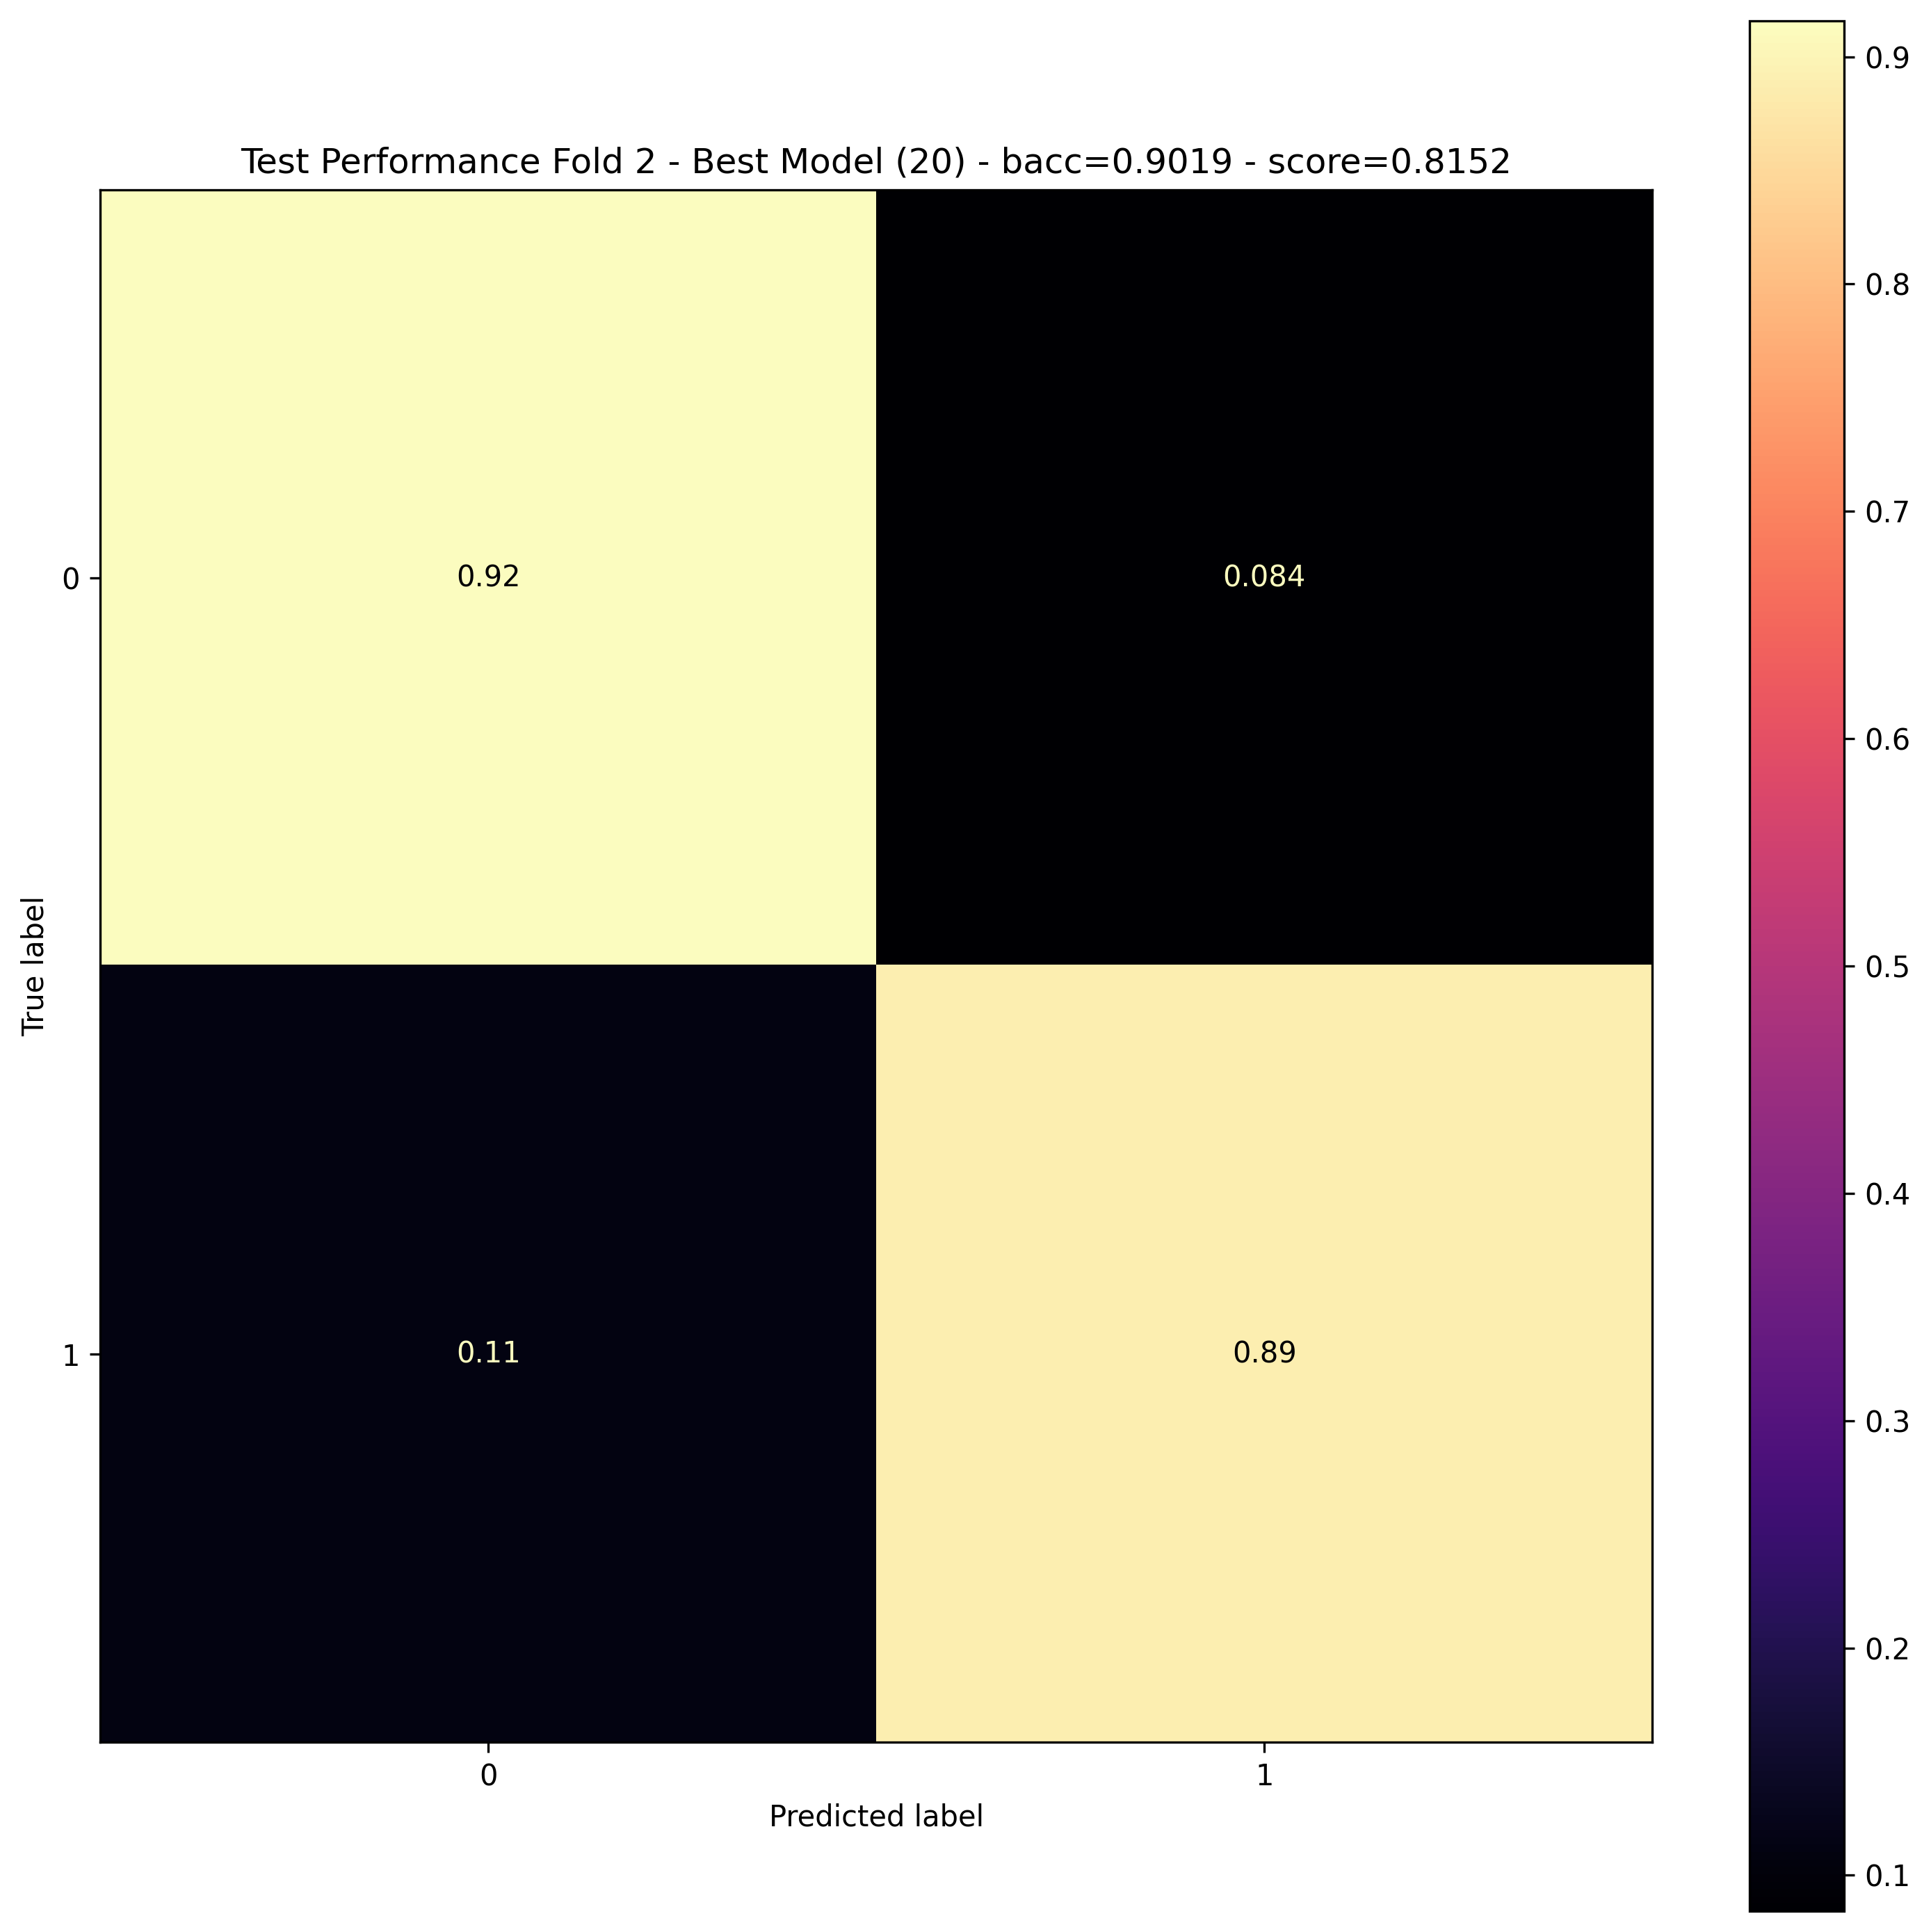

CV Folds:  38%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 3/8 [00:34<00:57, 11.52s/it]

Best Model Test Metrics: epoch =    -1, avg_loss = 0.000039, num_samples = 12000, num_correct = 10891, acc = 0.907583, bacc = 0.901900, score = 0.815167
Saved model with scaler as "bird_no_bird_classifier cv2023-06-15_14.38 fold-2-best eval-score=0.8363 test-score=0.8152"



Executing CV for fold 3
Training fold 3


#### Training ####
##################
AttentionClassifier with 228274 parameters, in_fnn: 86848, attention_stack: 132096, out_fnn: 9330
##################

train label counts = [67337, 27163]
eval label counts  = [ 9566,  3934]

loss weights                    = [ 0.50,  2.48]
eval loss weights (theoretical) = [ 0.50,  2.43]


Training Epoch   1/25 : lr = 1.00E-02, epoch =     1, avg_loss = 0.000099, num_samples = 94500, num_correct = 31288, acc = 0.331090, bacc = 0.501593, score = -0.337820
Evaluation Epoch   1/25 : epoch =     1, avg_loss = 0.000127, num_samples = 13500, num_correct =  3934, acc = 0.291407, bacc = 0.500000, score = -0.417185
Training Epoch   2/25 : lr = 1

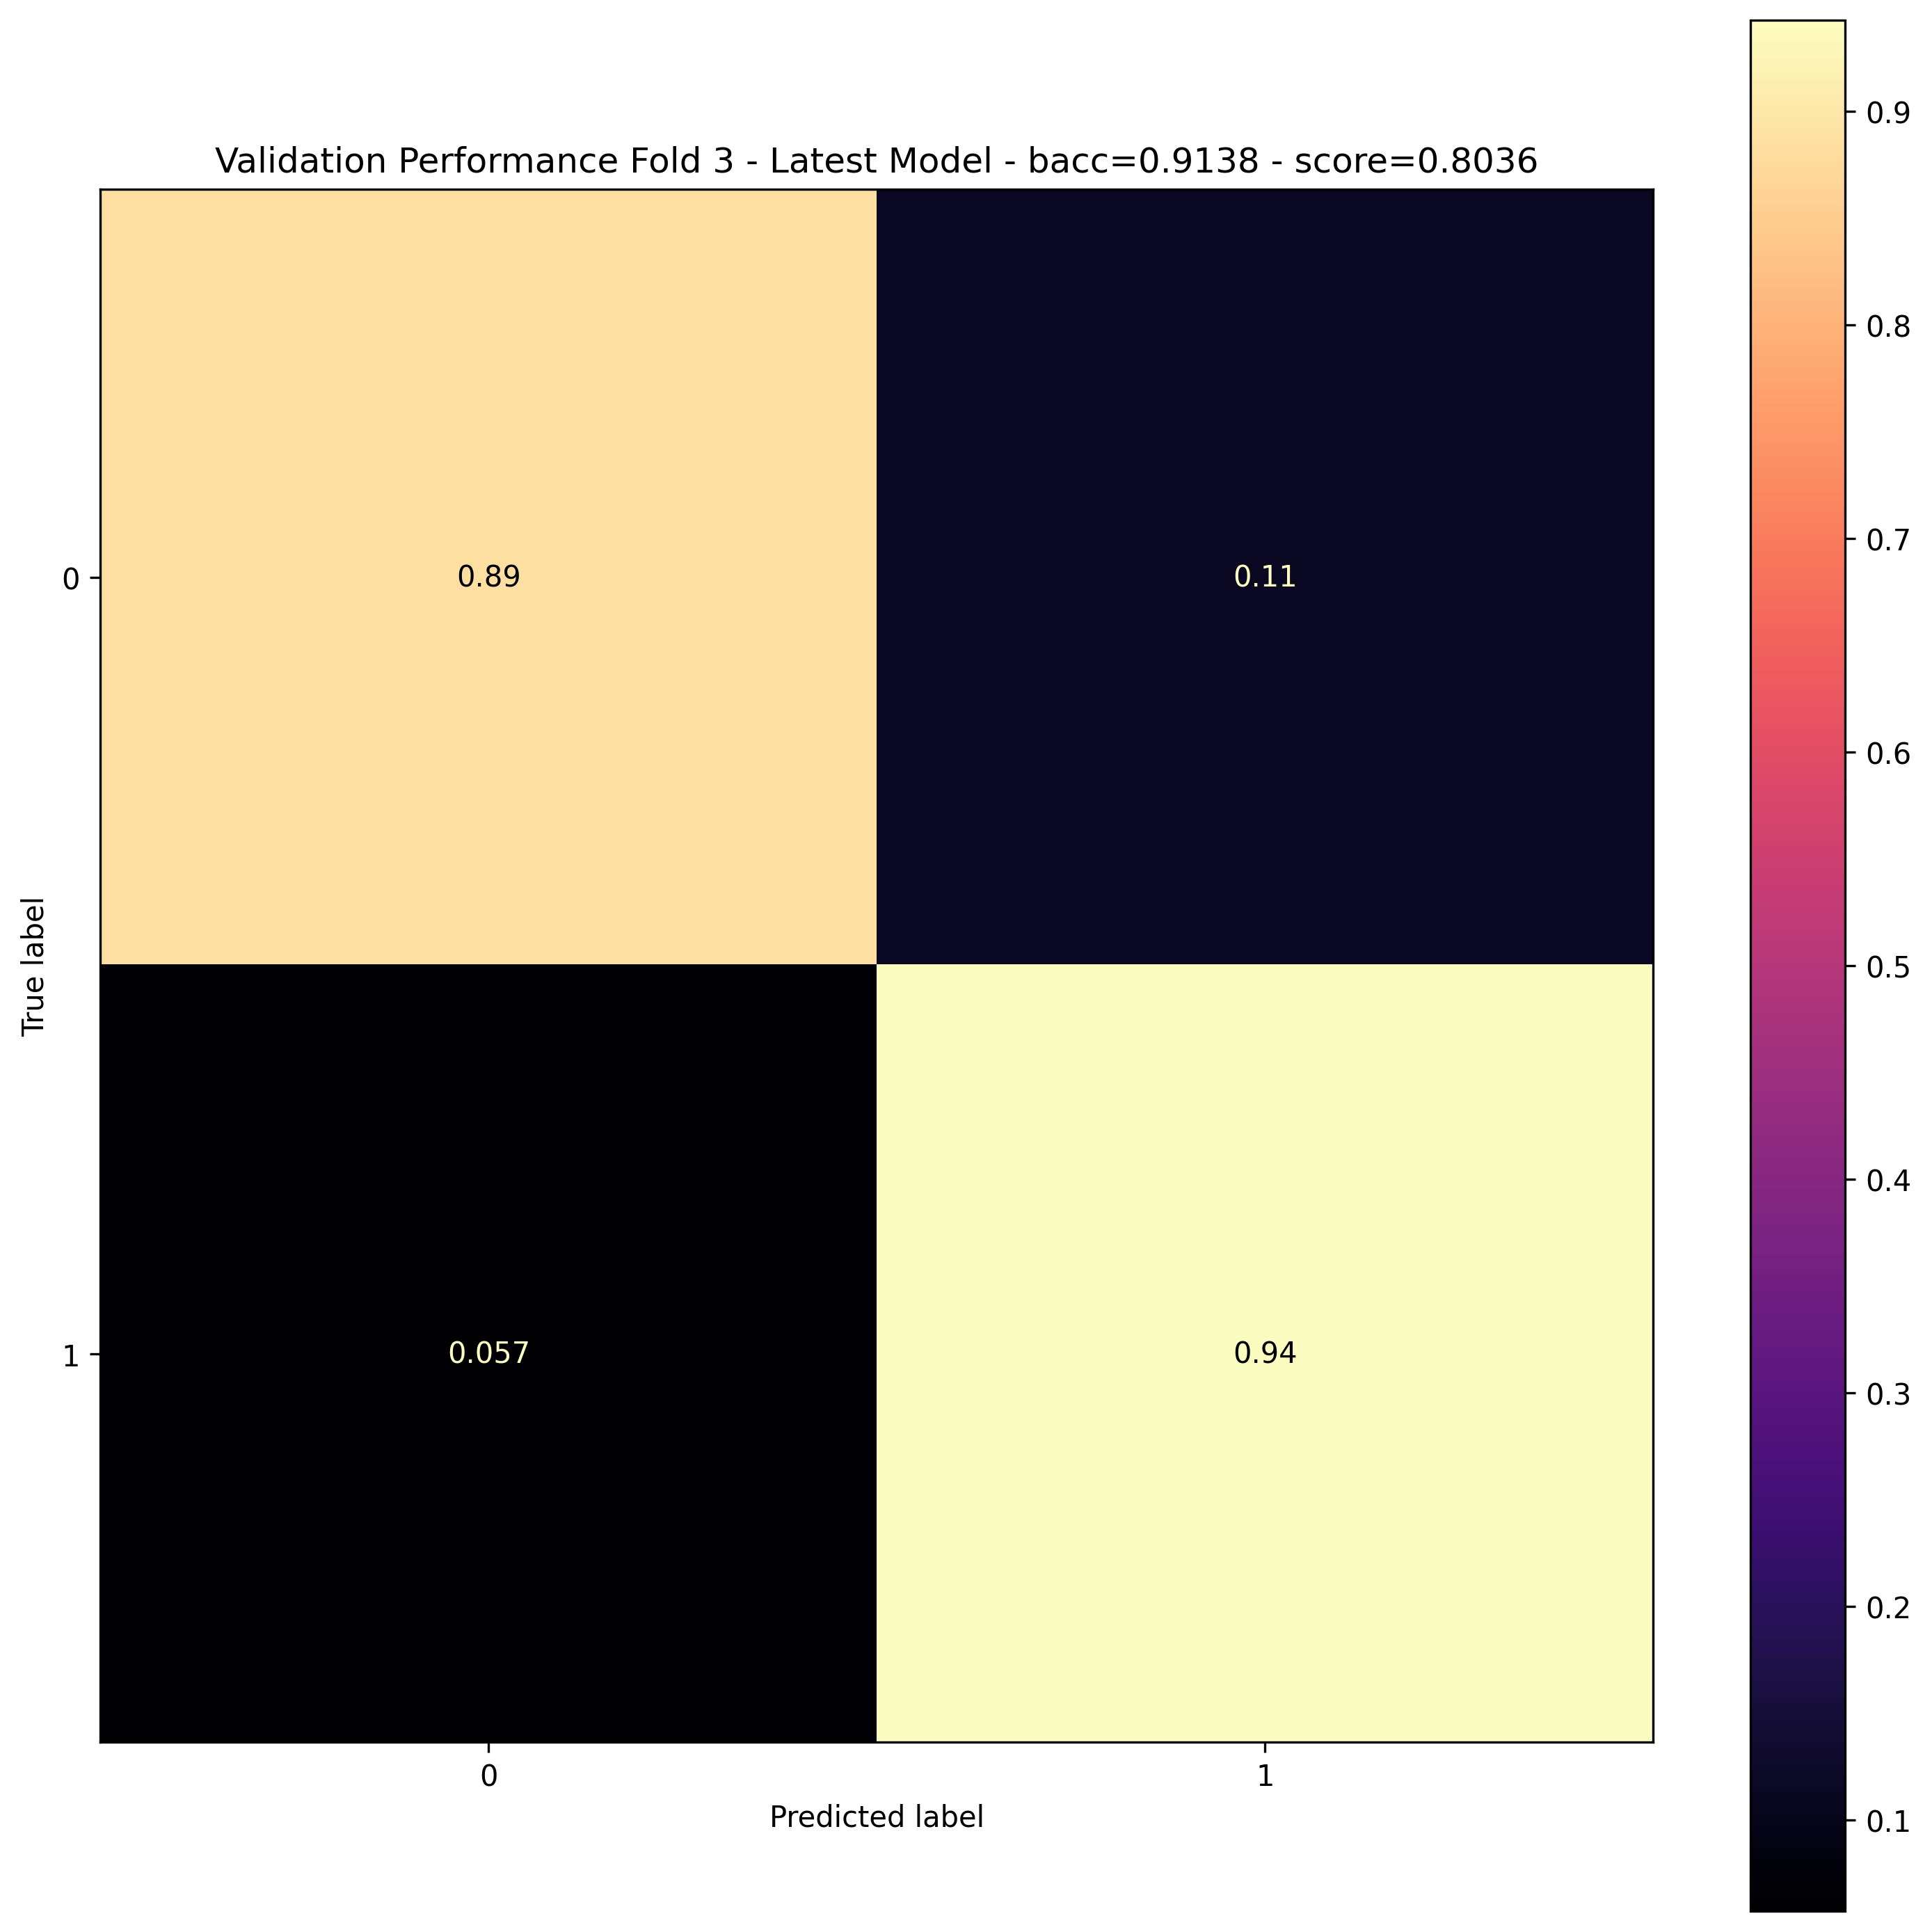

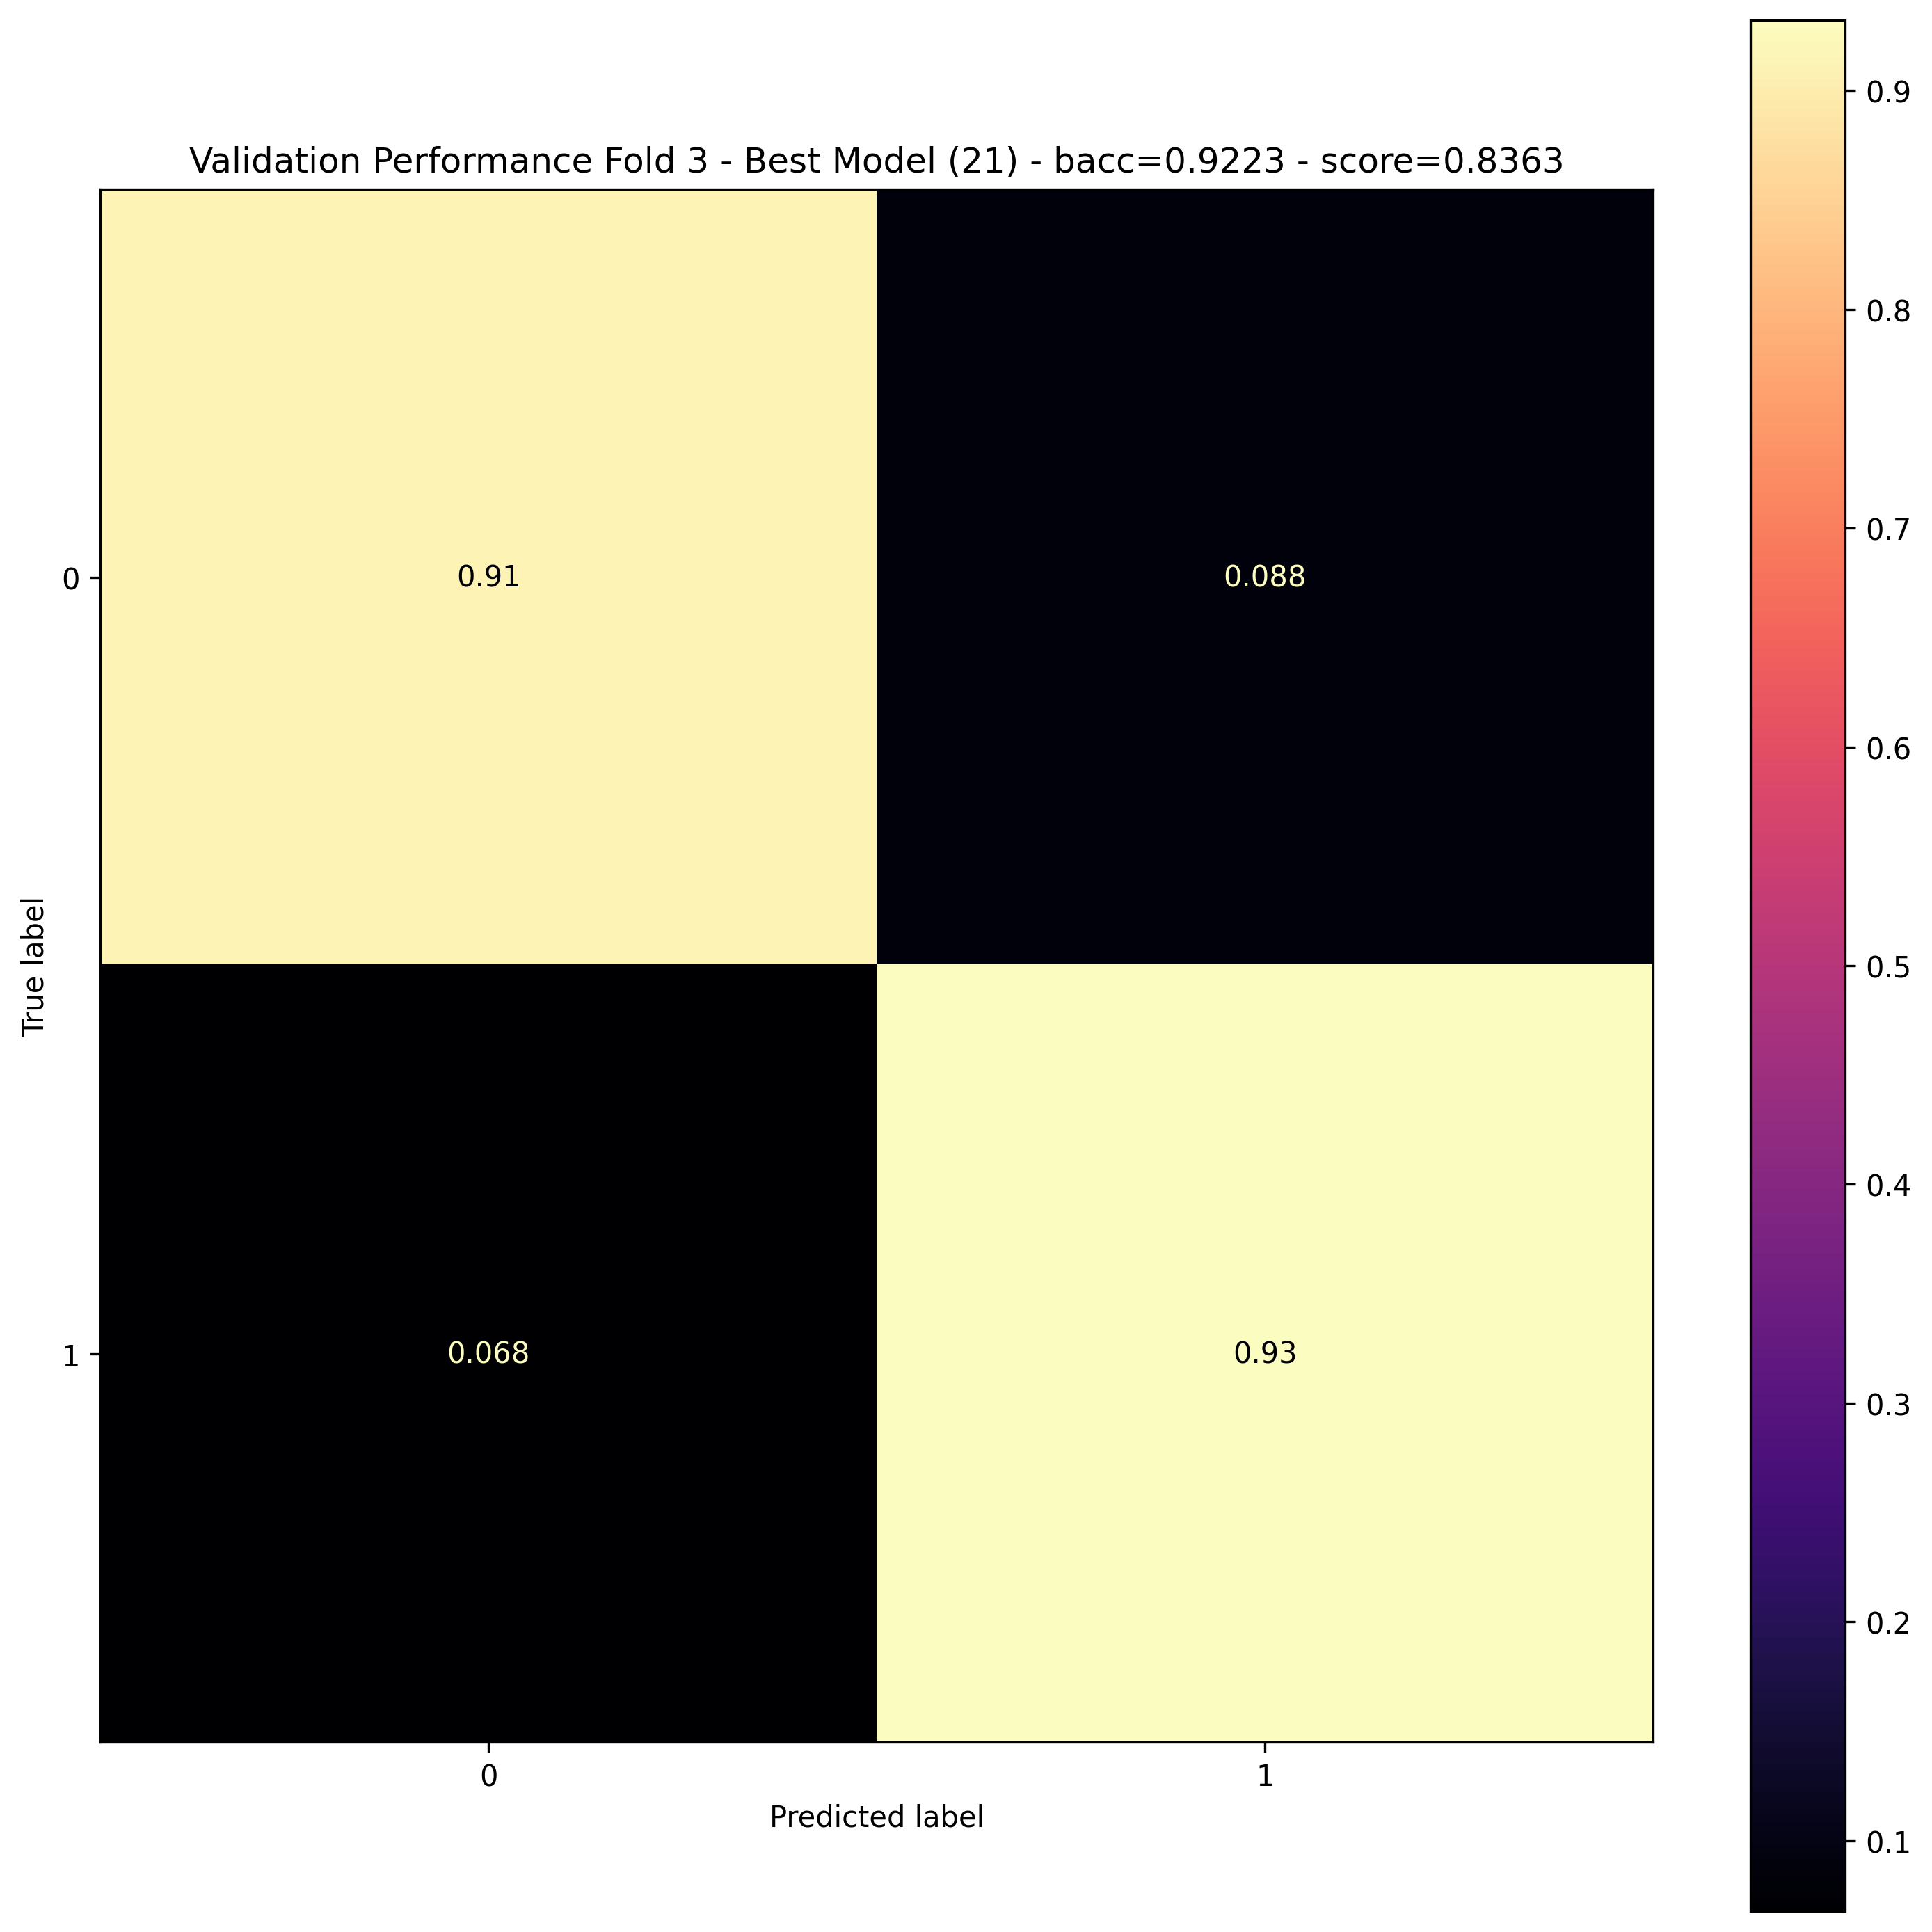


Testing fold 3


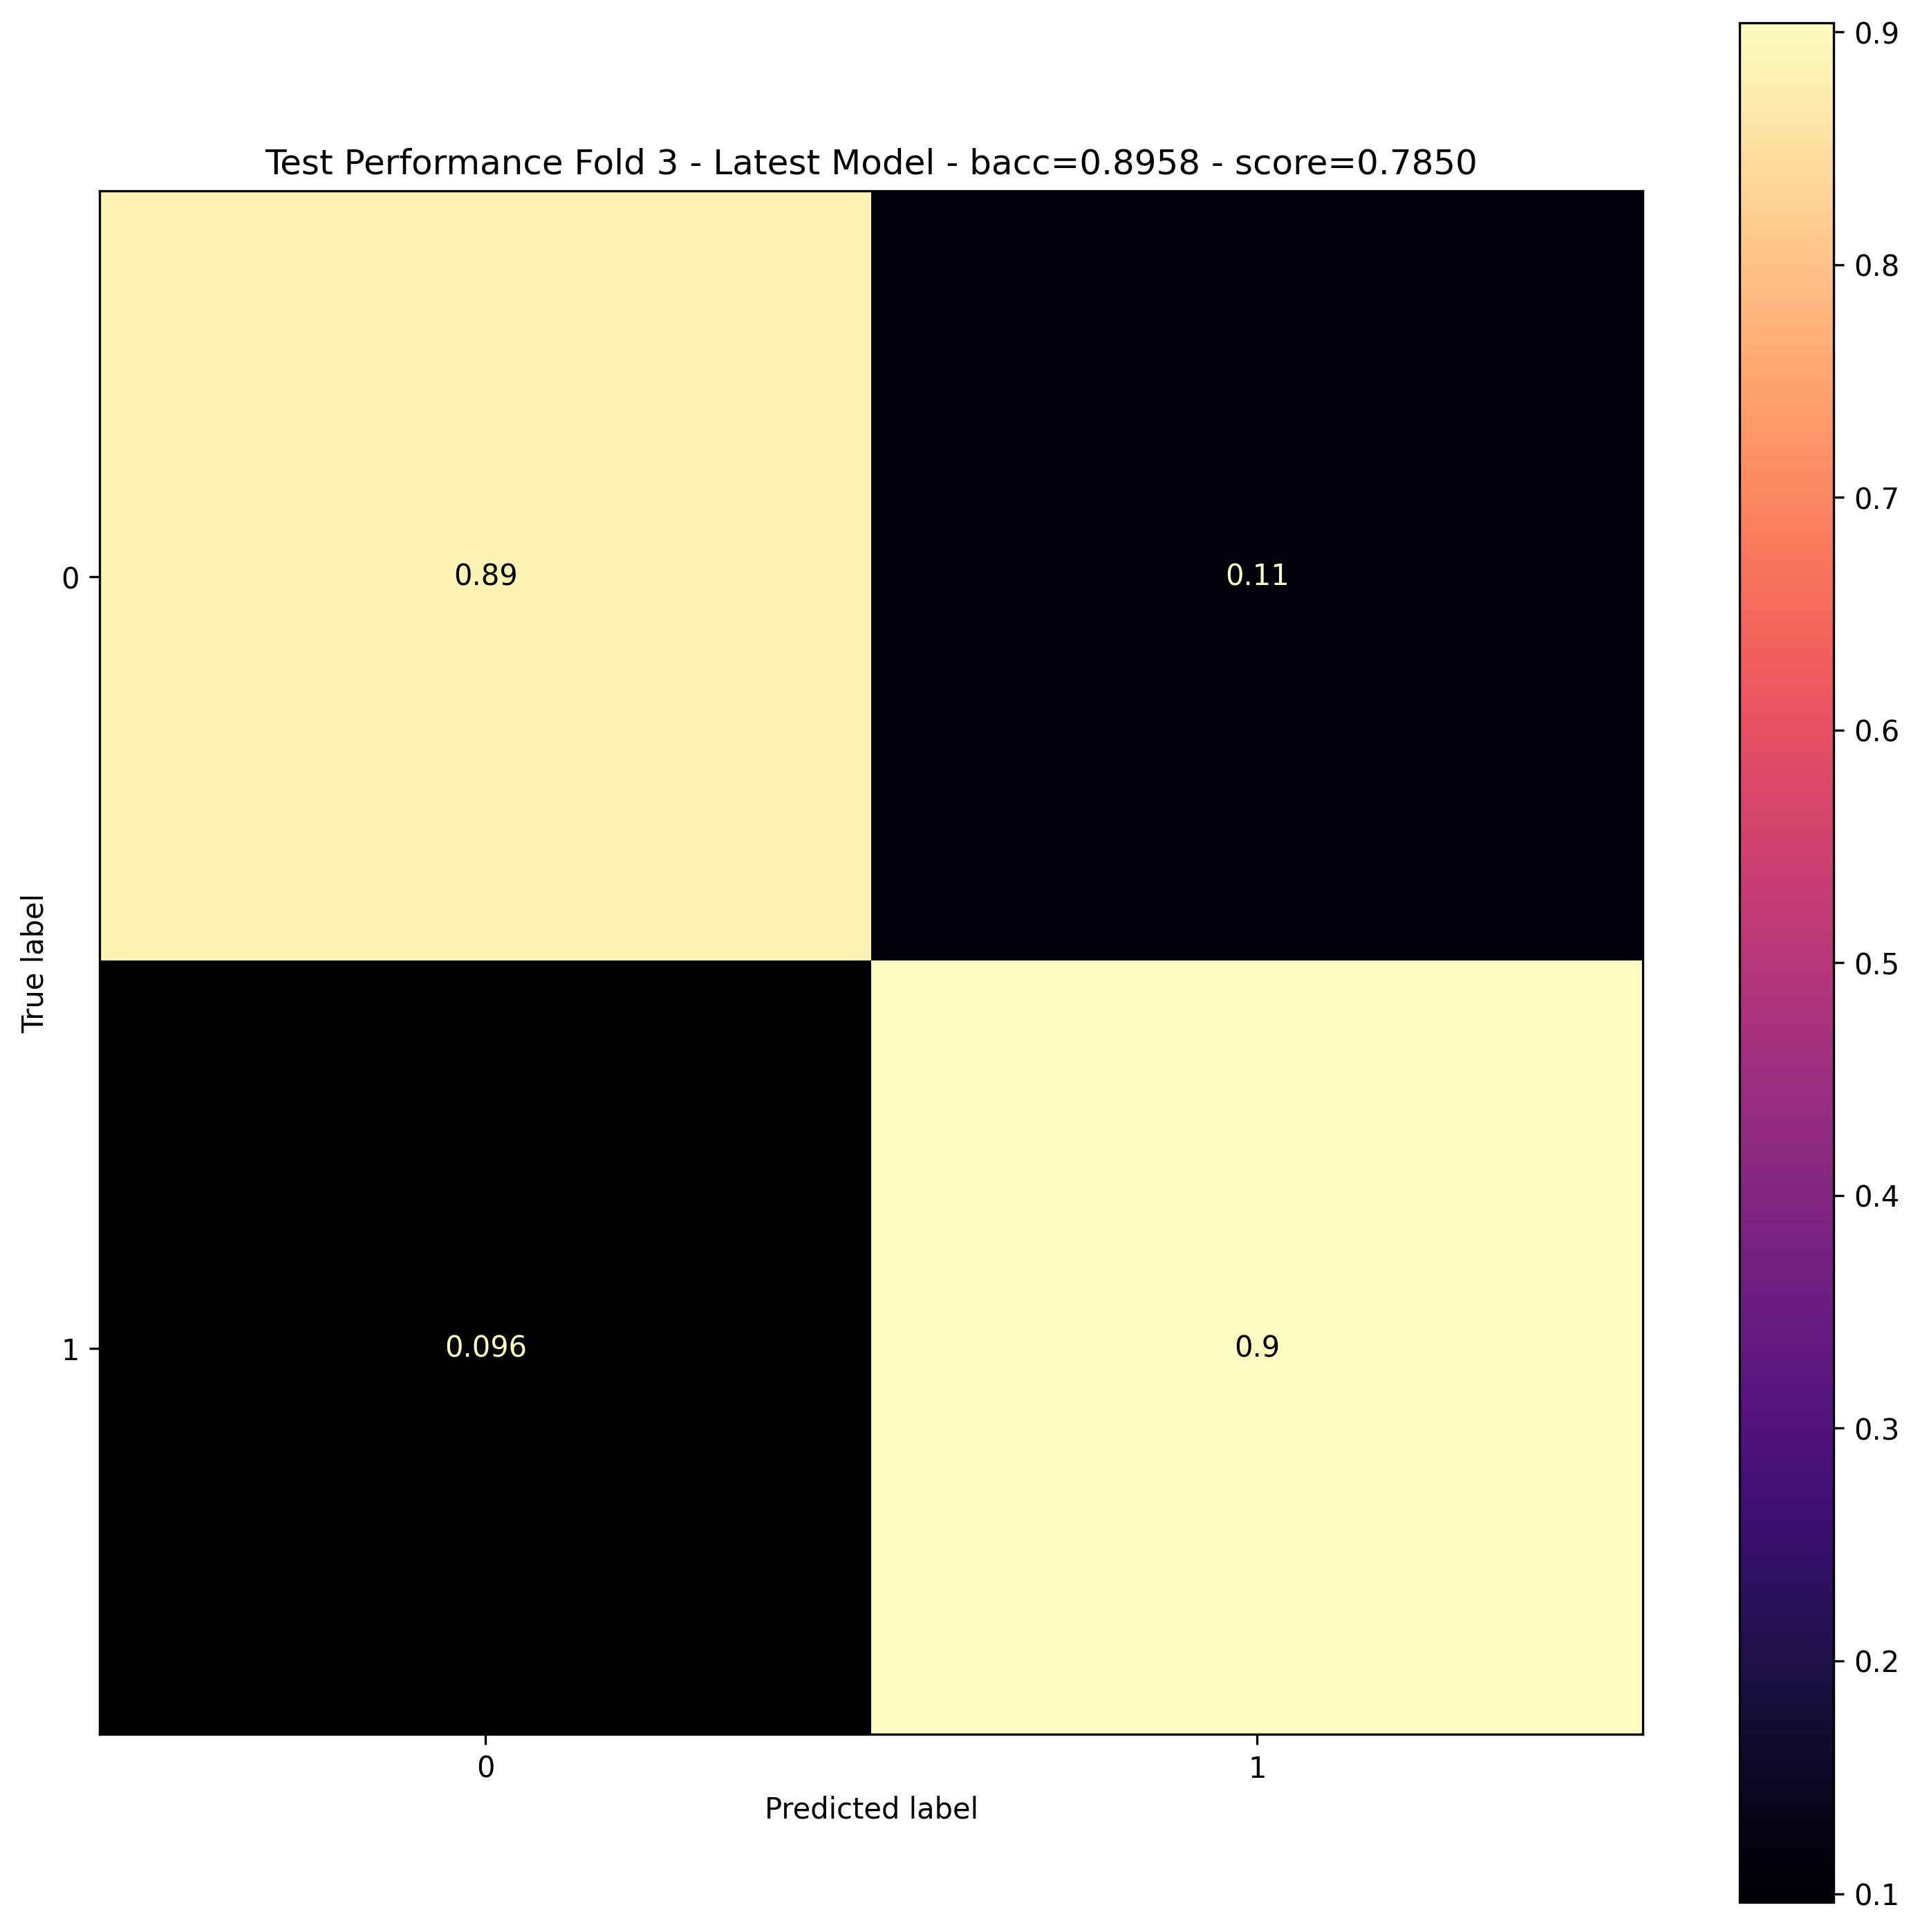

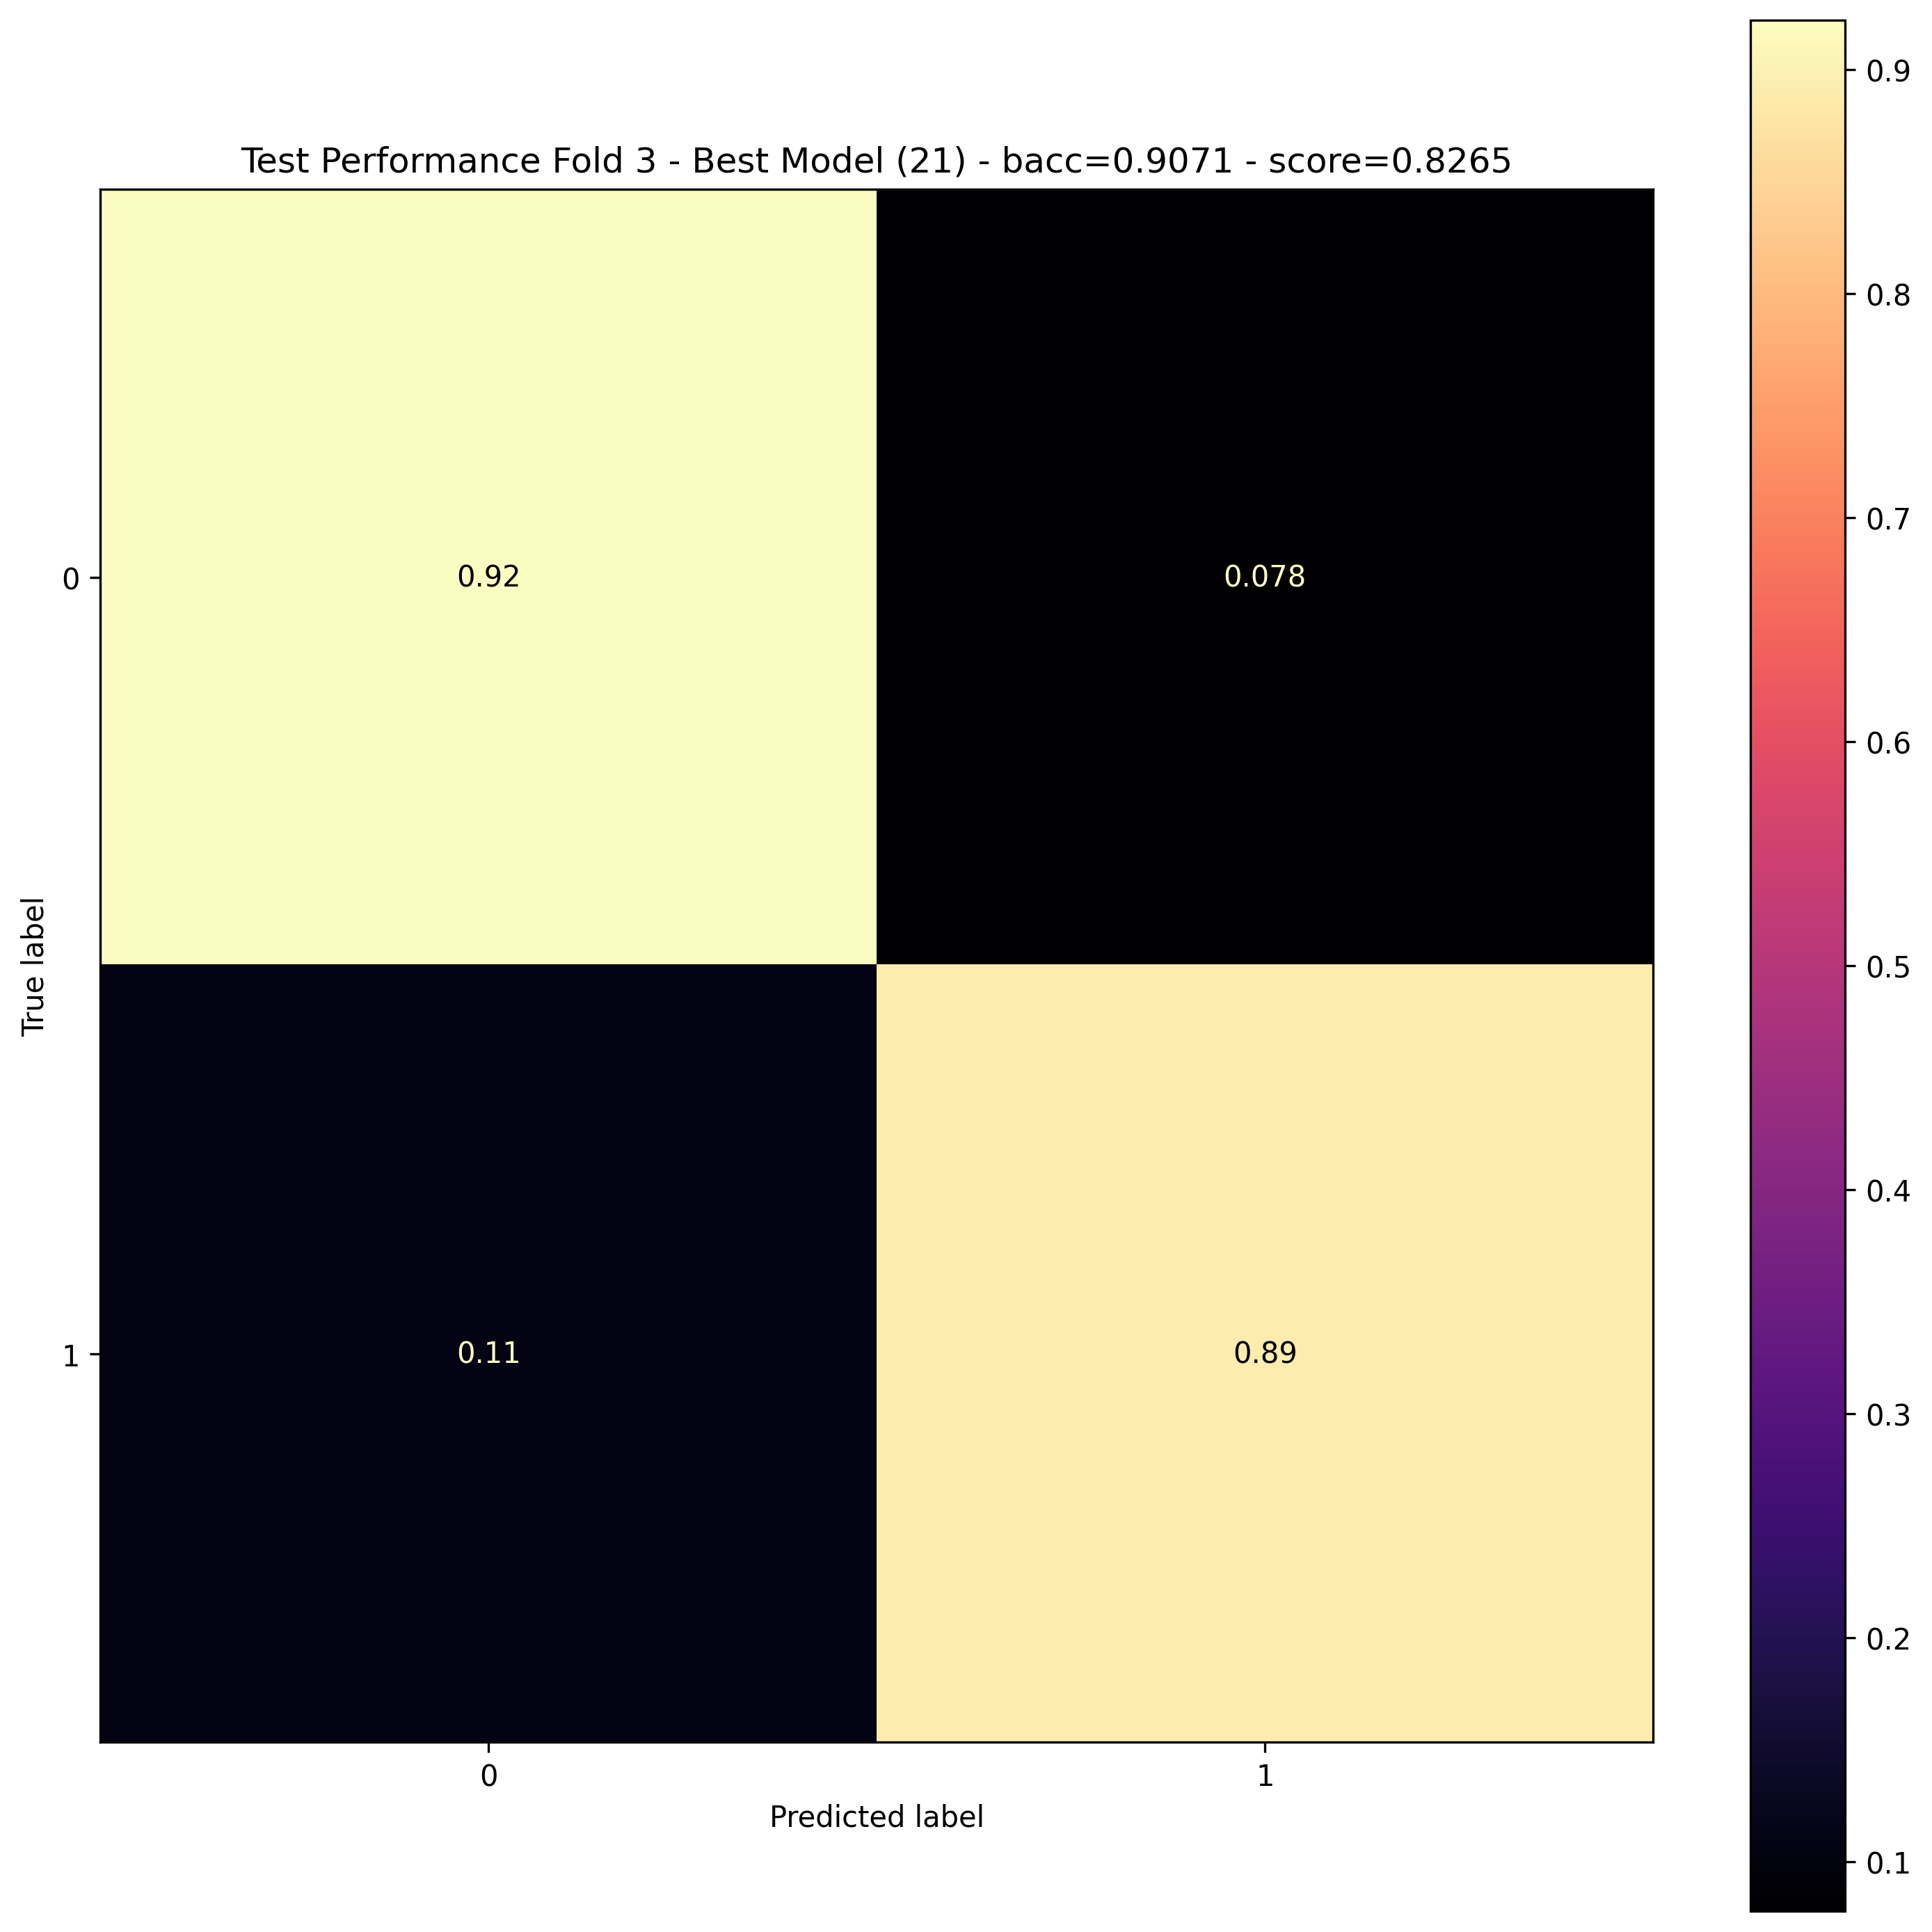

CV Folds:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 4/8 [00:46<00:46, 11.51s/it]

Best Model Test Metrics: epoch =    -1, avg_loss = 0.000040, num_samples = 12000, num_correct = 10959, acc = 0.913250, bacc = 0.907068, score = 0.826500
Saved model with scaler as "bird_no_bird_classifier cv2023-06-15_14.38 fold-3-best eval-score=0.8363 test-score=0.8265"



Executing CV for fold 4
Training fold 4


#### Training ####
##################
AttentionClassifier with 228274 parameters, in_fnn: 86848, attention_stack: 132096, out_fnn: 9330
##################

train label counts = [67383, 27117]
eval label counts  = [ 9520,  3980]

loss weights                    = [ 0.50,  2.48]
eval loss weights (theoretical) = [ 0.50,  2.39]


Training Epoch   1/25 : lr = 1.00E-02, epoch =     1, avg_loss = 0.000073, num_samples = 94500, num_correct = 27154, acc = 0.287344, bacc = 0.500043, score = -0.425312
Evaluation Epoch   1/25 : epoch =     1, avg_loss = 0.000123, num_samples = 13500, num_correct =  3980, acc = 0.294815, bacc = 0.500000, score = -0.410370
Training Epoch   2/25 : lr = 1

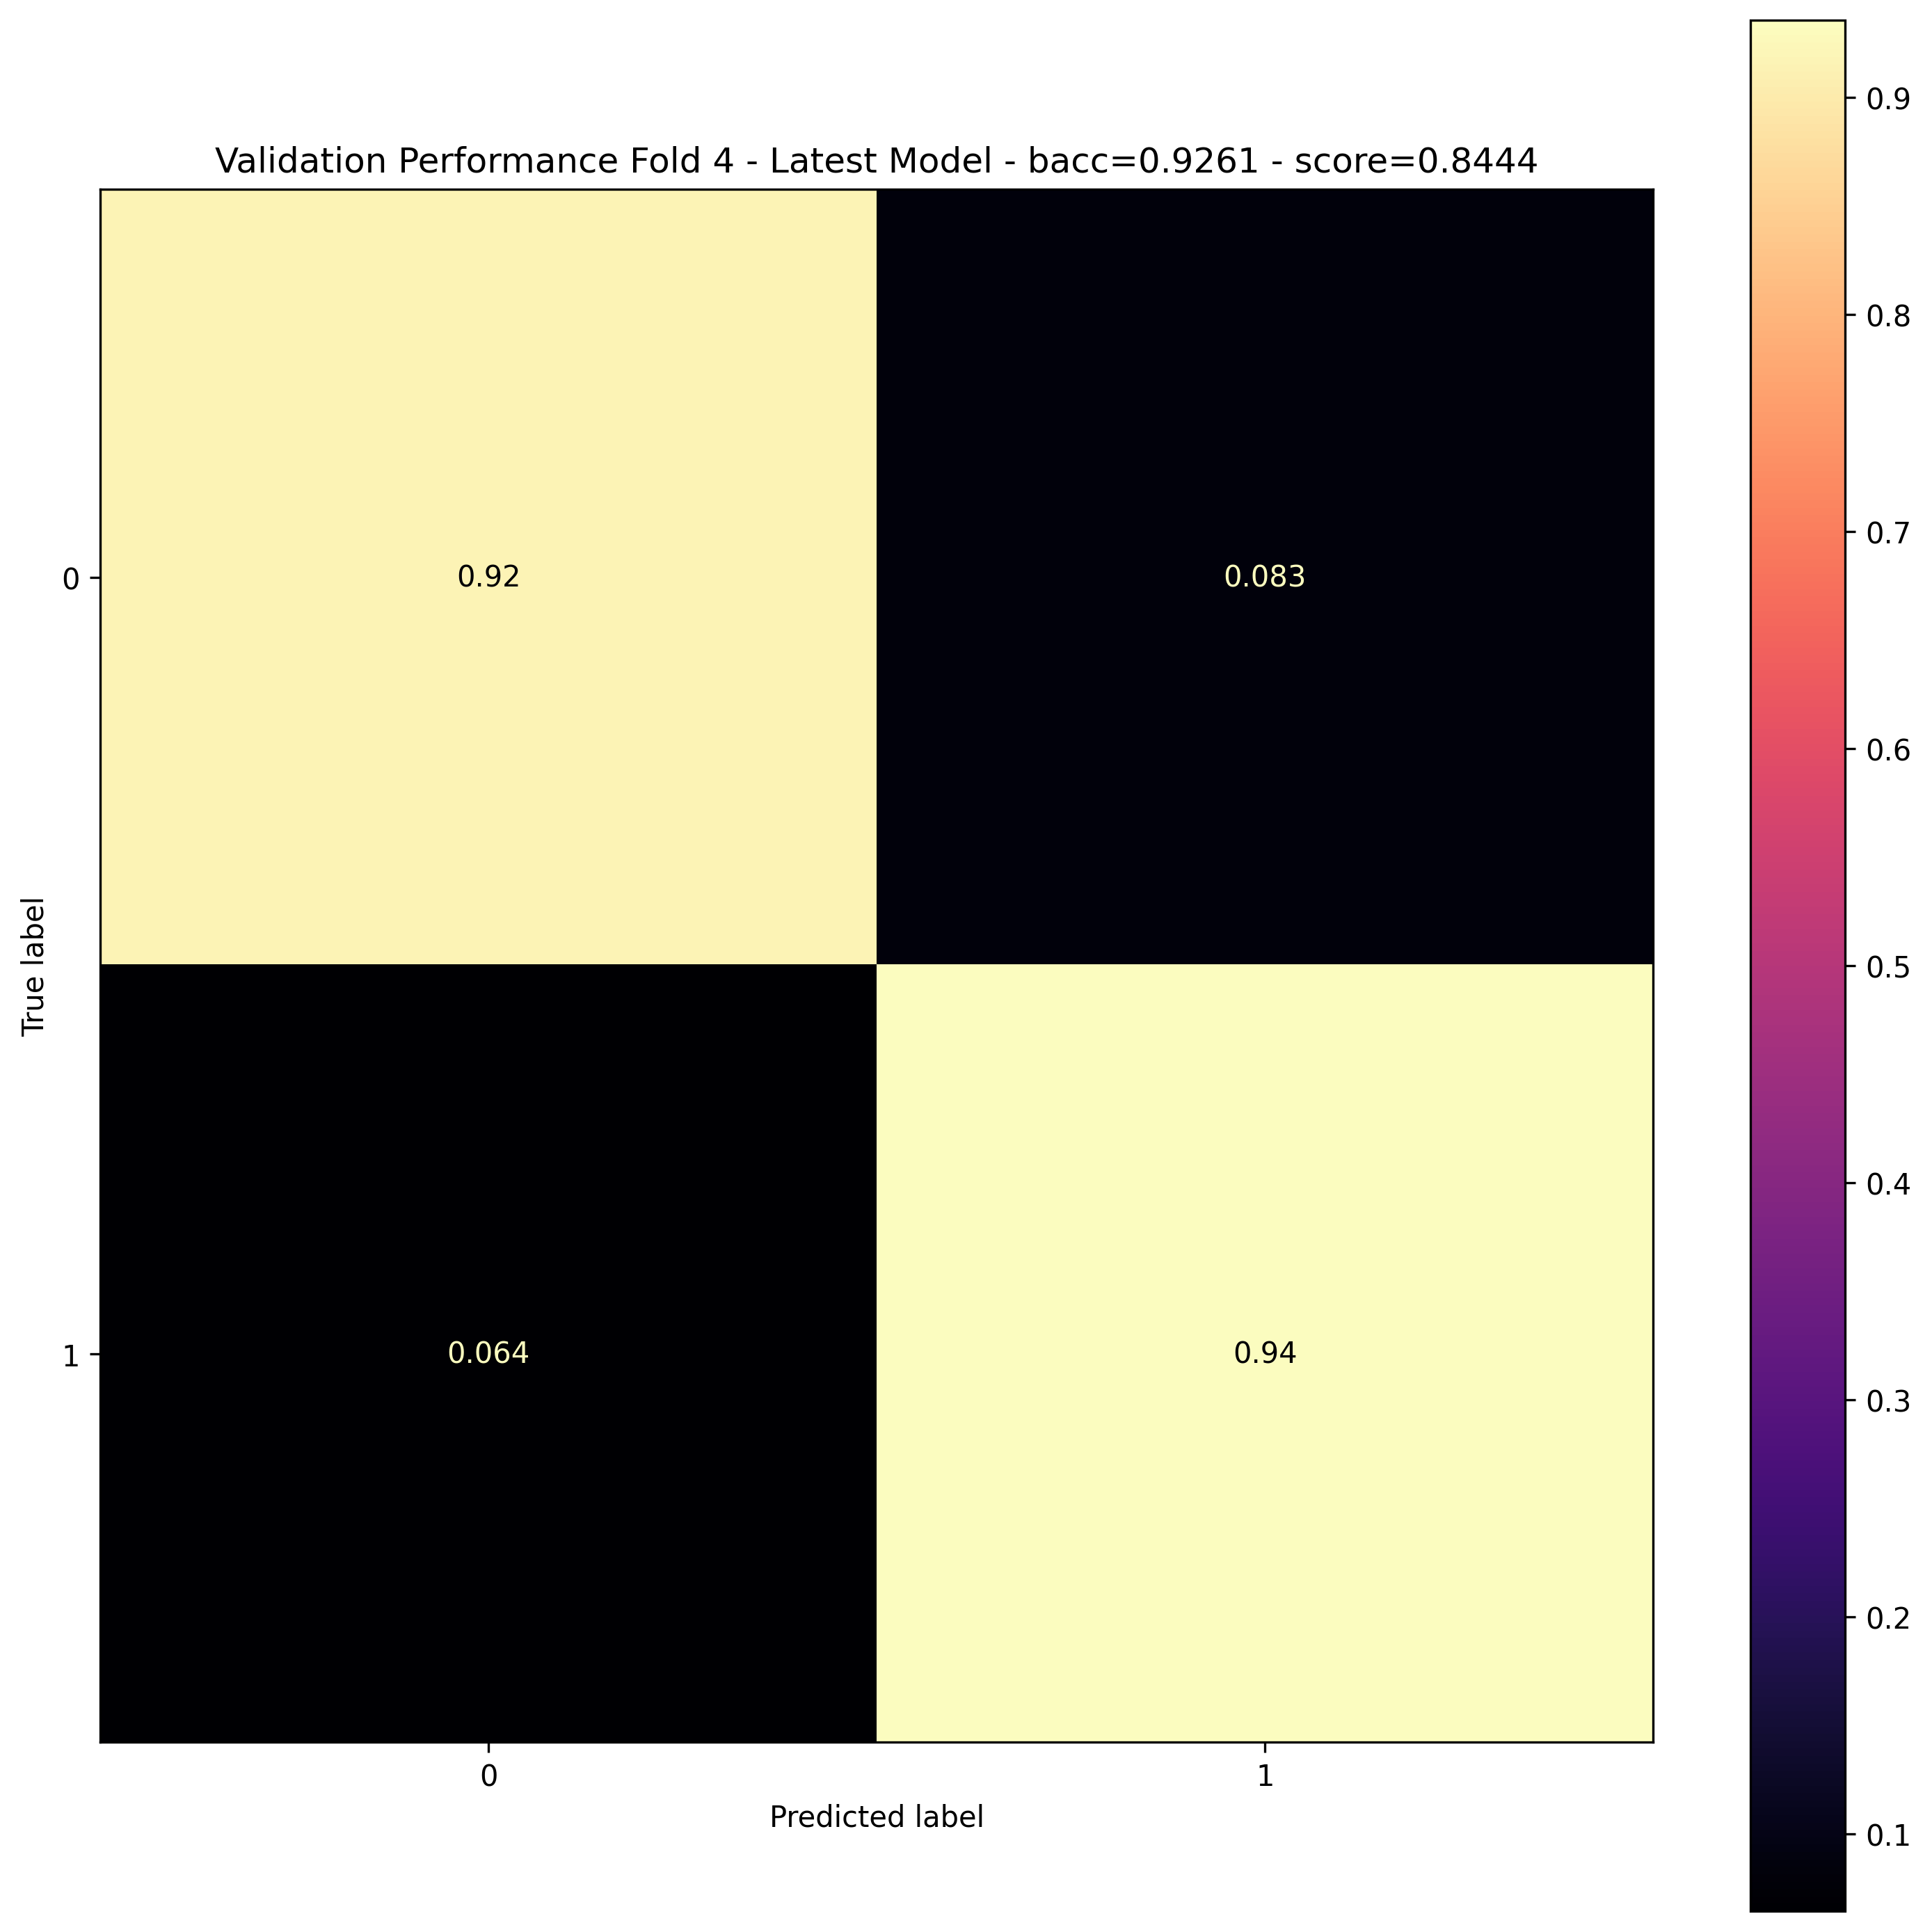

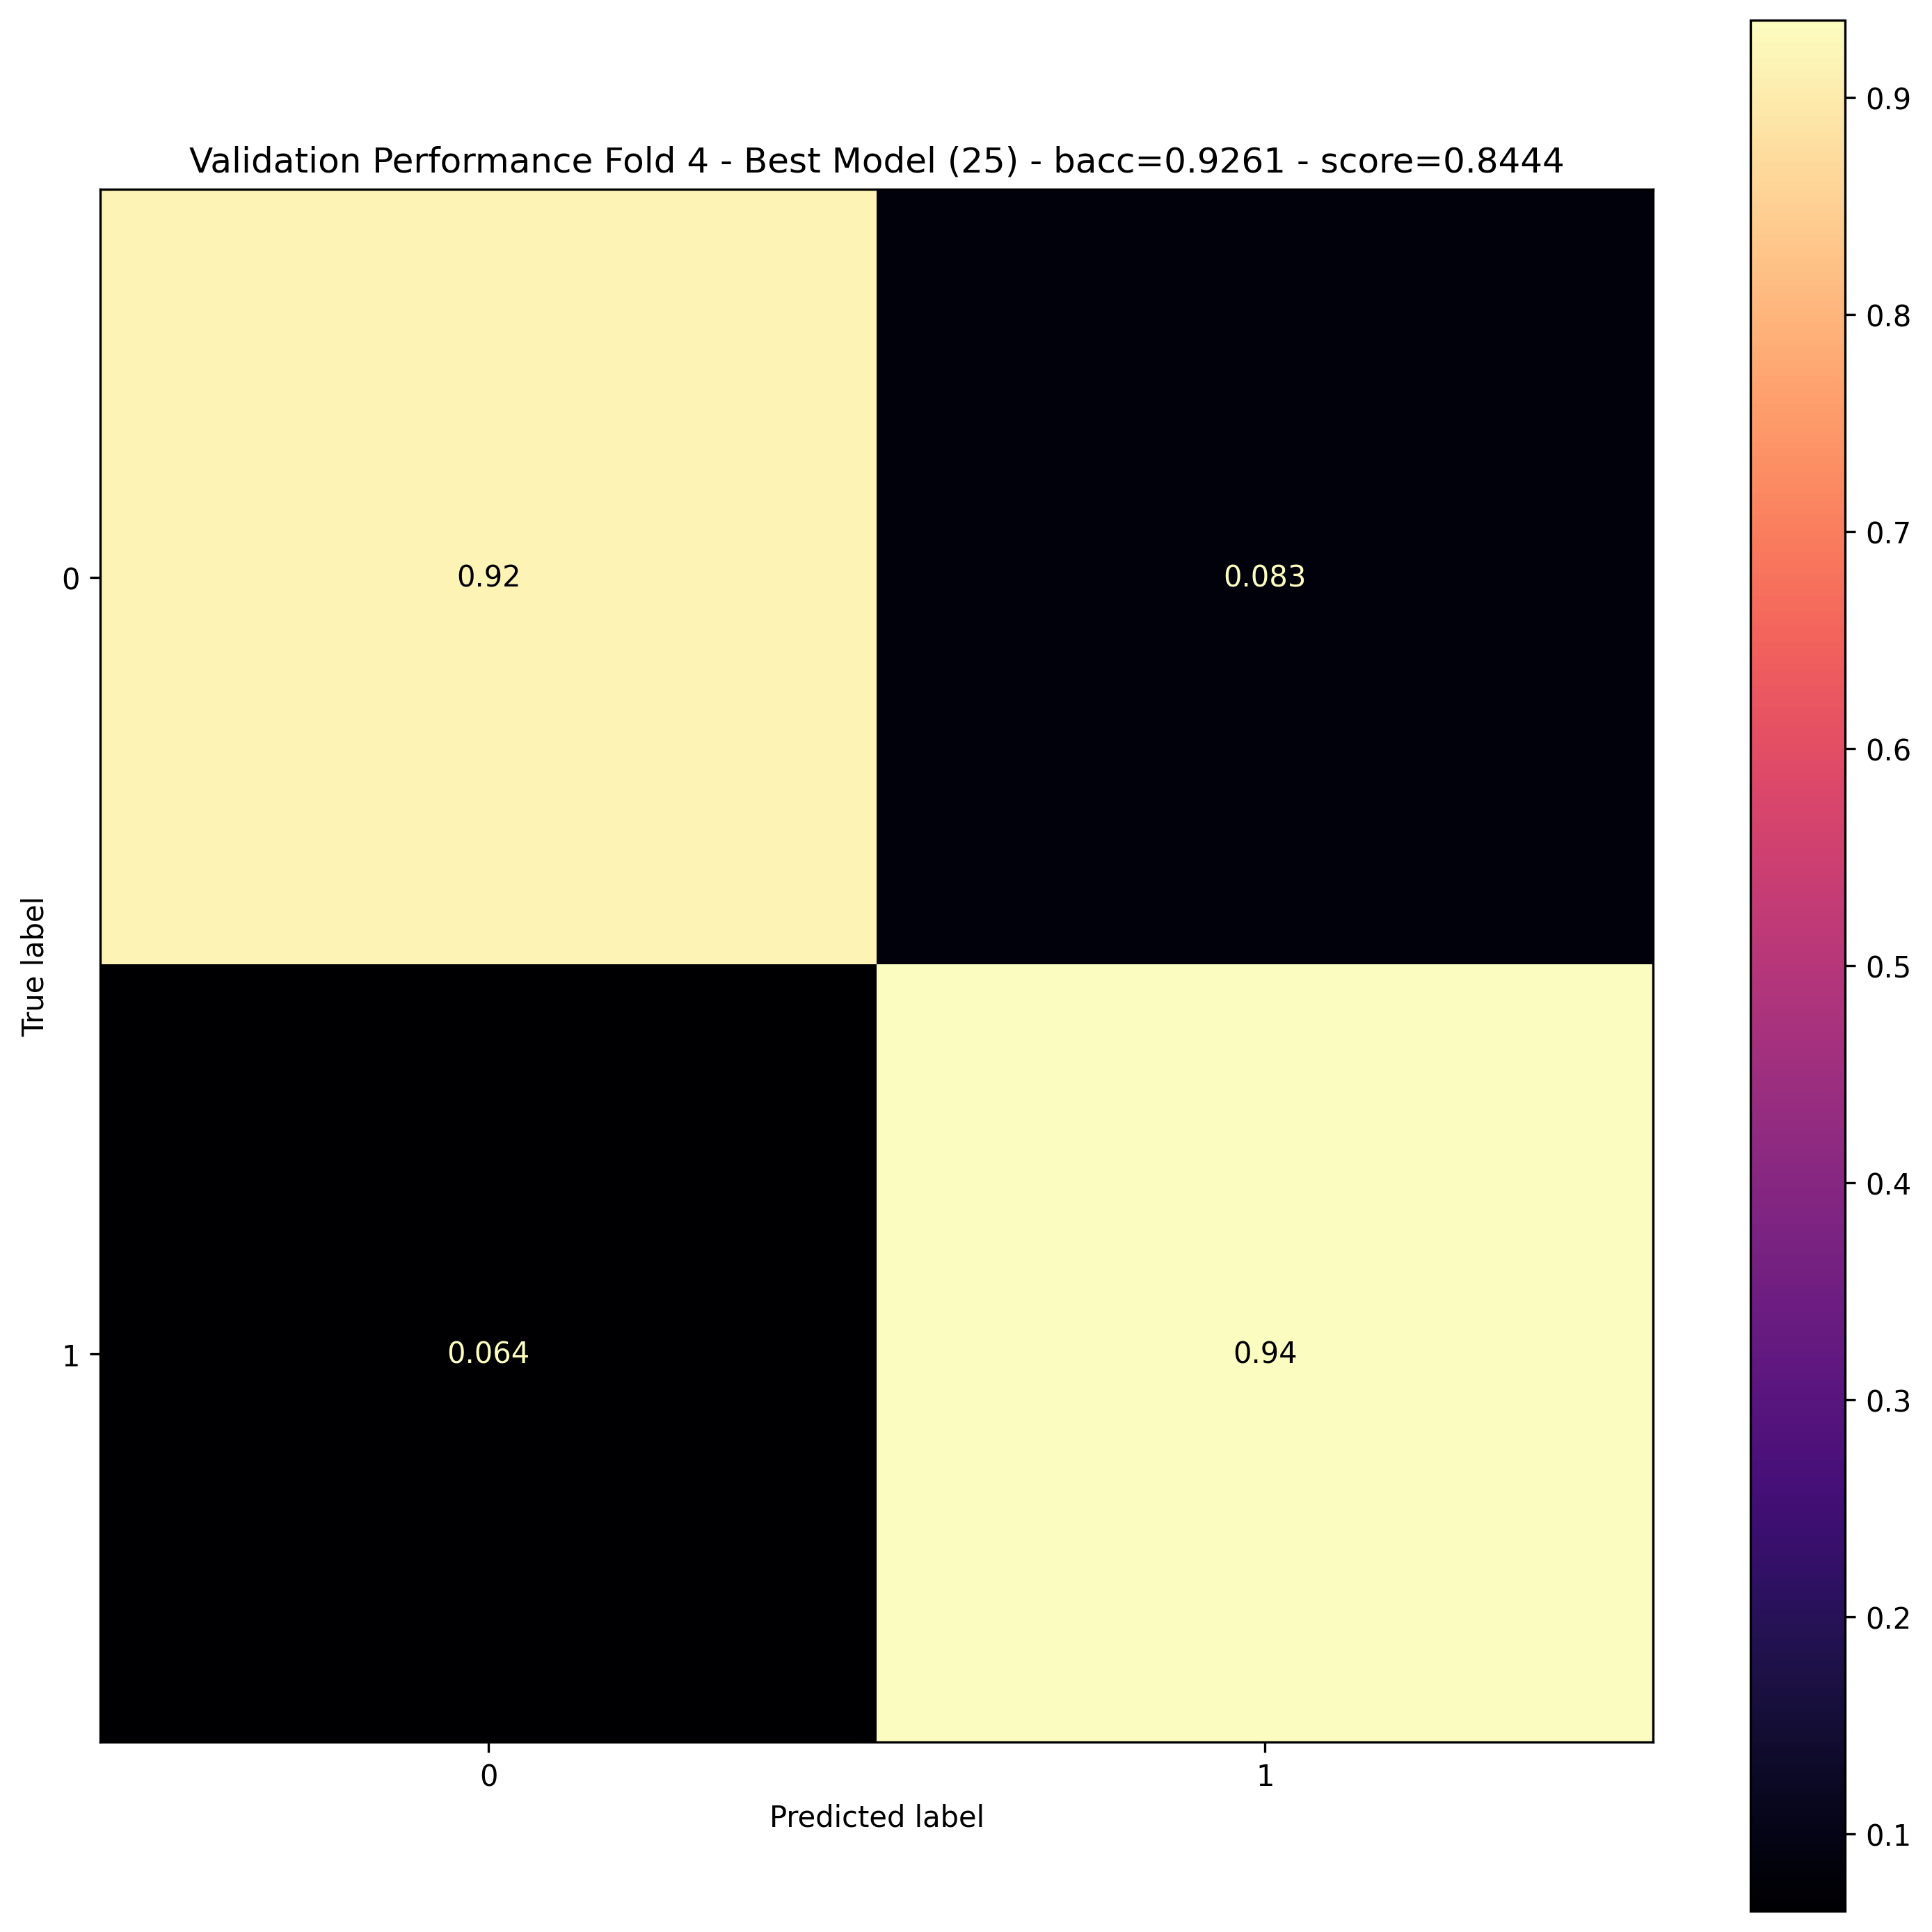


Testing fold 4


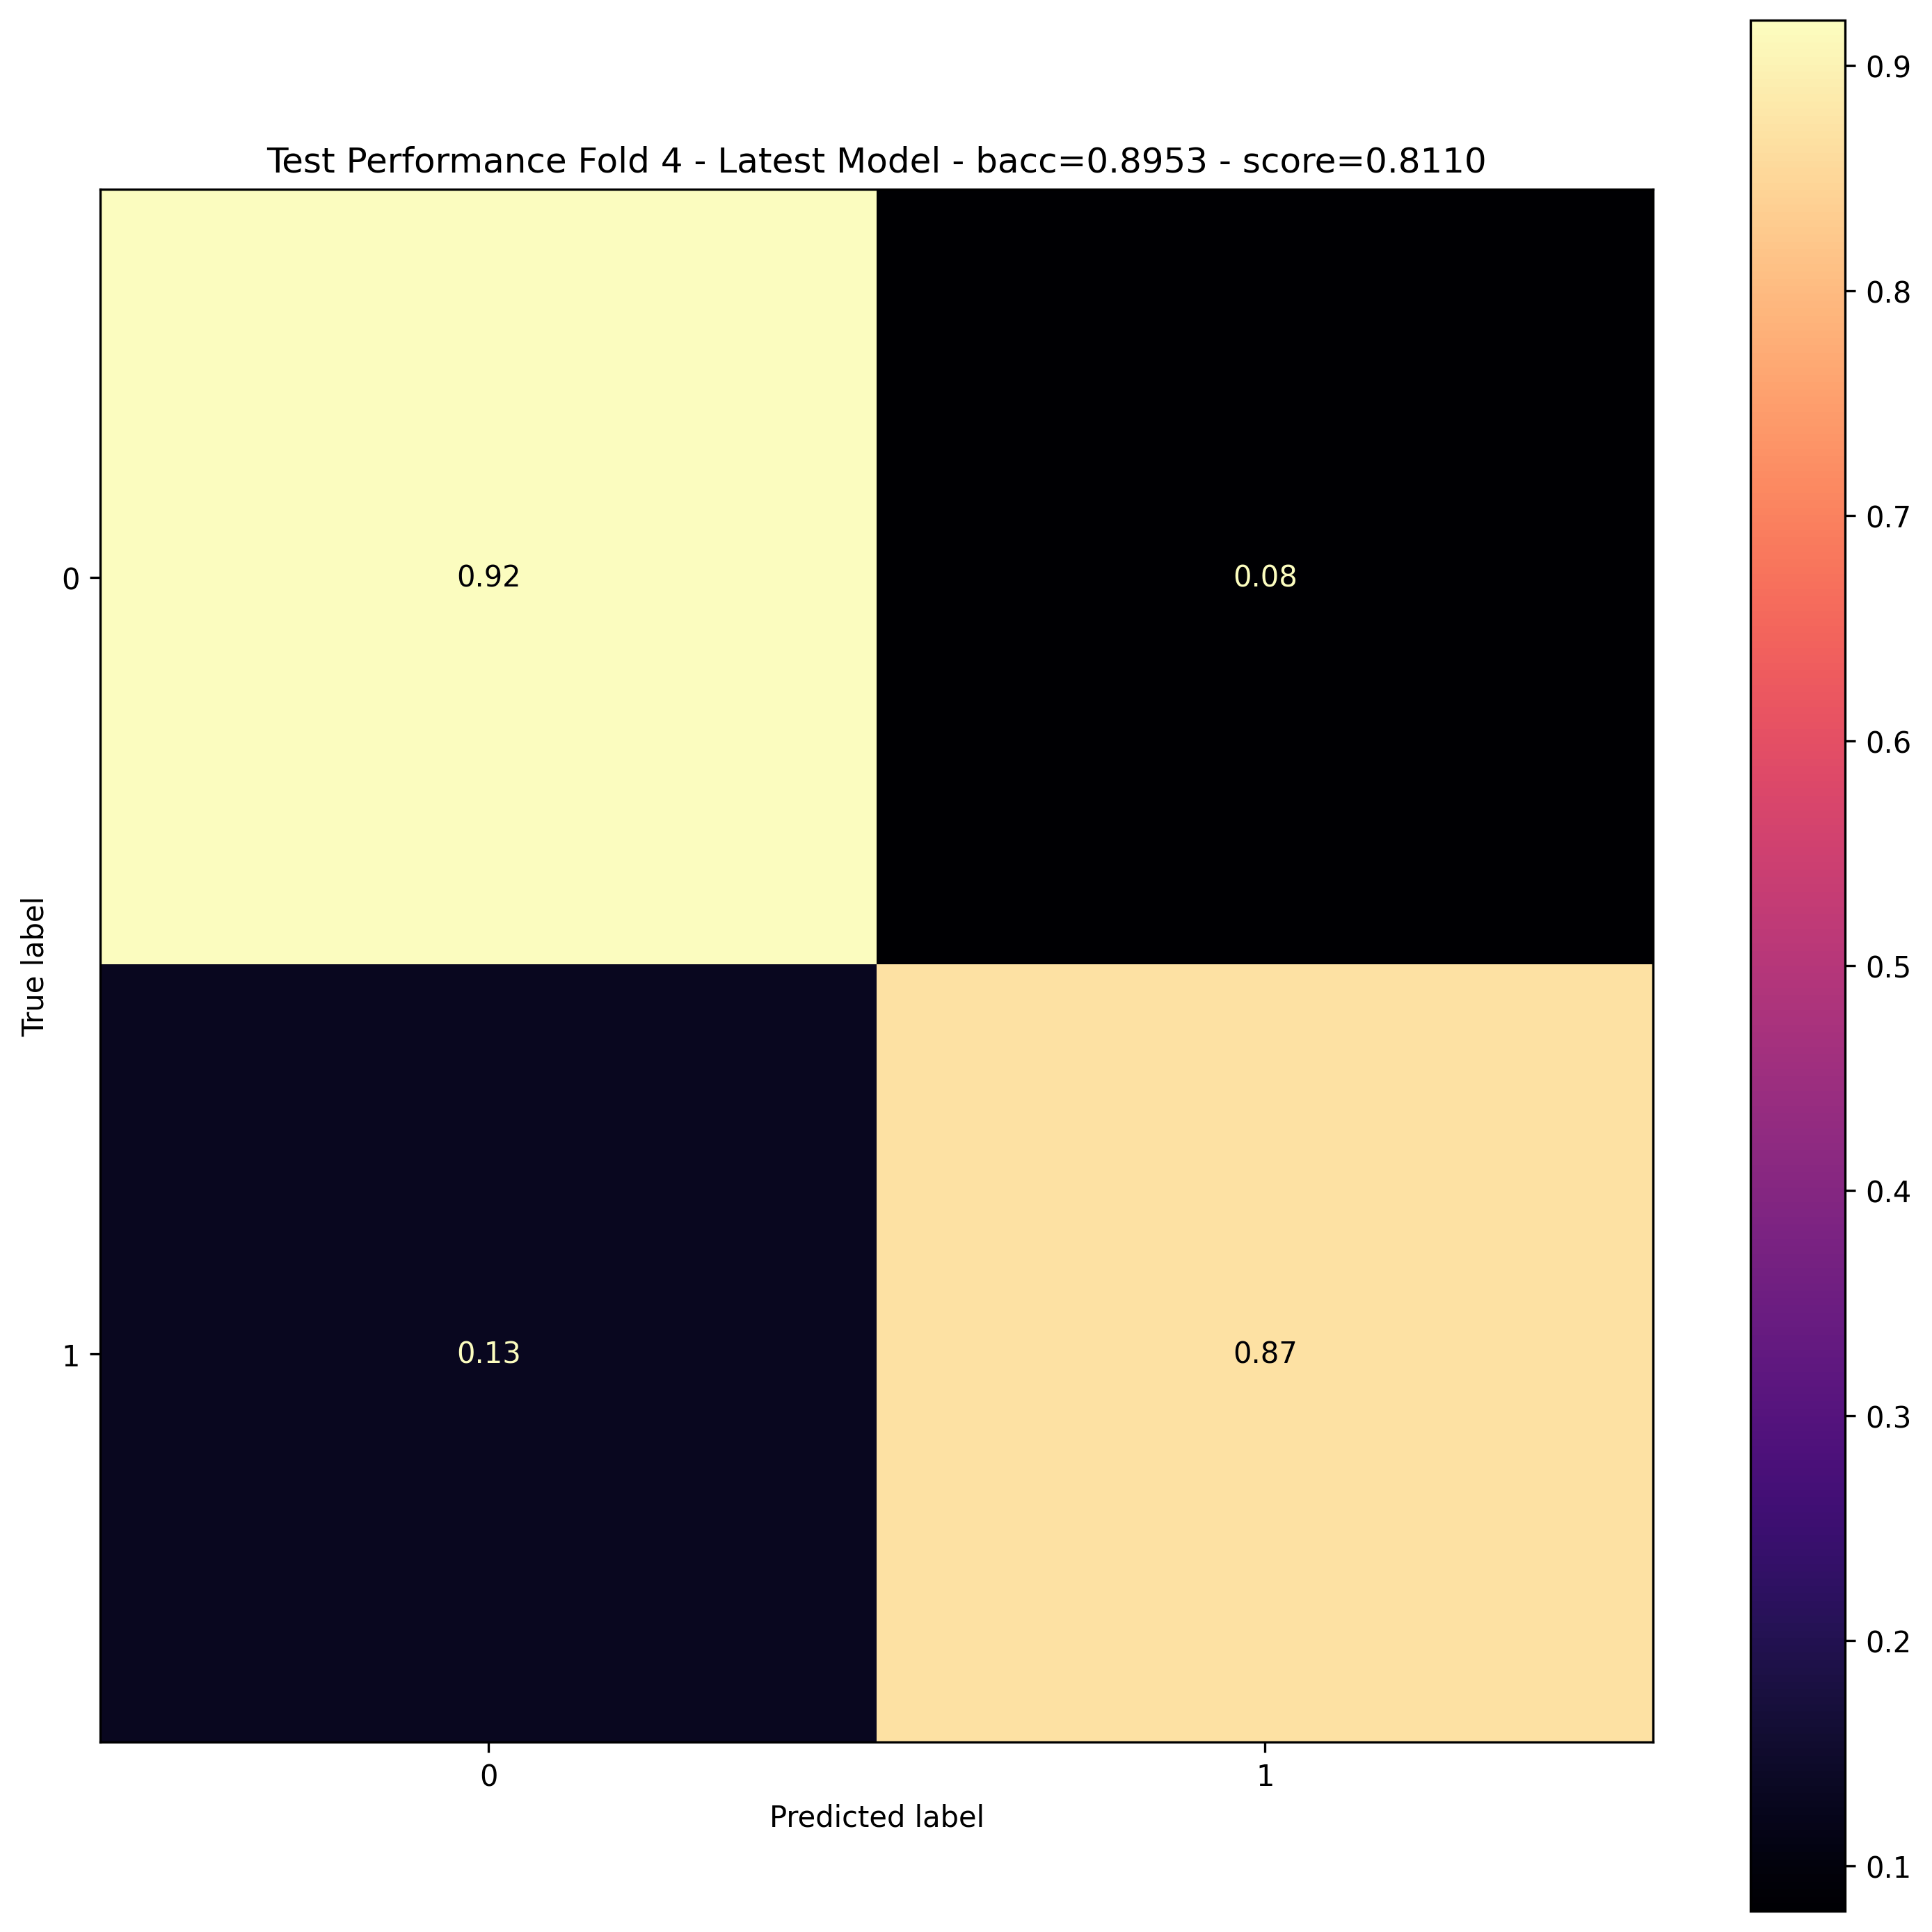

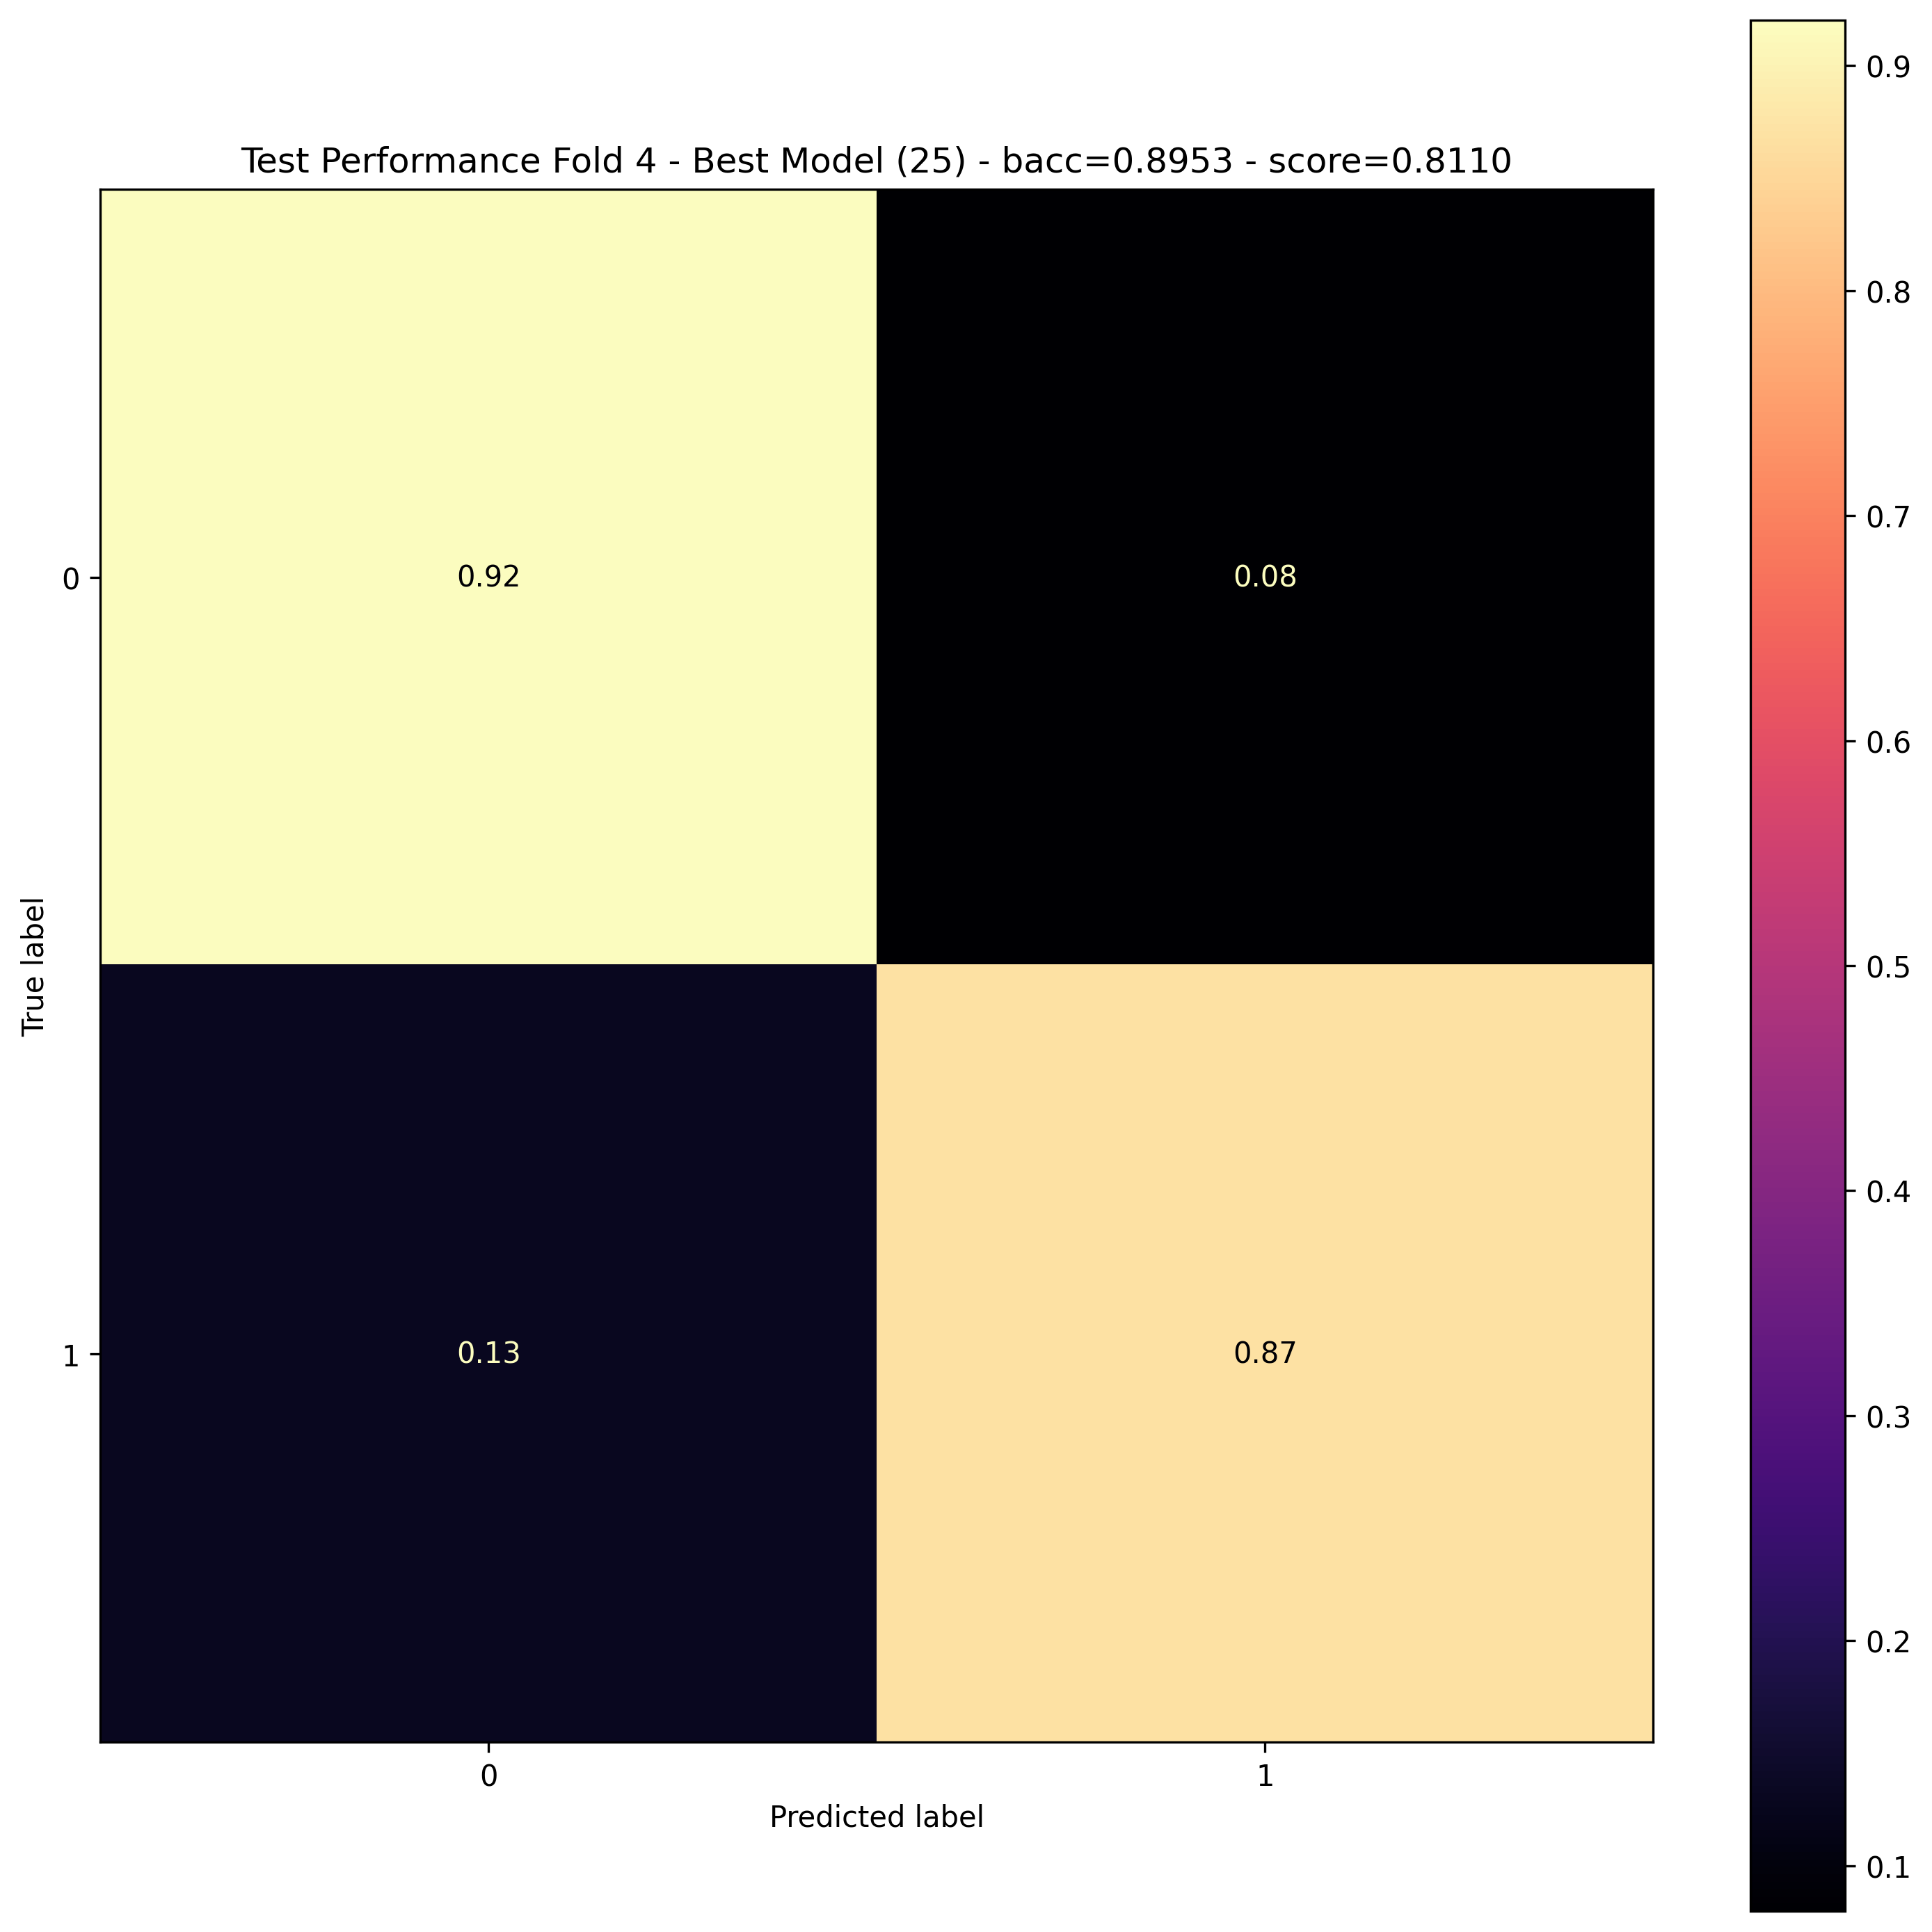

CV Folds:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 5/8 [00:57<00:34, 11.57s/it]

Best Model Test Metrics: epoch =    -1, avg_loss = 0.000048, num_samples = 12000, num_correct = 10866, acc = 0.905500, bacc = 0.895344, score = 0.811000
Saved model with scaler as "bird_no_bird_classifier cv2023-06-15_14.38 fold-4-best eval-score=0.8444 test-score=0.8110"



Executing CV for fold 5
Training fold 5


#### Training ####
##################
AttentionClassifier with 228274 parameters, in_fnn: 86848, attention_stack: 132096, out_fnn: 9330
##################

train label counts = [67350, 27150]
eval label counts  = [ 9553,  3947]

loss weights                    = [ 0.50,  2.48]
eval loss weights (theoretical) = [ 0.50,  2.42]


Training Epoch   1/25 : lr = 1.00E-02, epoch =     1, avg_loss = 0.000121, num_samples = 94500, num_correct = 34119, acc = 0.361048, bacc = 0.499282, score = -0.277905
Evaluation Epoch   1/25 : epoch =     1, avg_loss = 0.000114, num_samples = 13500, num_correct =  3947, acc = 0.292370, bacc = 0.500000, score = -0.415259
Training Epoch   2/25 : lr = 1

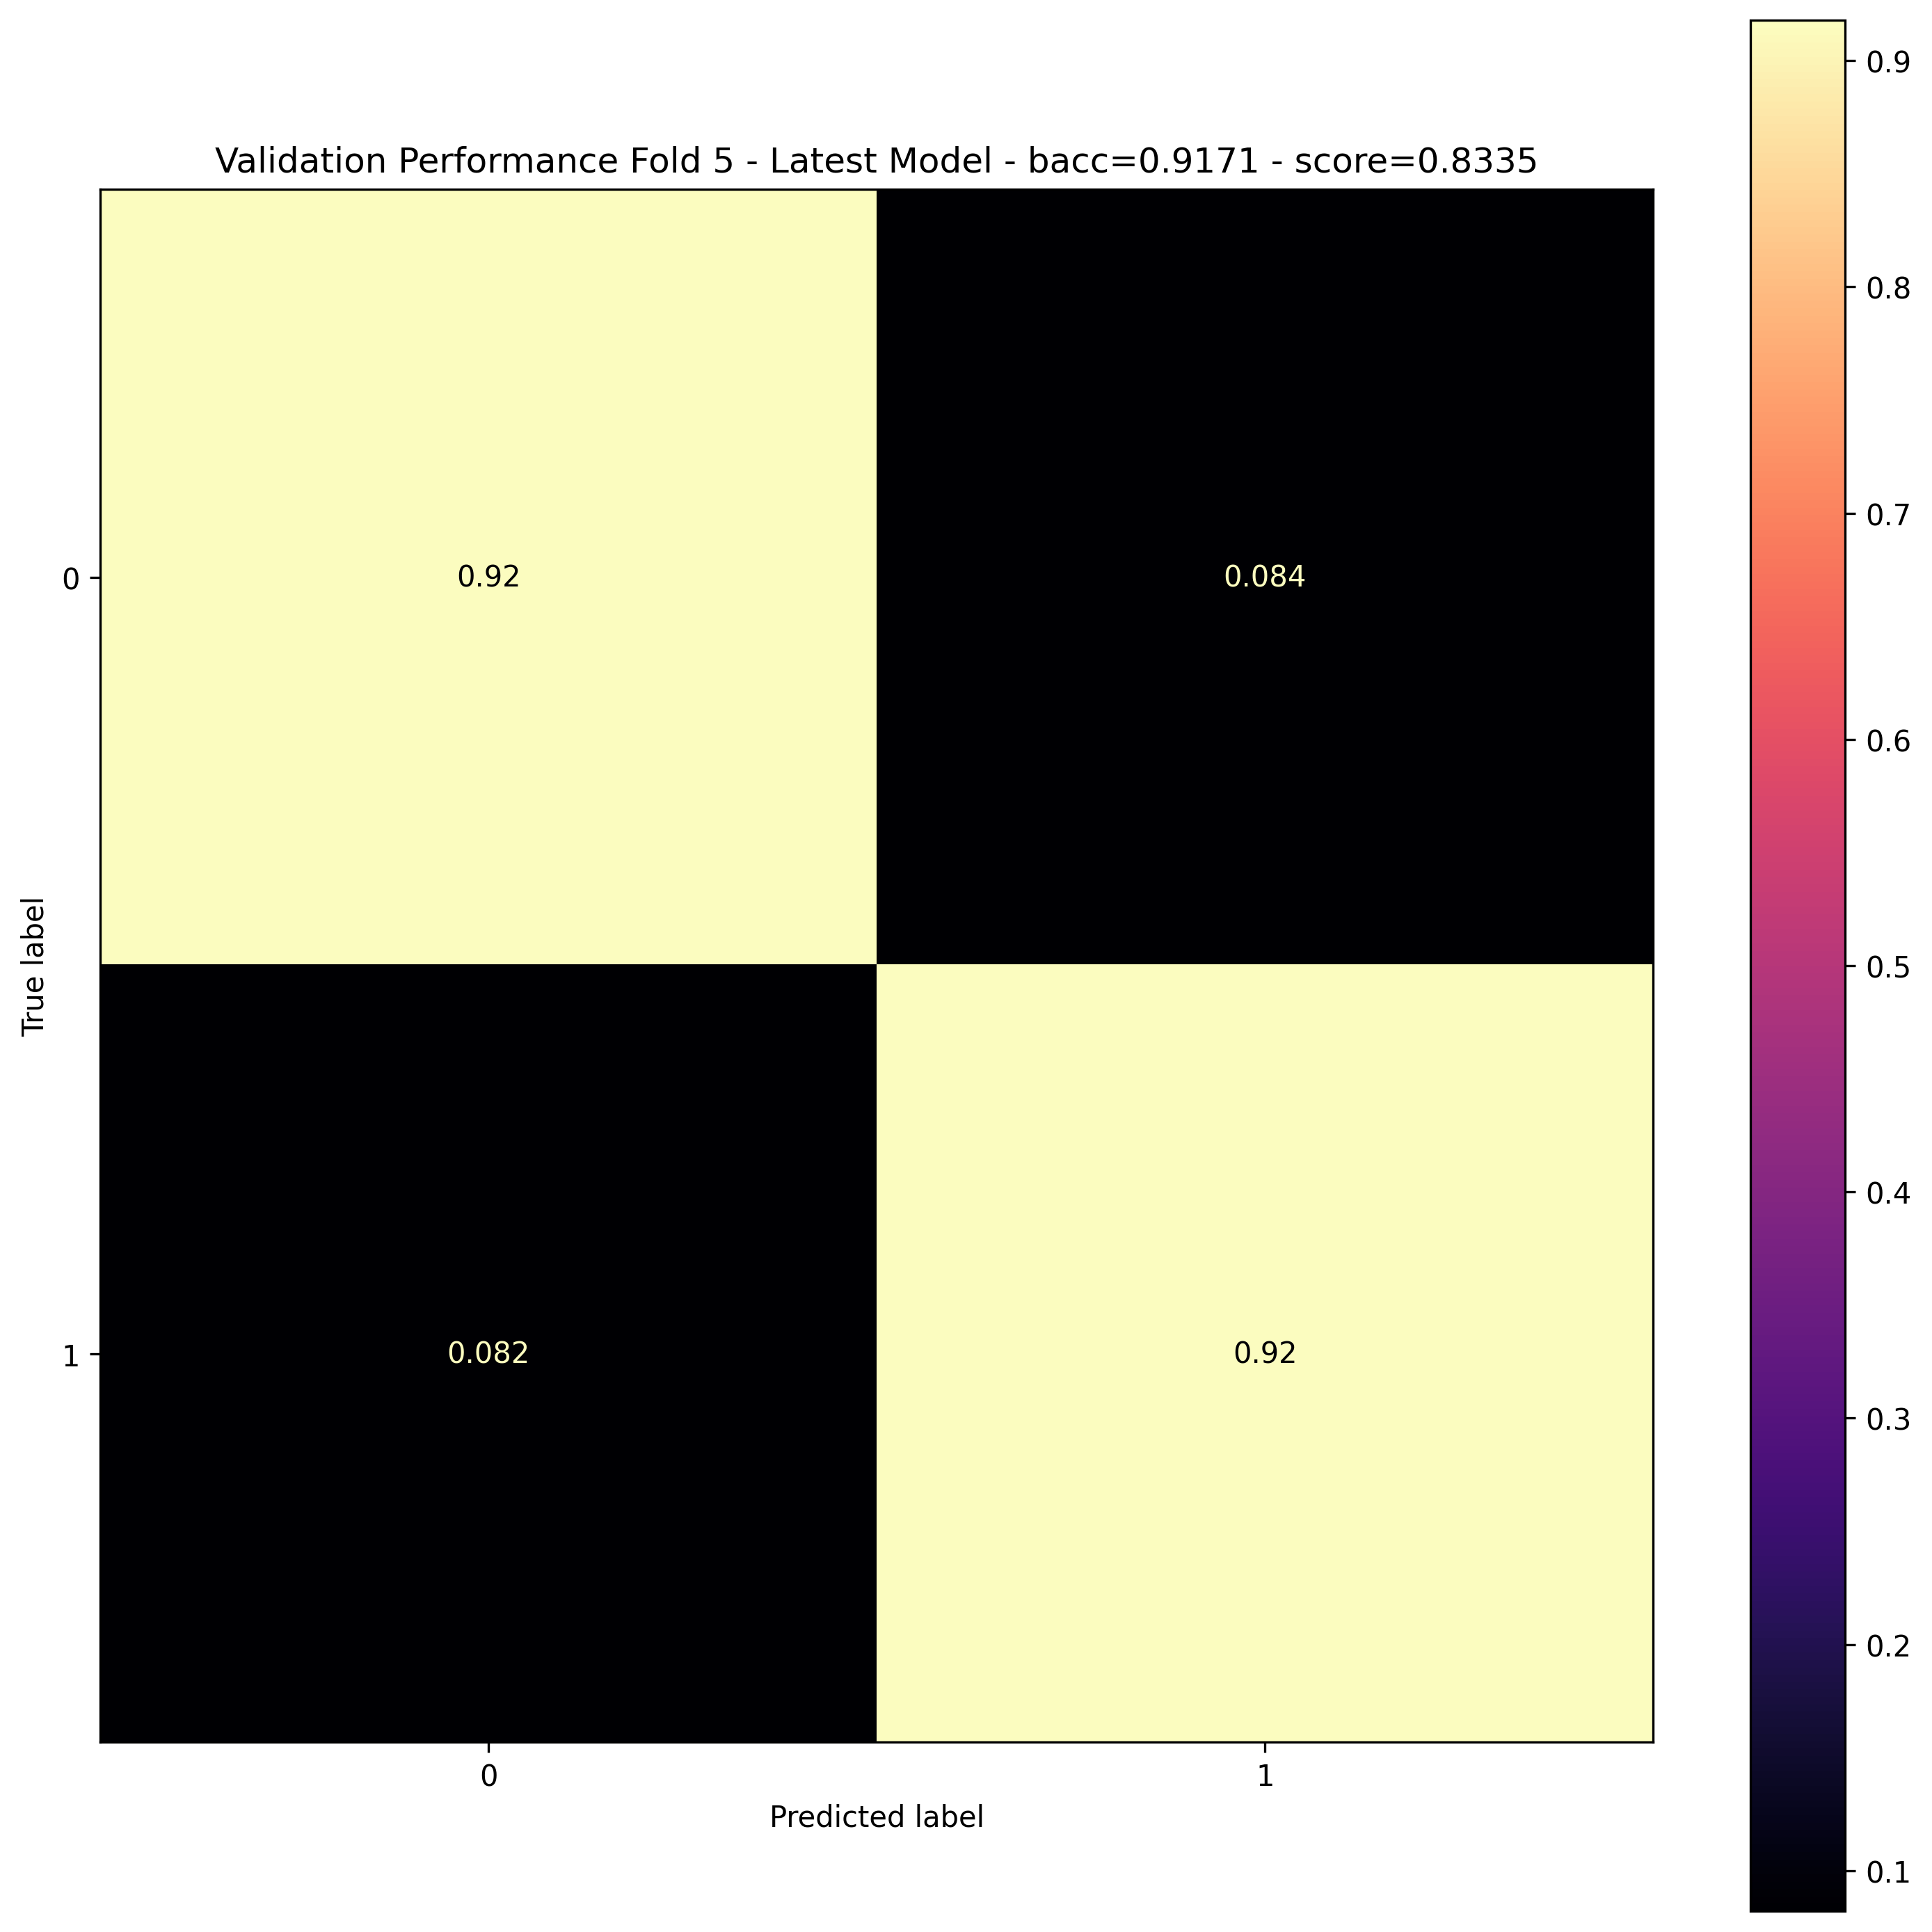

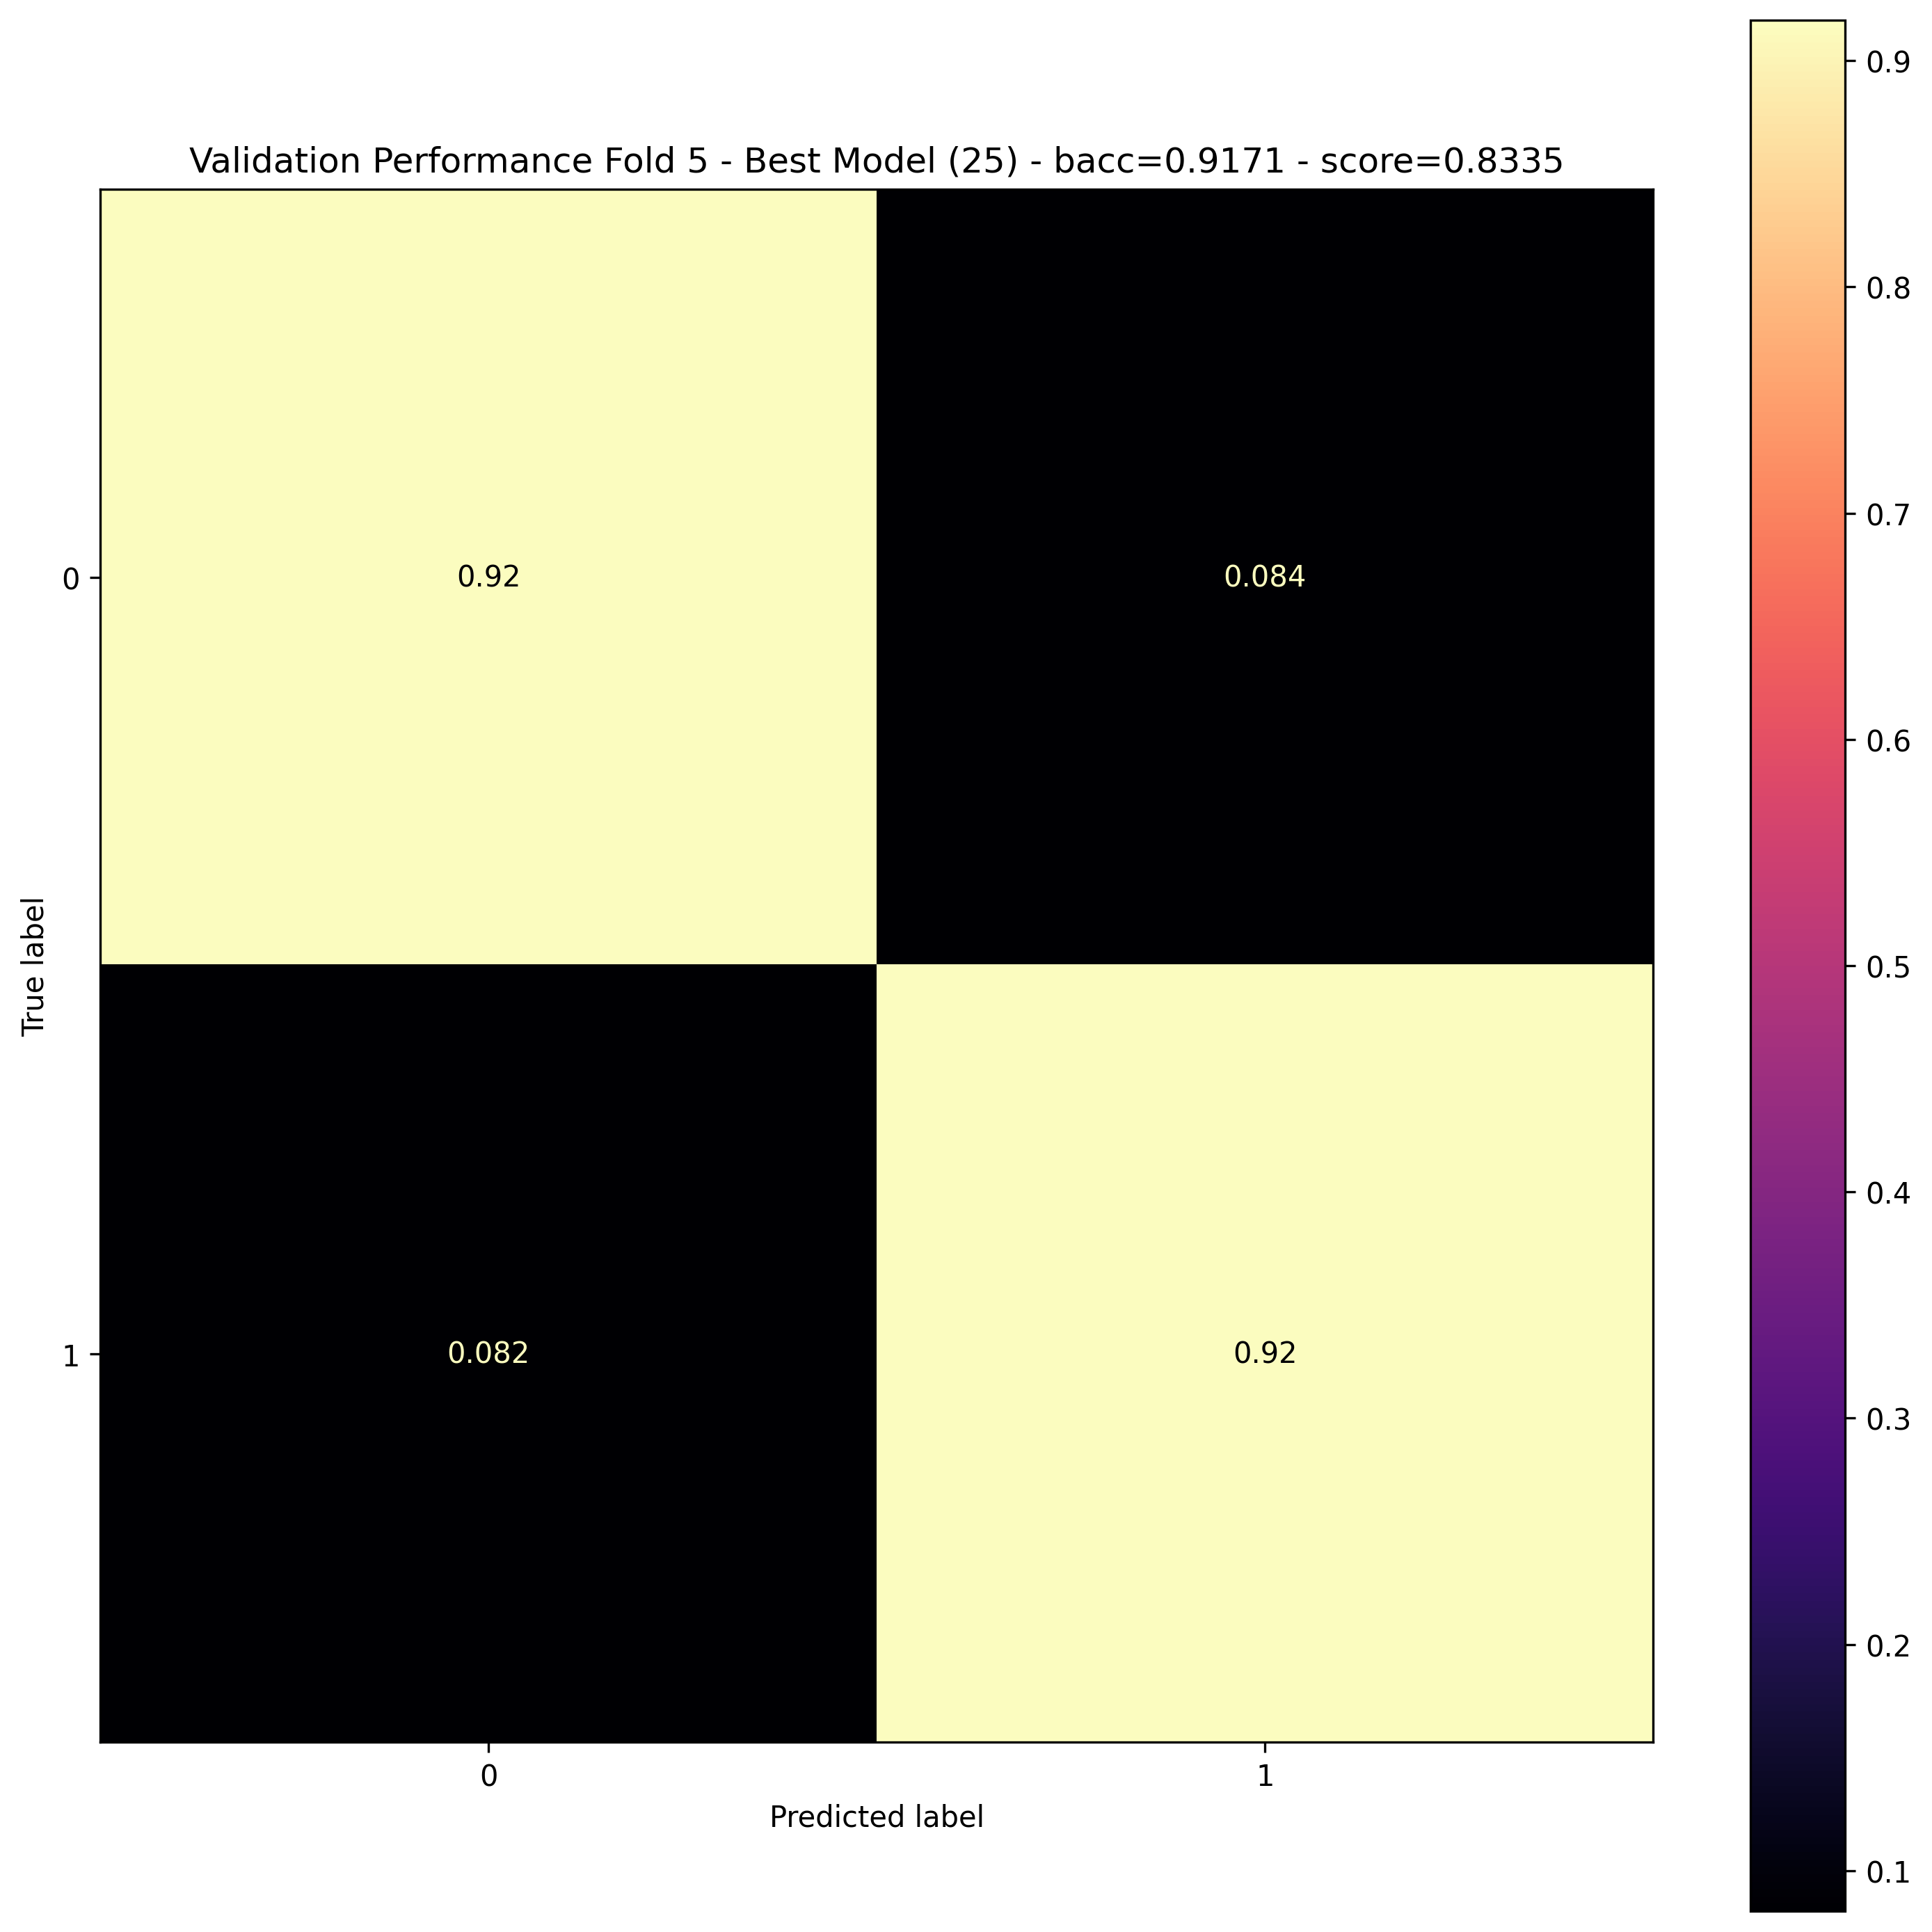


Testing fold 5


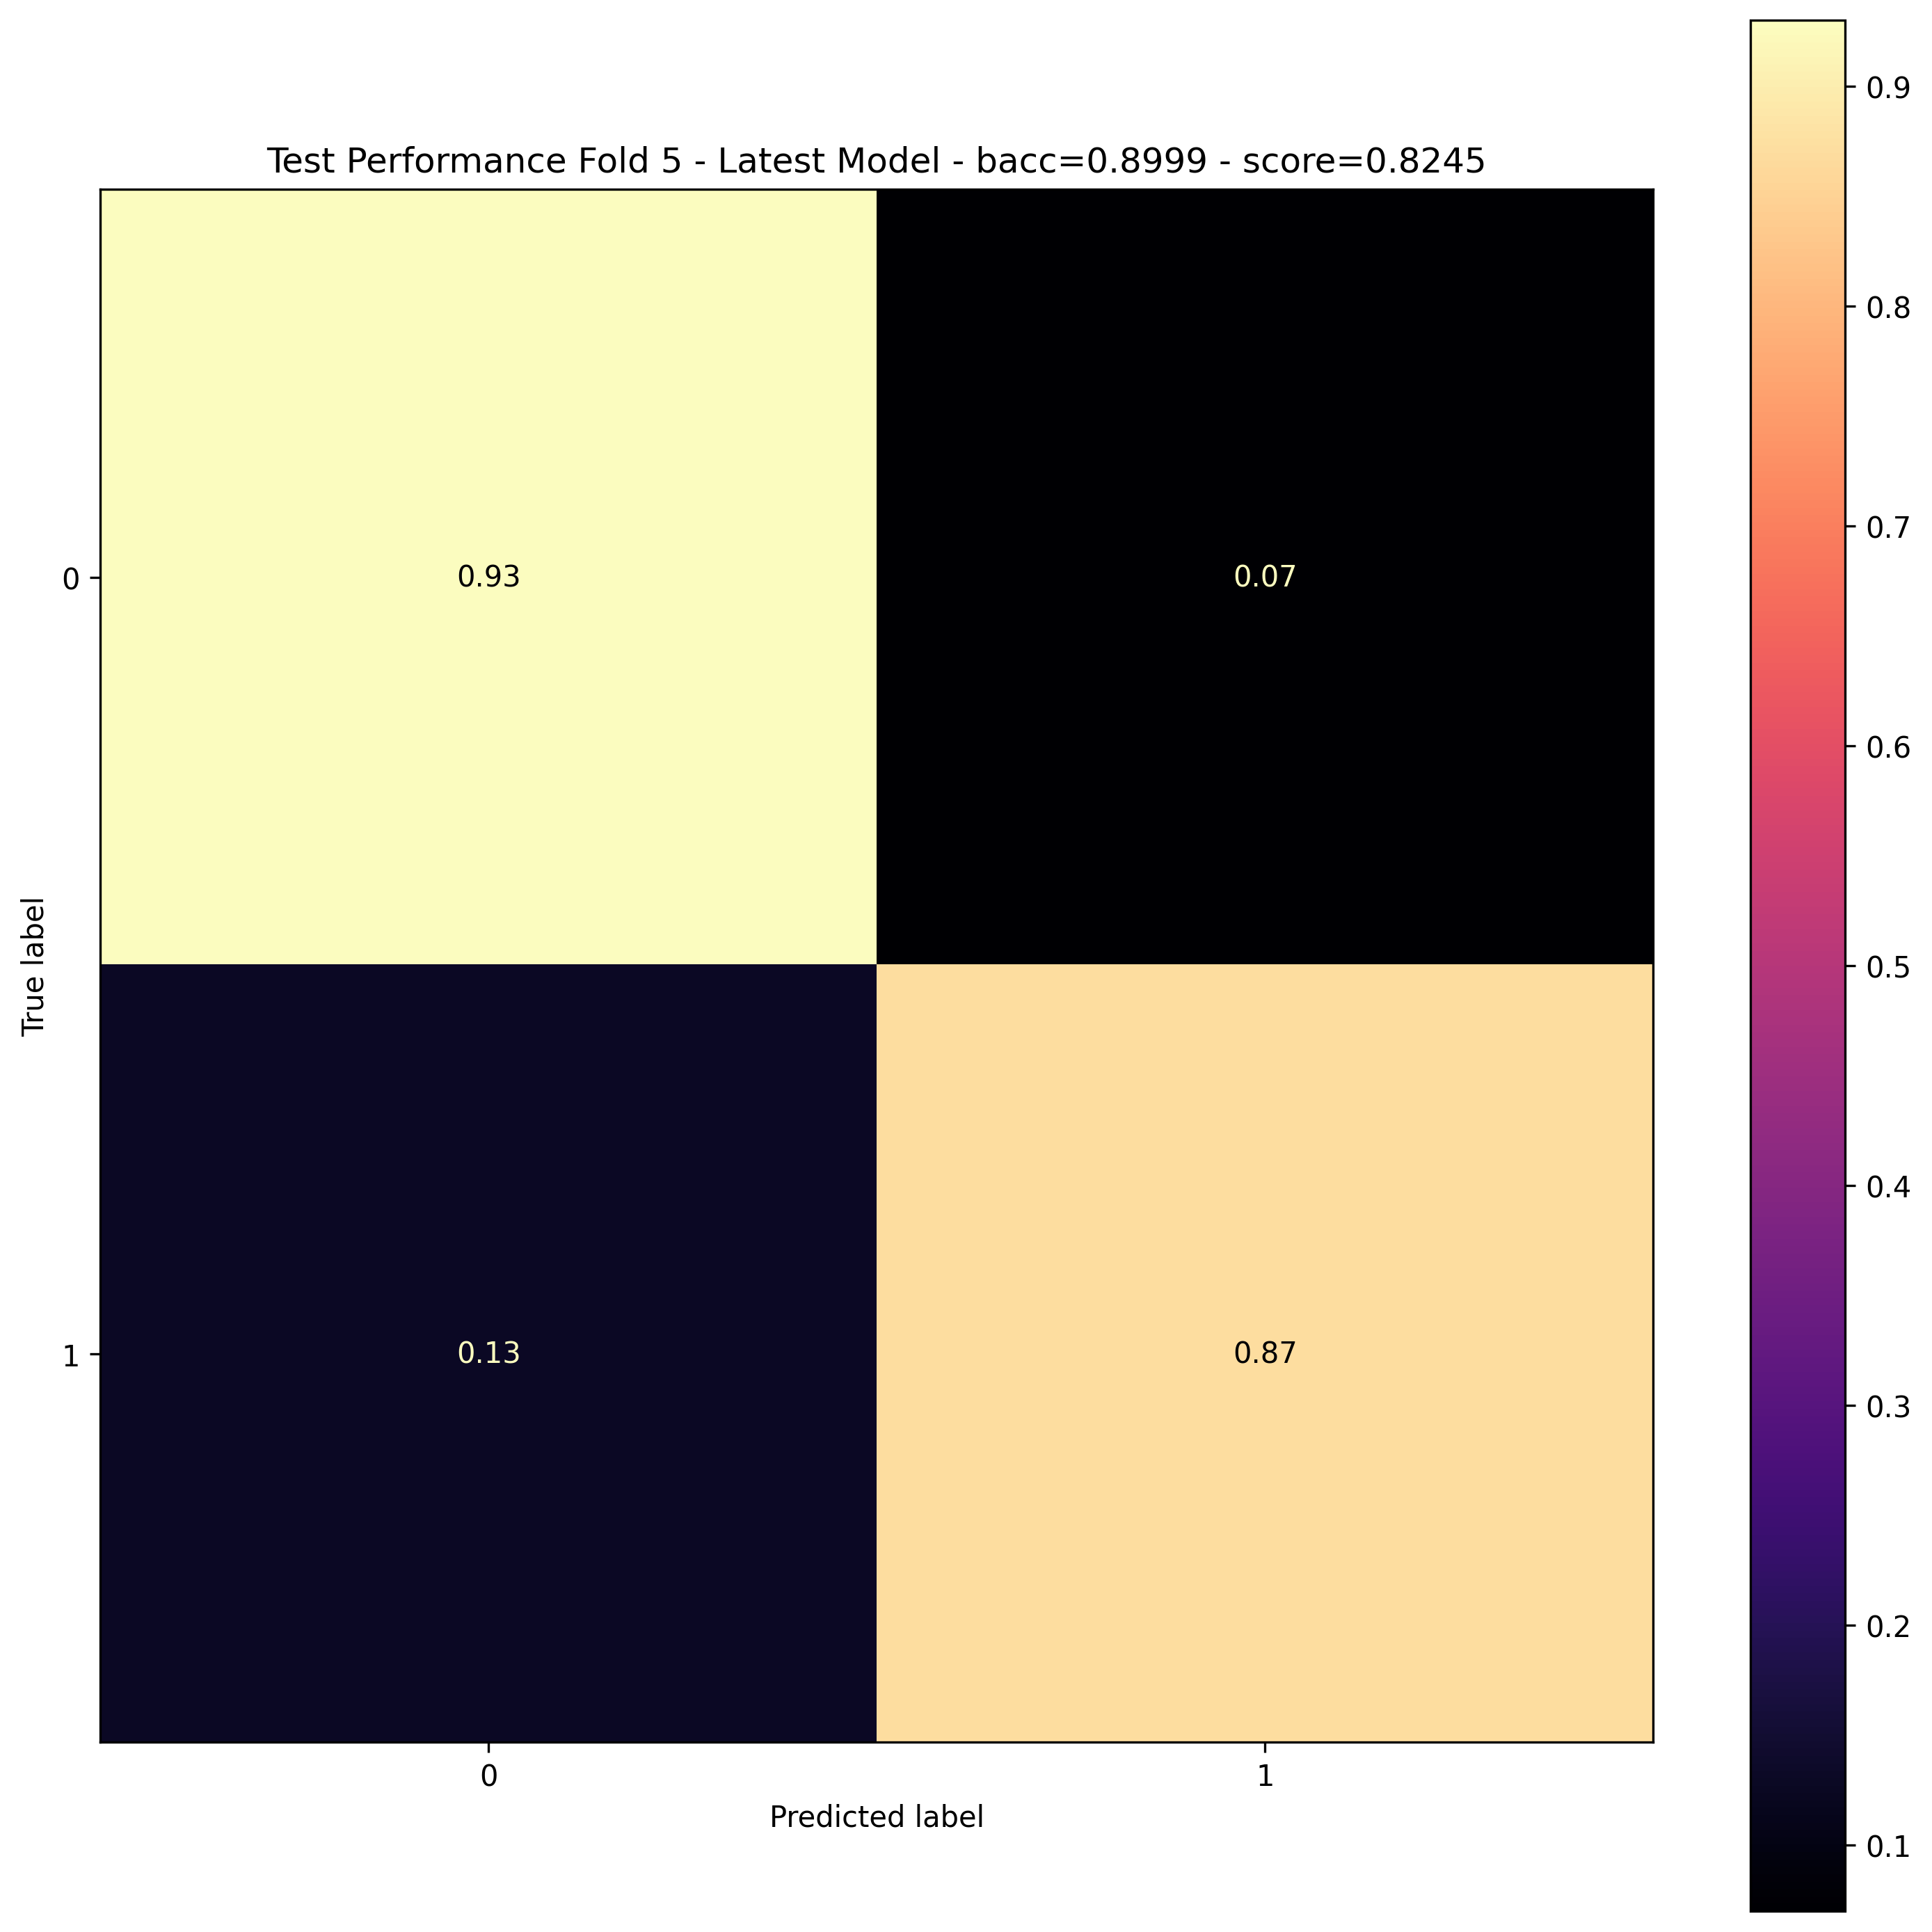

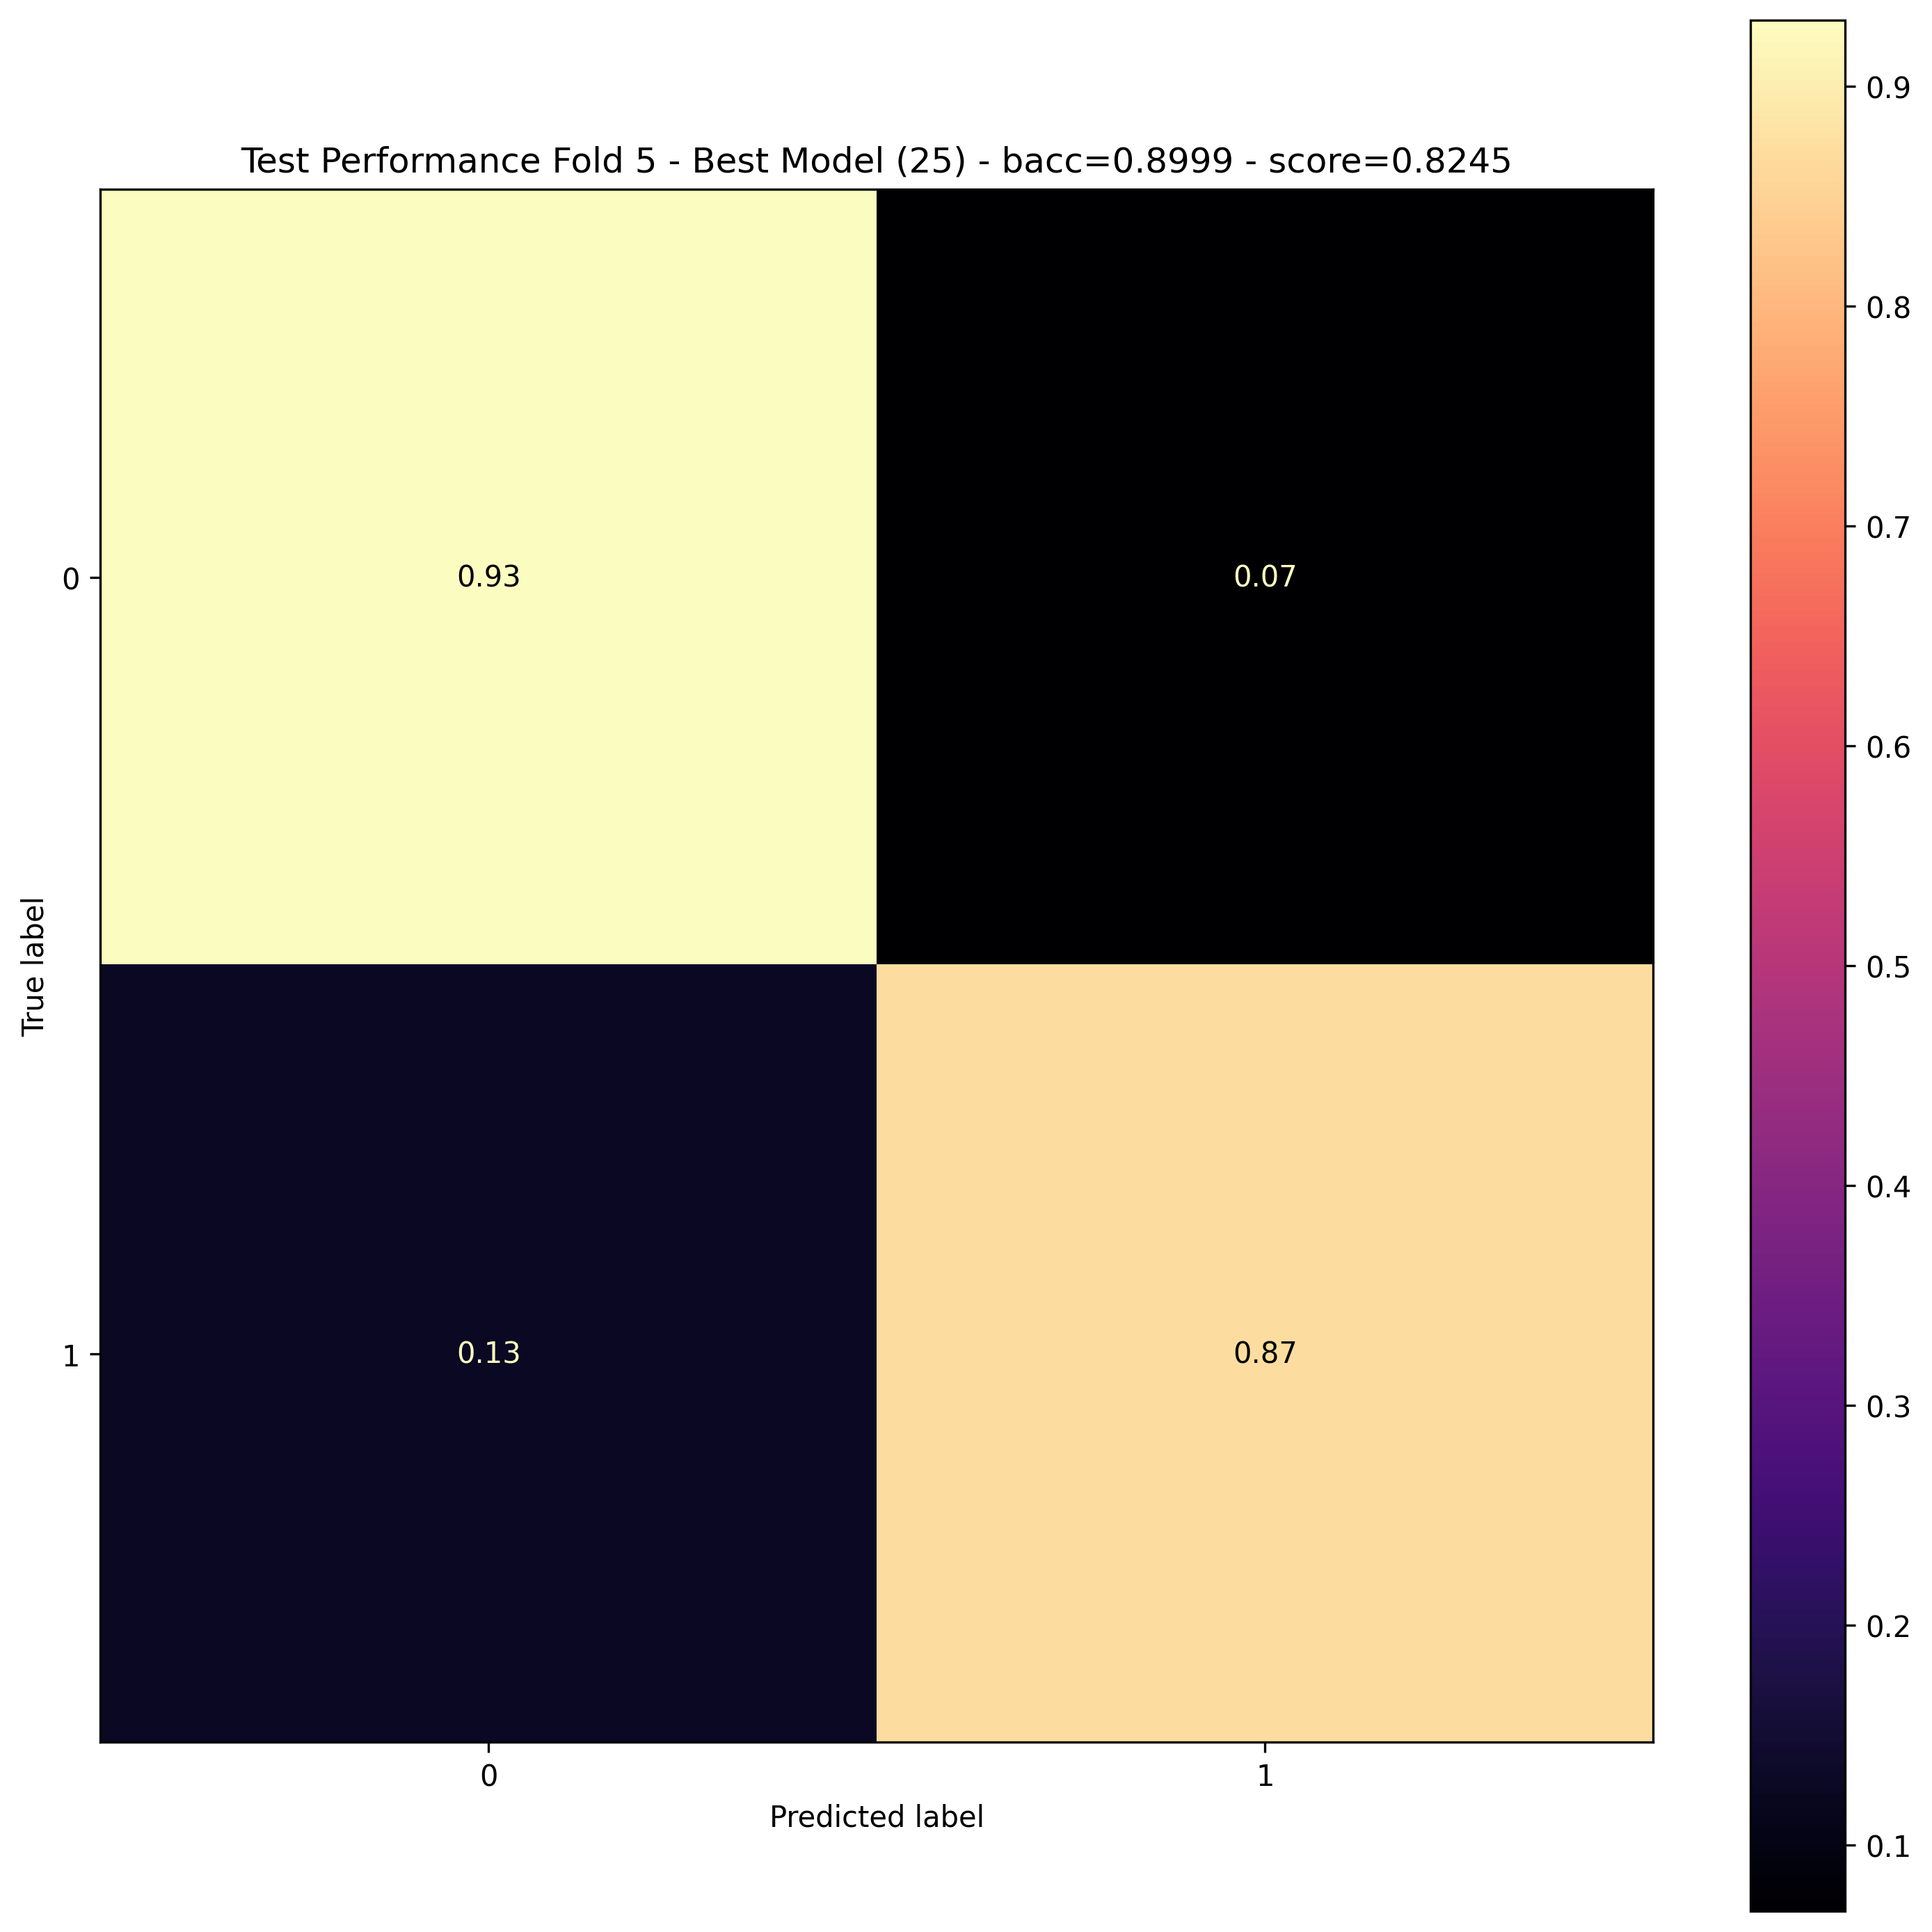

CV Folds:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6/8 [01:09<00:23, 11.57s/it]

Best Model Test Metrics: epoch =    -1, avg_loss = 0.000043, num_samples = 12000, num_correct = 10947, acc = 0.912250, bacc = 0.899888, score = 0.824500
Saved model with scaler as "bird_no_bird_classifier cv2023-06-15_14.38 fold-5-best eval-score=0.8335 test-score=0.8245"



Executing CV for fold 6
Training fold 6


#### Training ####
##################
AttentionClassifier with 228274 parameters, in_fnn: 86848, attention_stack: 132096, out_fnn: 9330
##################

train label counts = [67438, 27062]
eval label counts  = [ 9465,  4035]

loss weights                    = [ 0.50,  2.49]
eval loss weights (theoretical) = [ 0.50,  2.35]


Training Epoch   1/25 : lr = 1.00E-02, epoch =     1, avg_loss = 0.000072, num_samples = 94500, num_correct = 39178, acc = 0.414582, bacc = 0.501745, score = -0.170836
Evaluation Epoch   1/25 : epoch =     1, avg_loss = 0.000127, num_samples = 13500, num_correct =  4035, acc = 0.298889, bacc = 0.500000, score = -0.402222
Training Epoch   2/25 : lr = 1

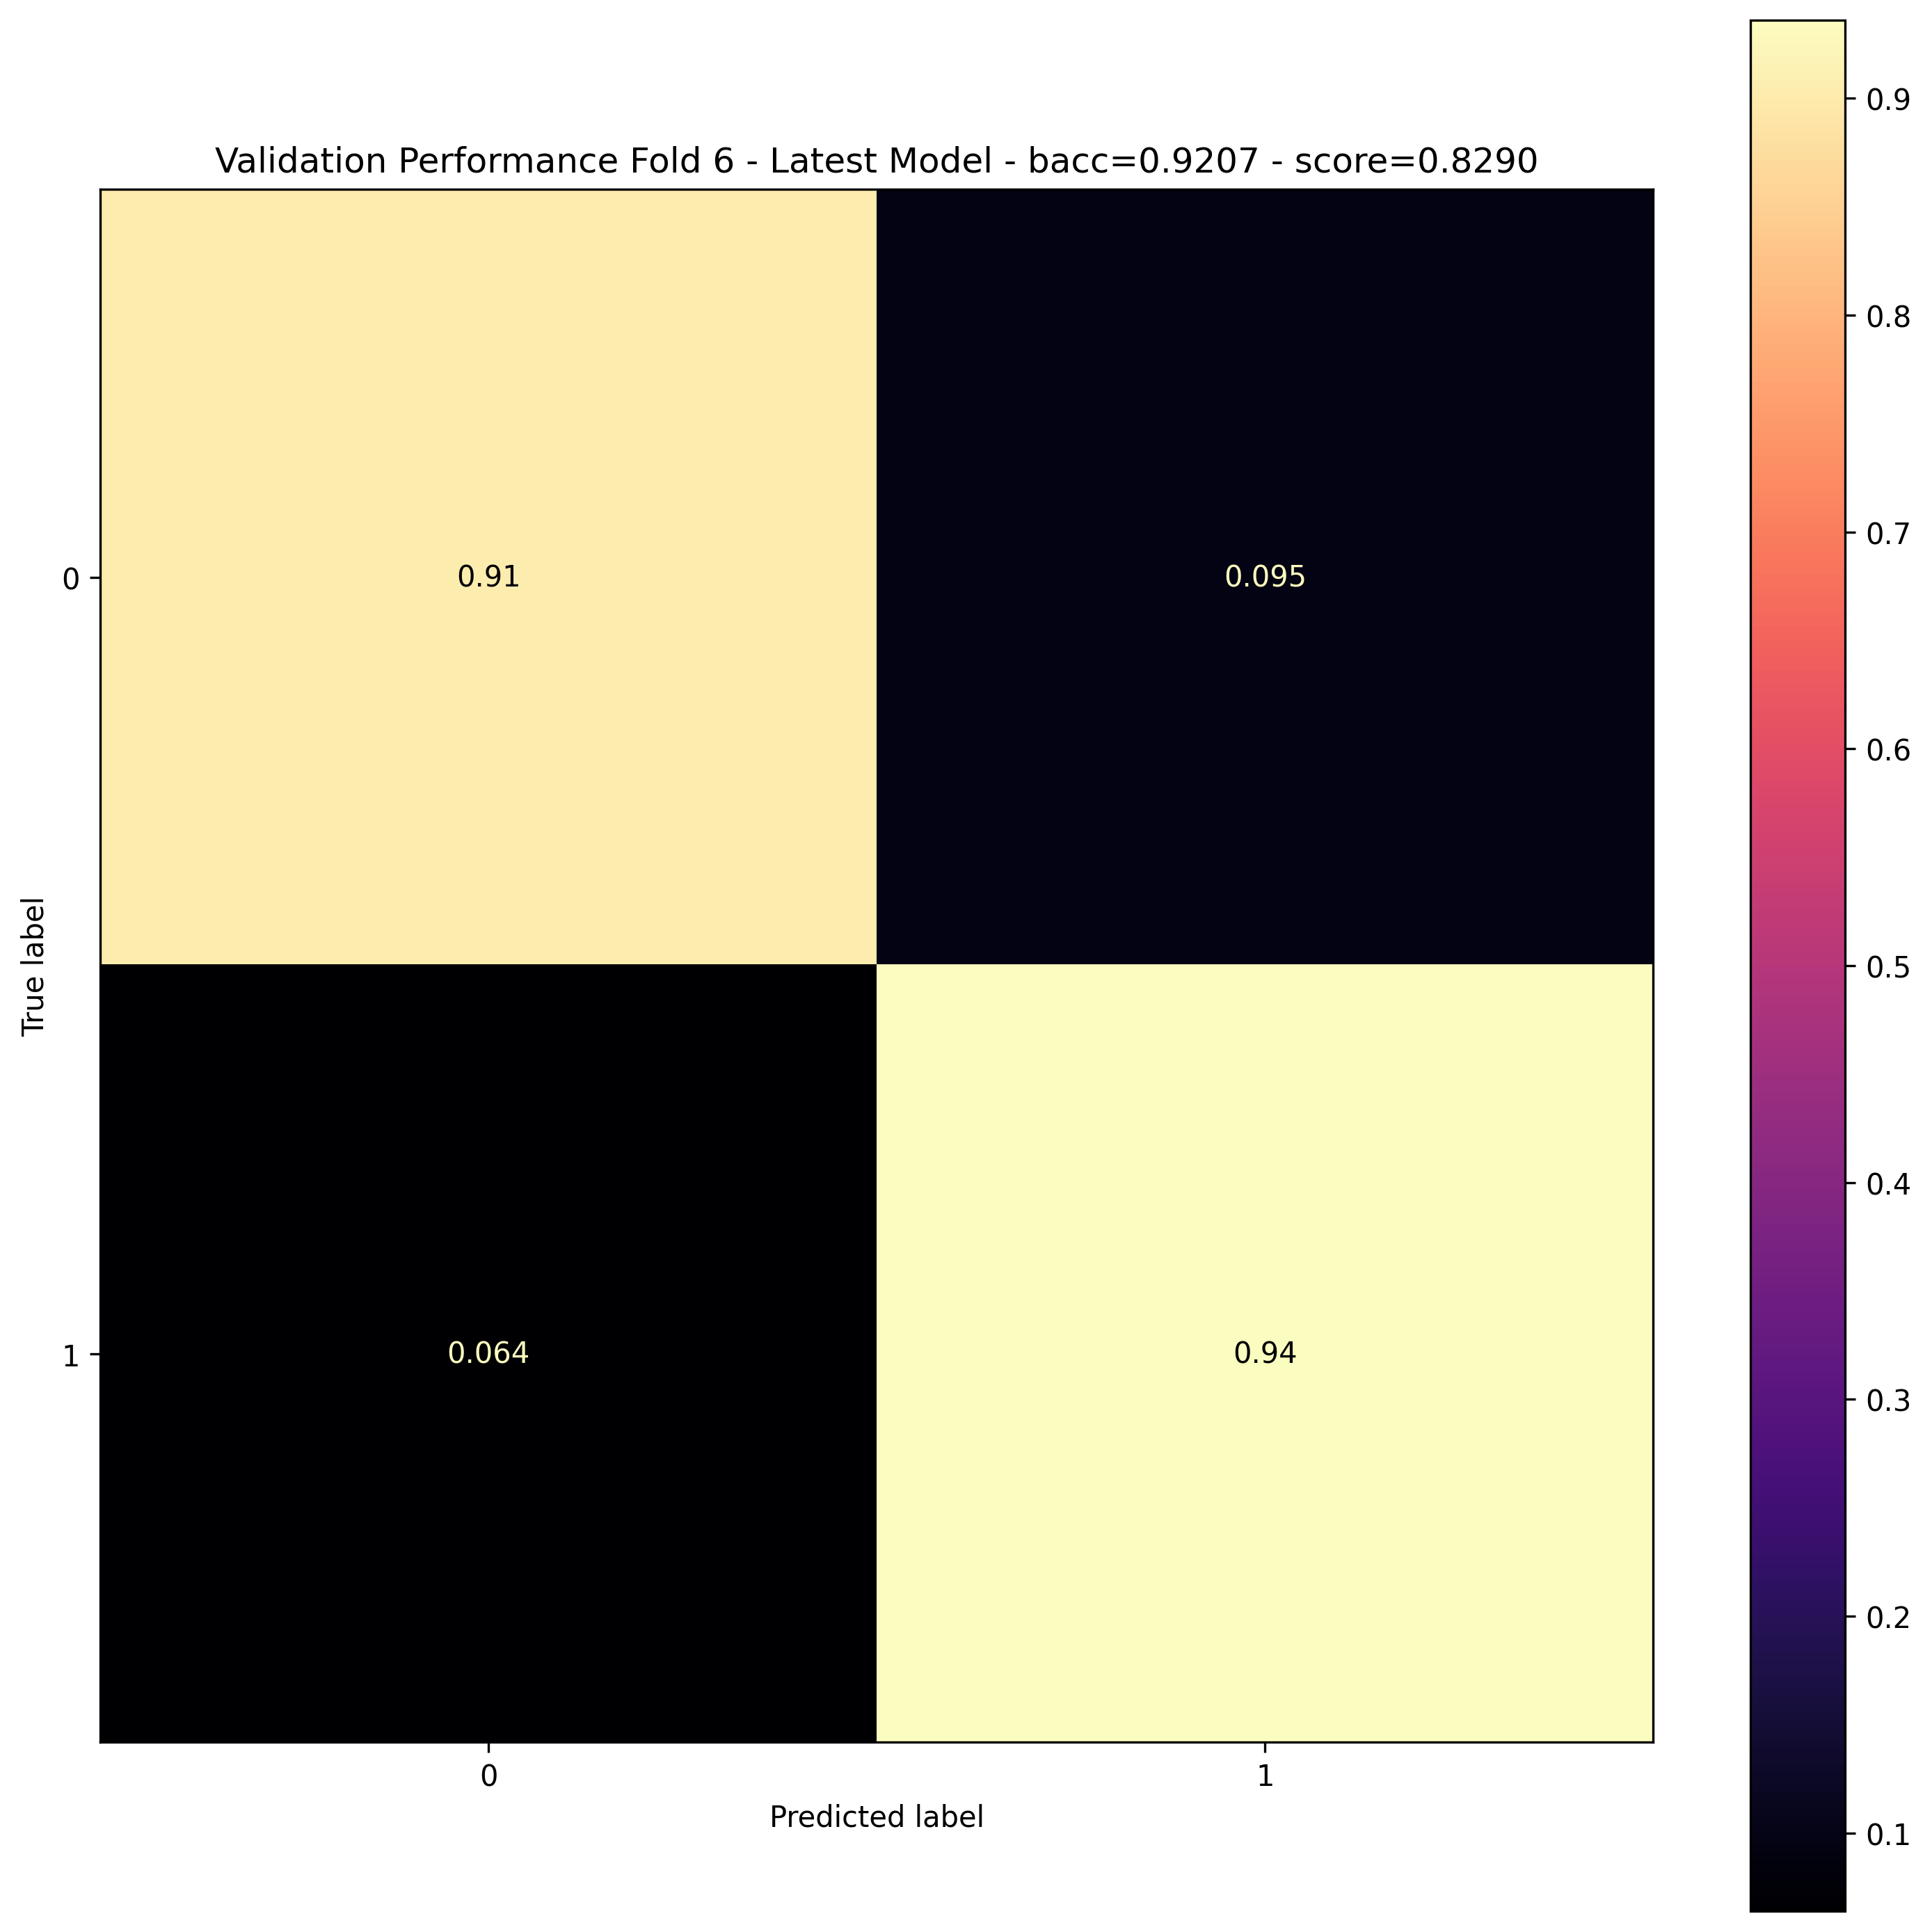

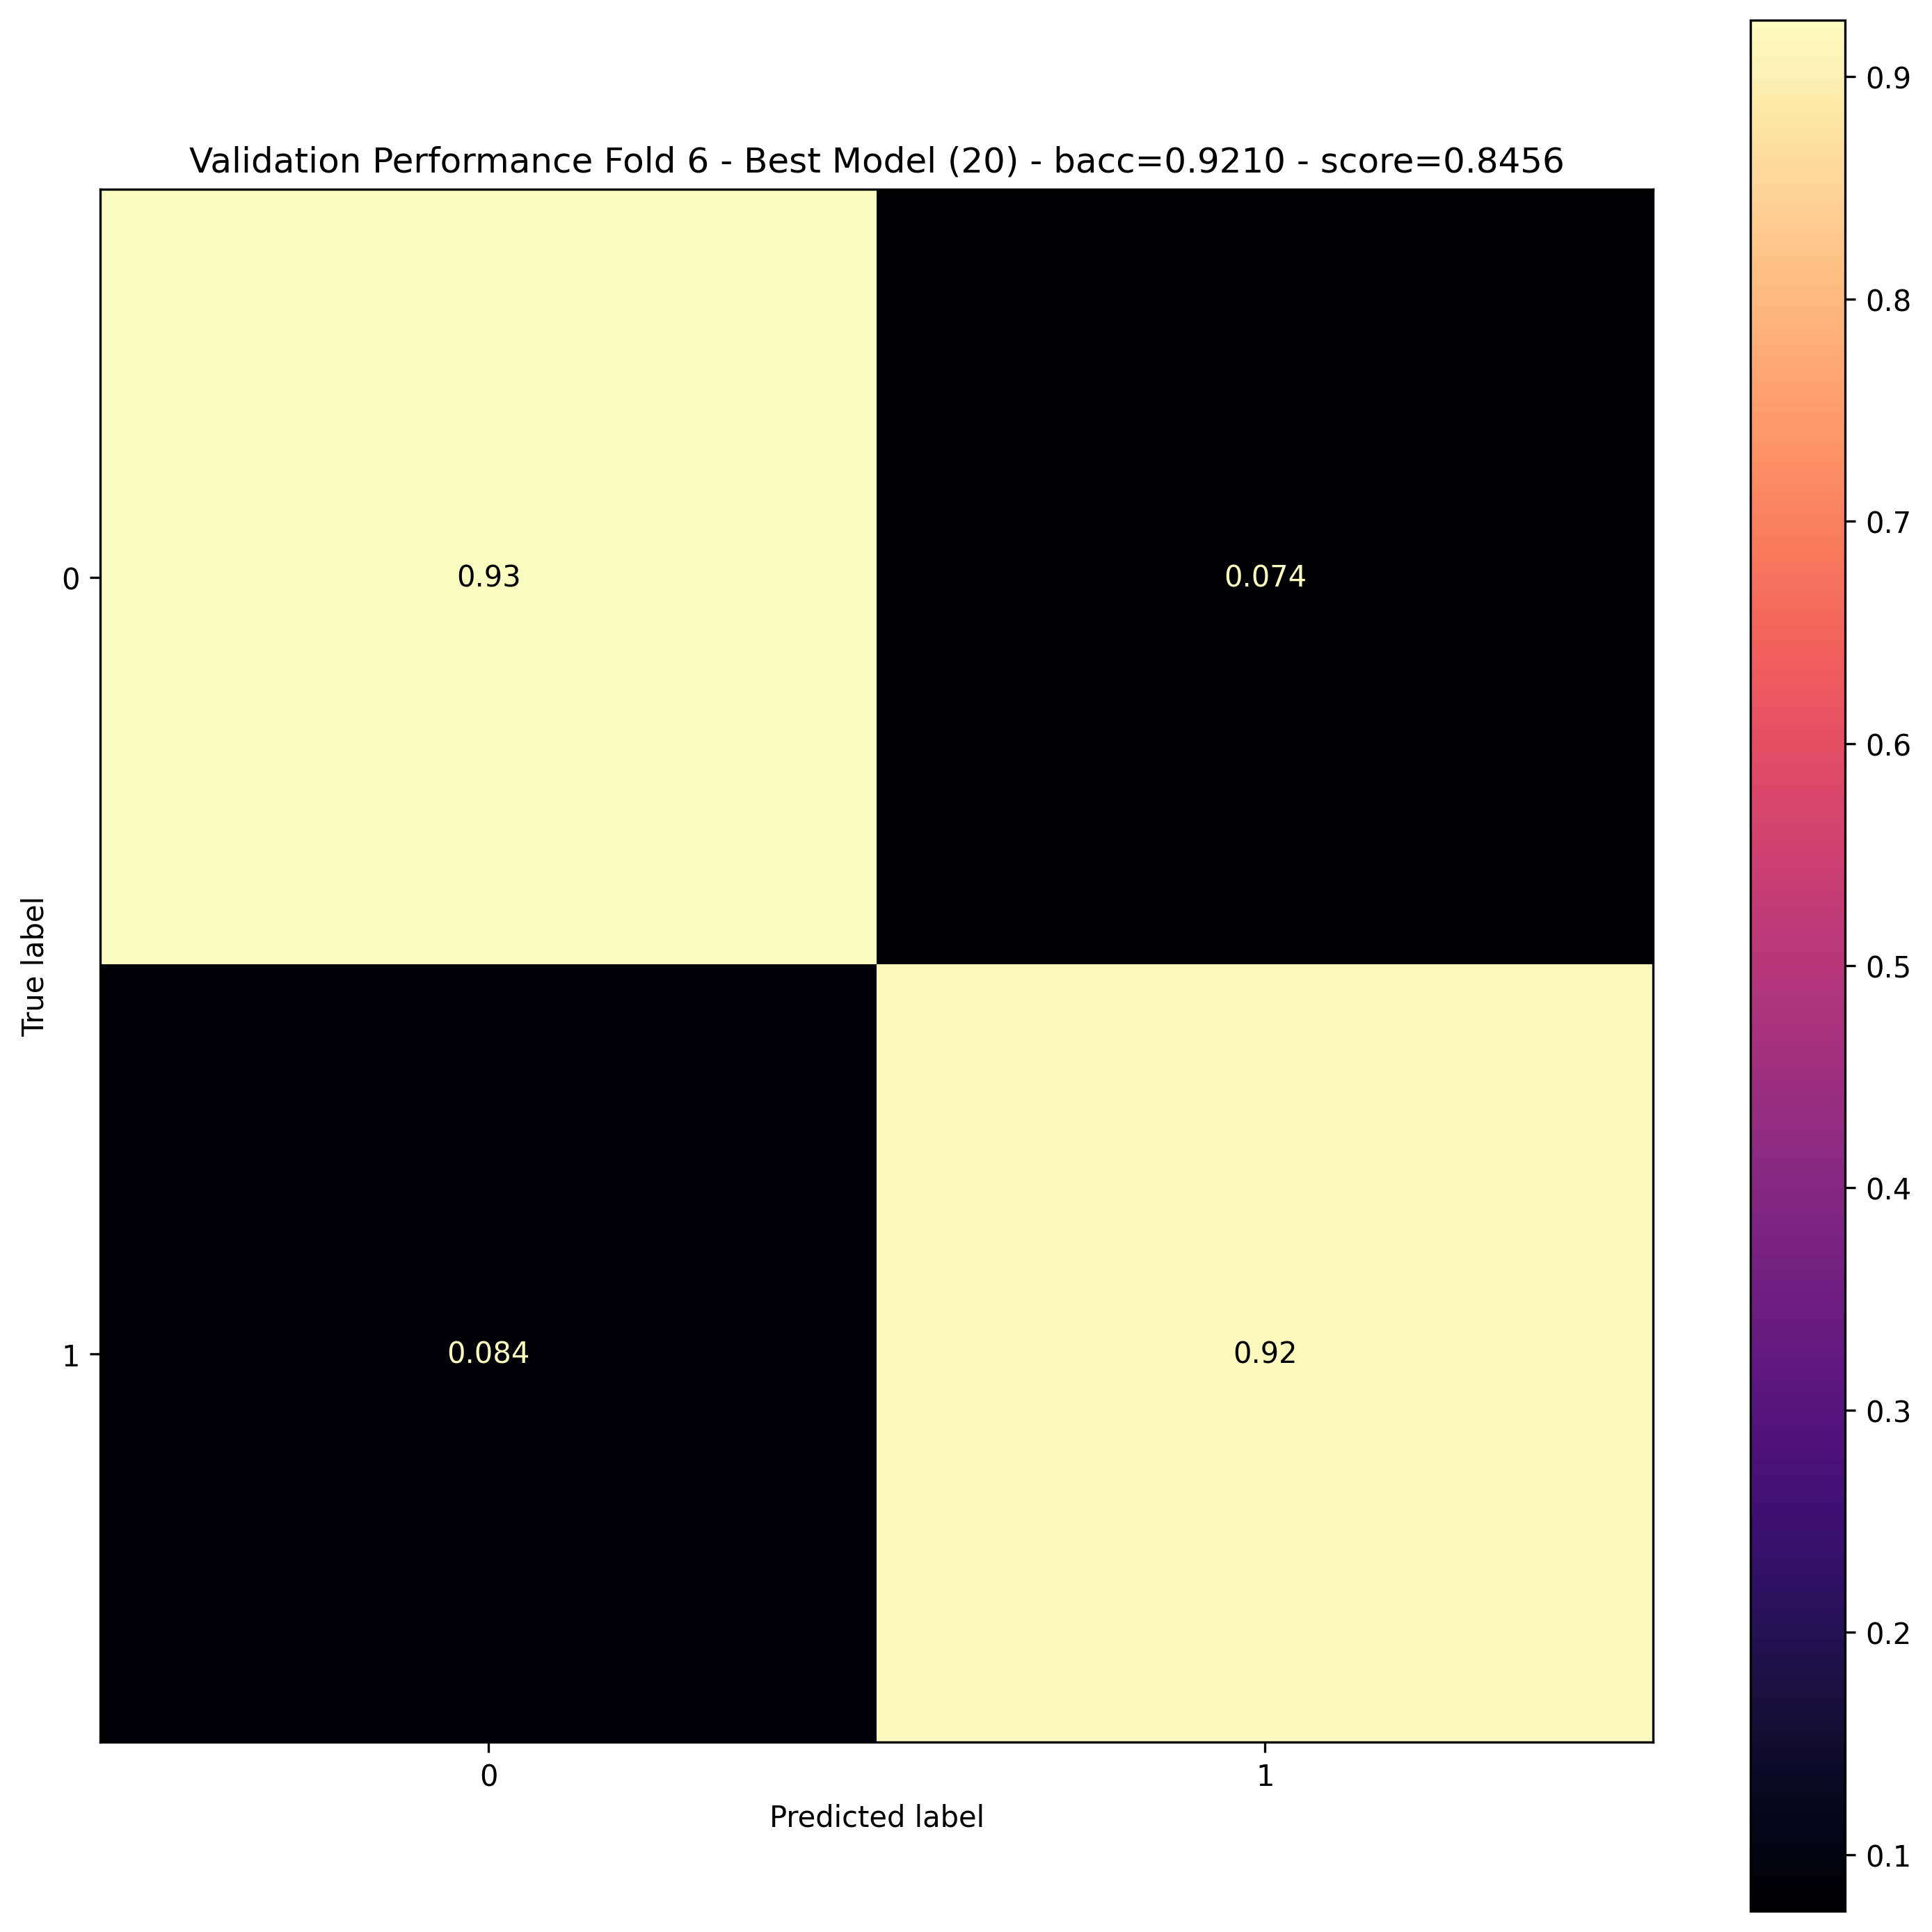


Testing fold 6


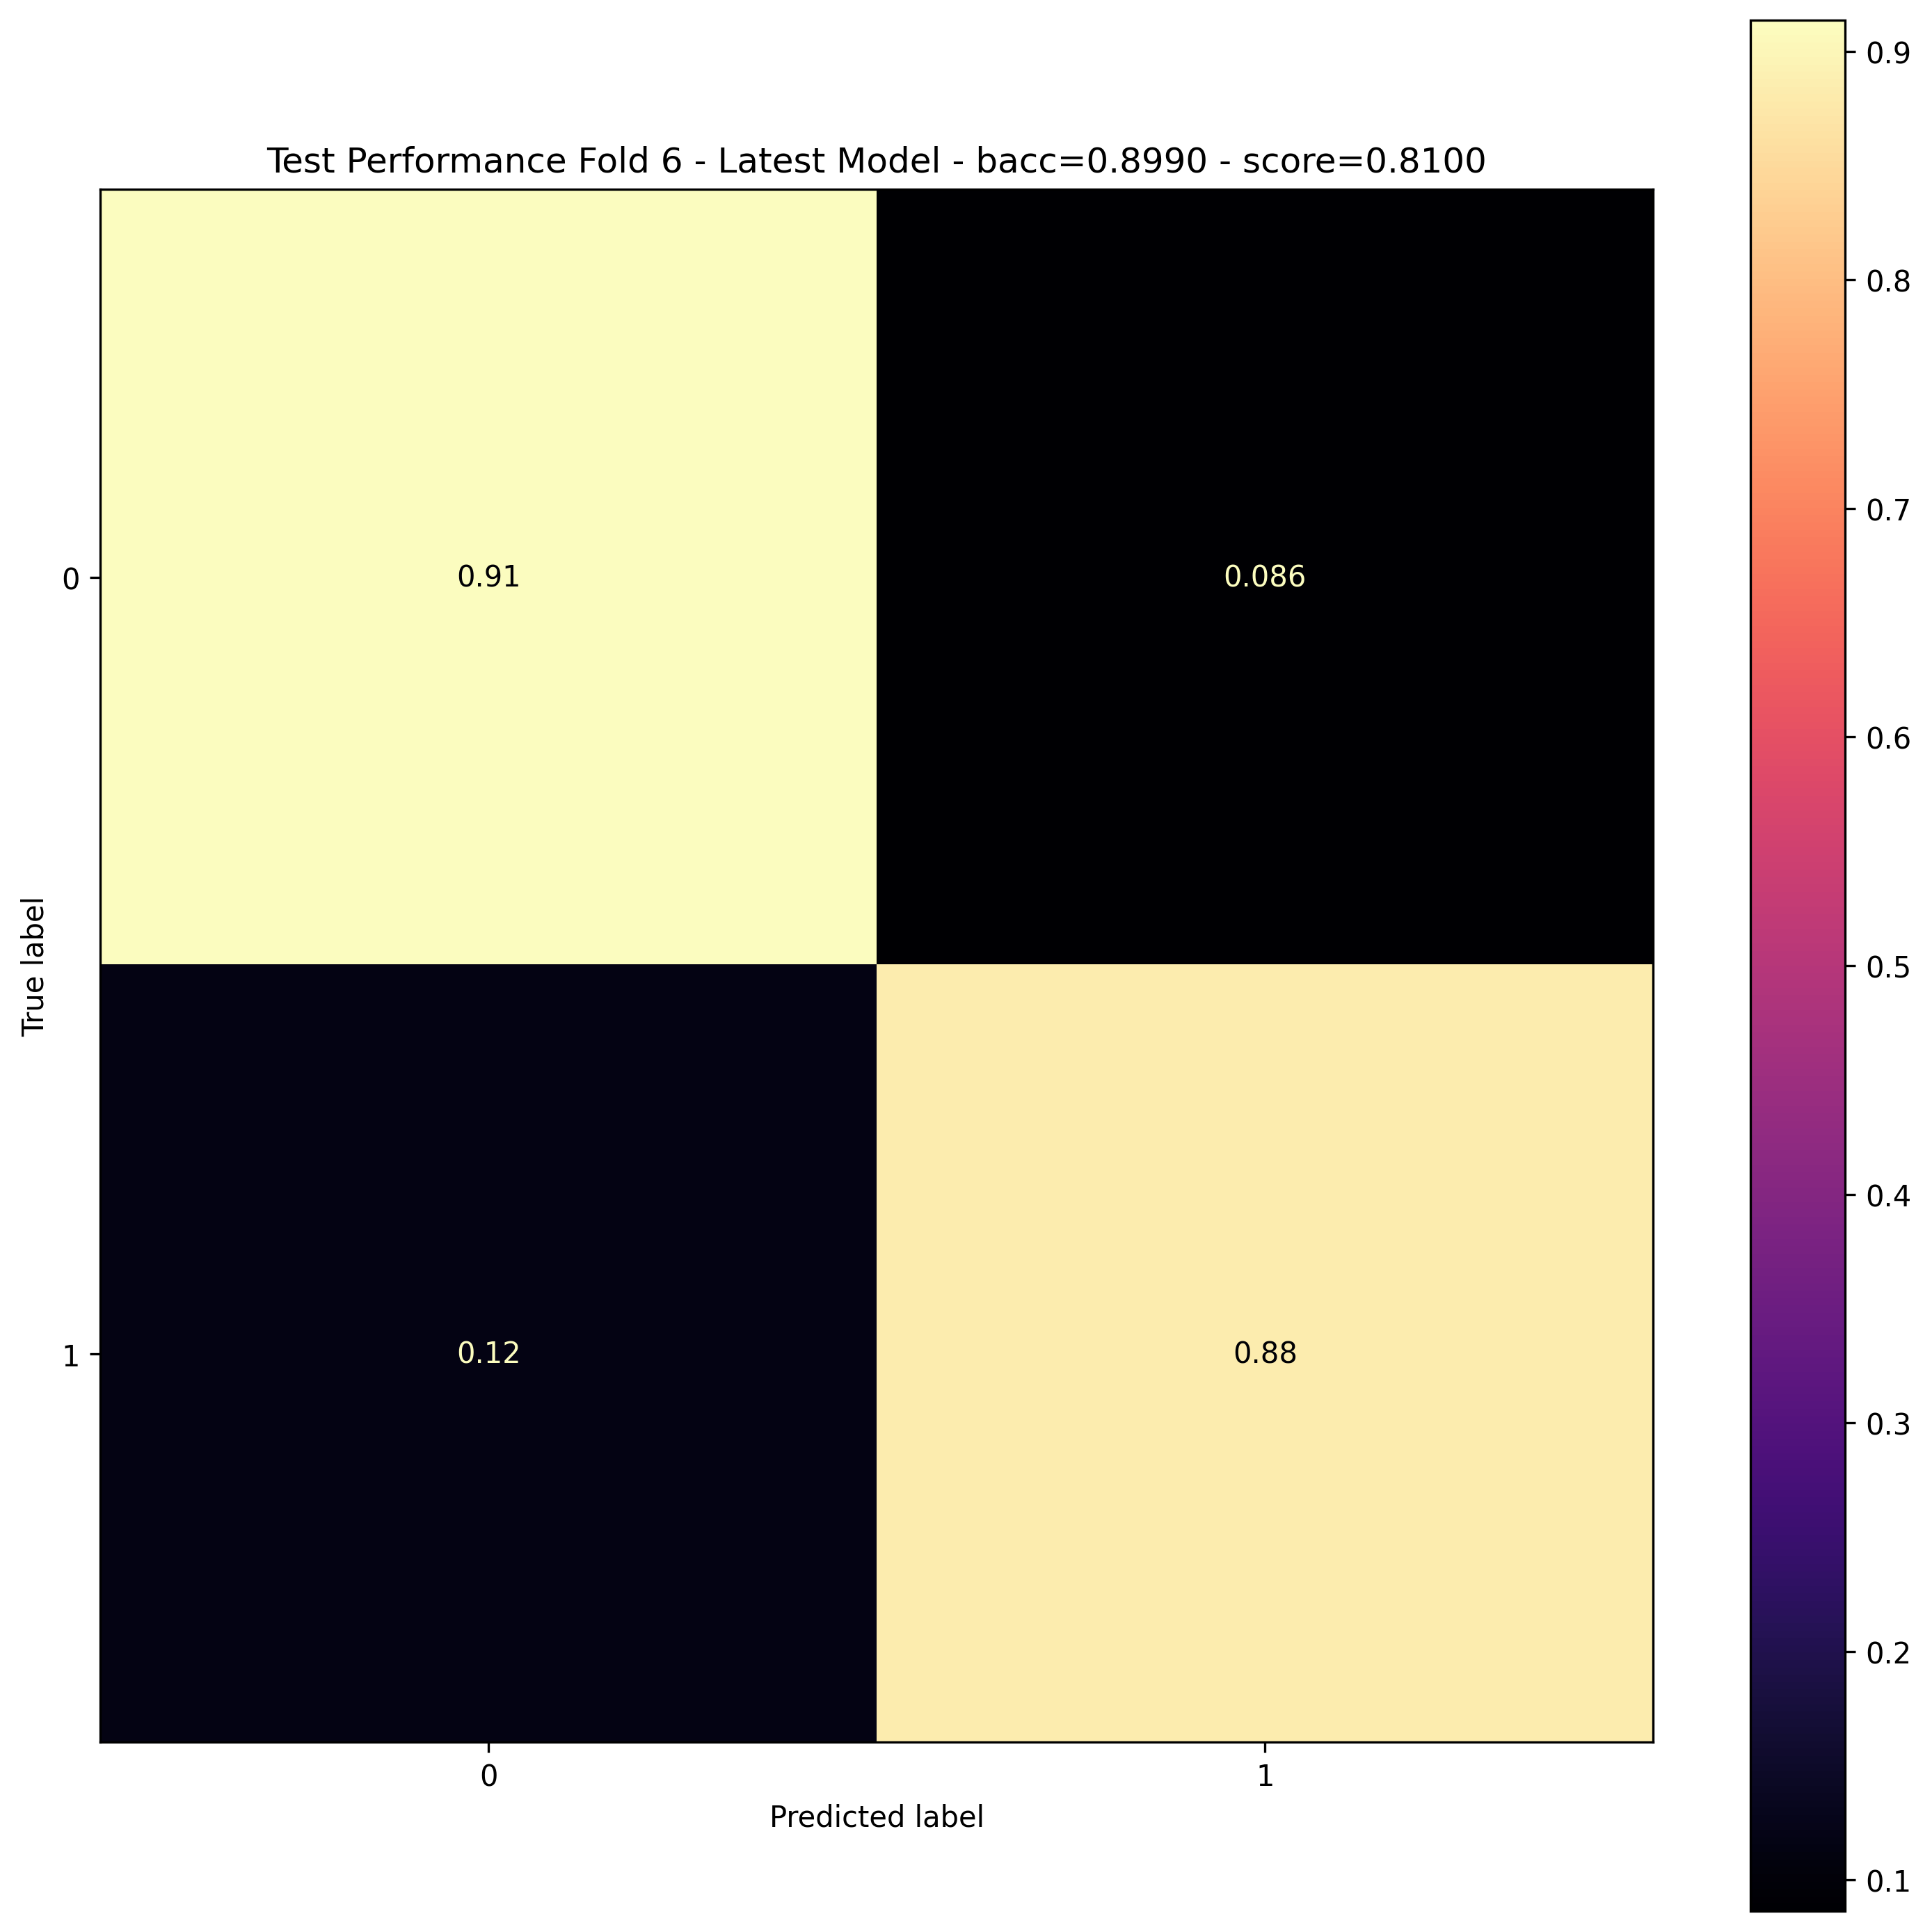

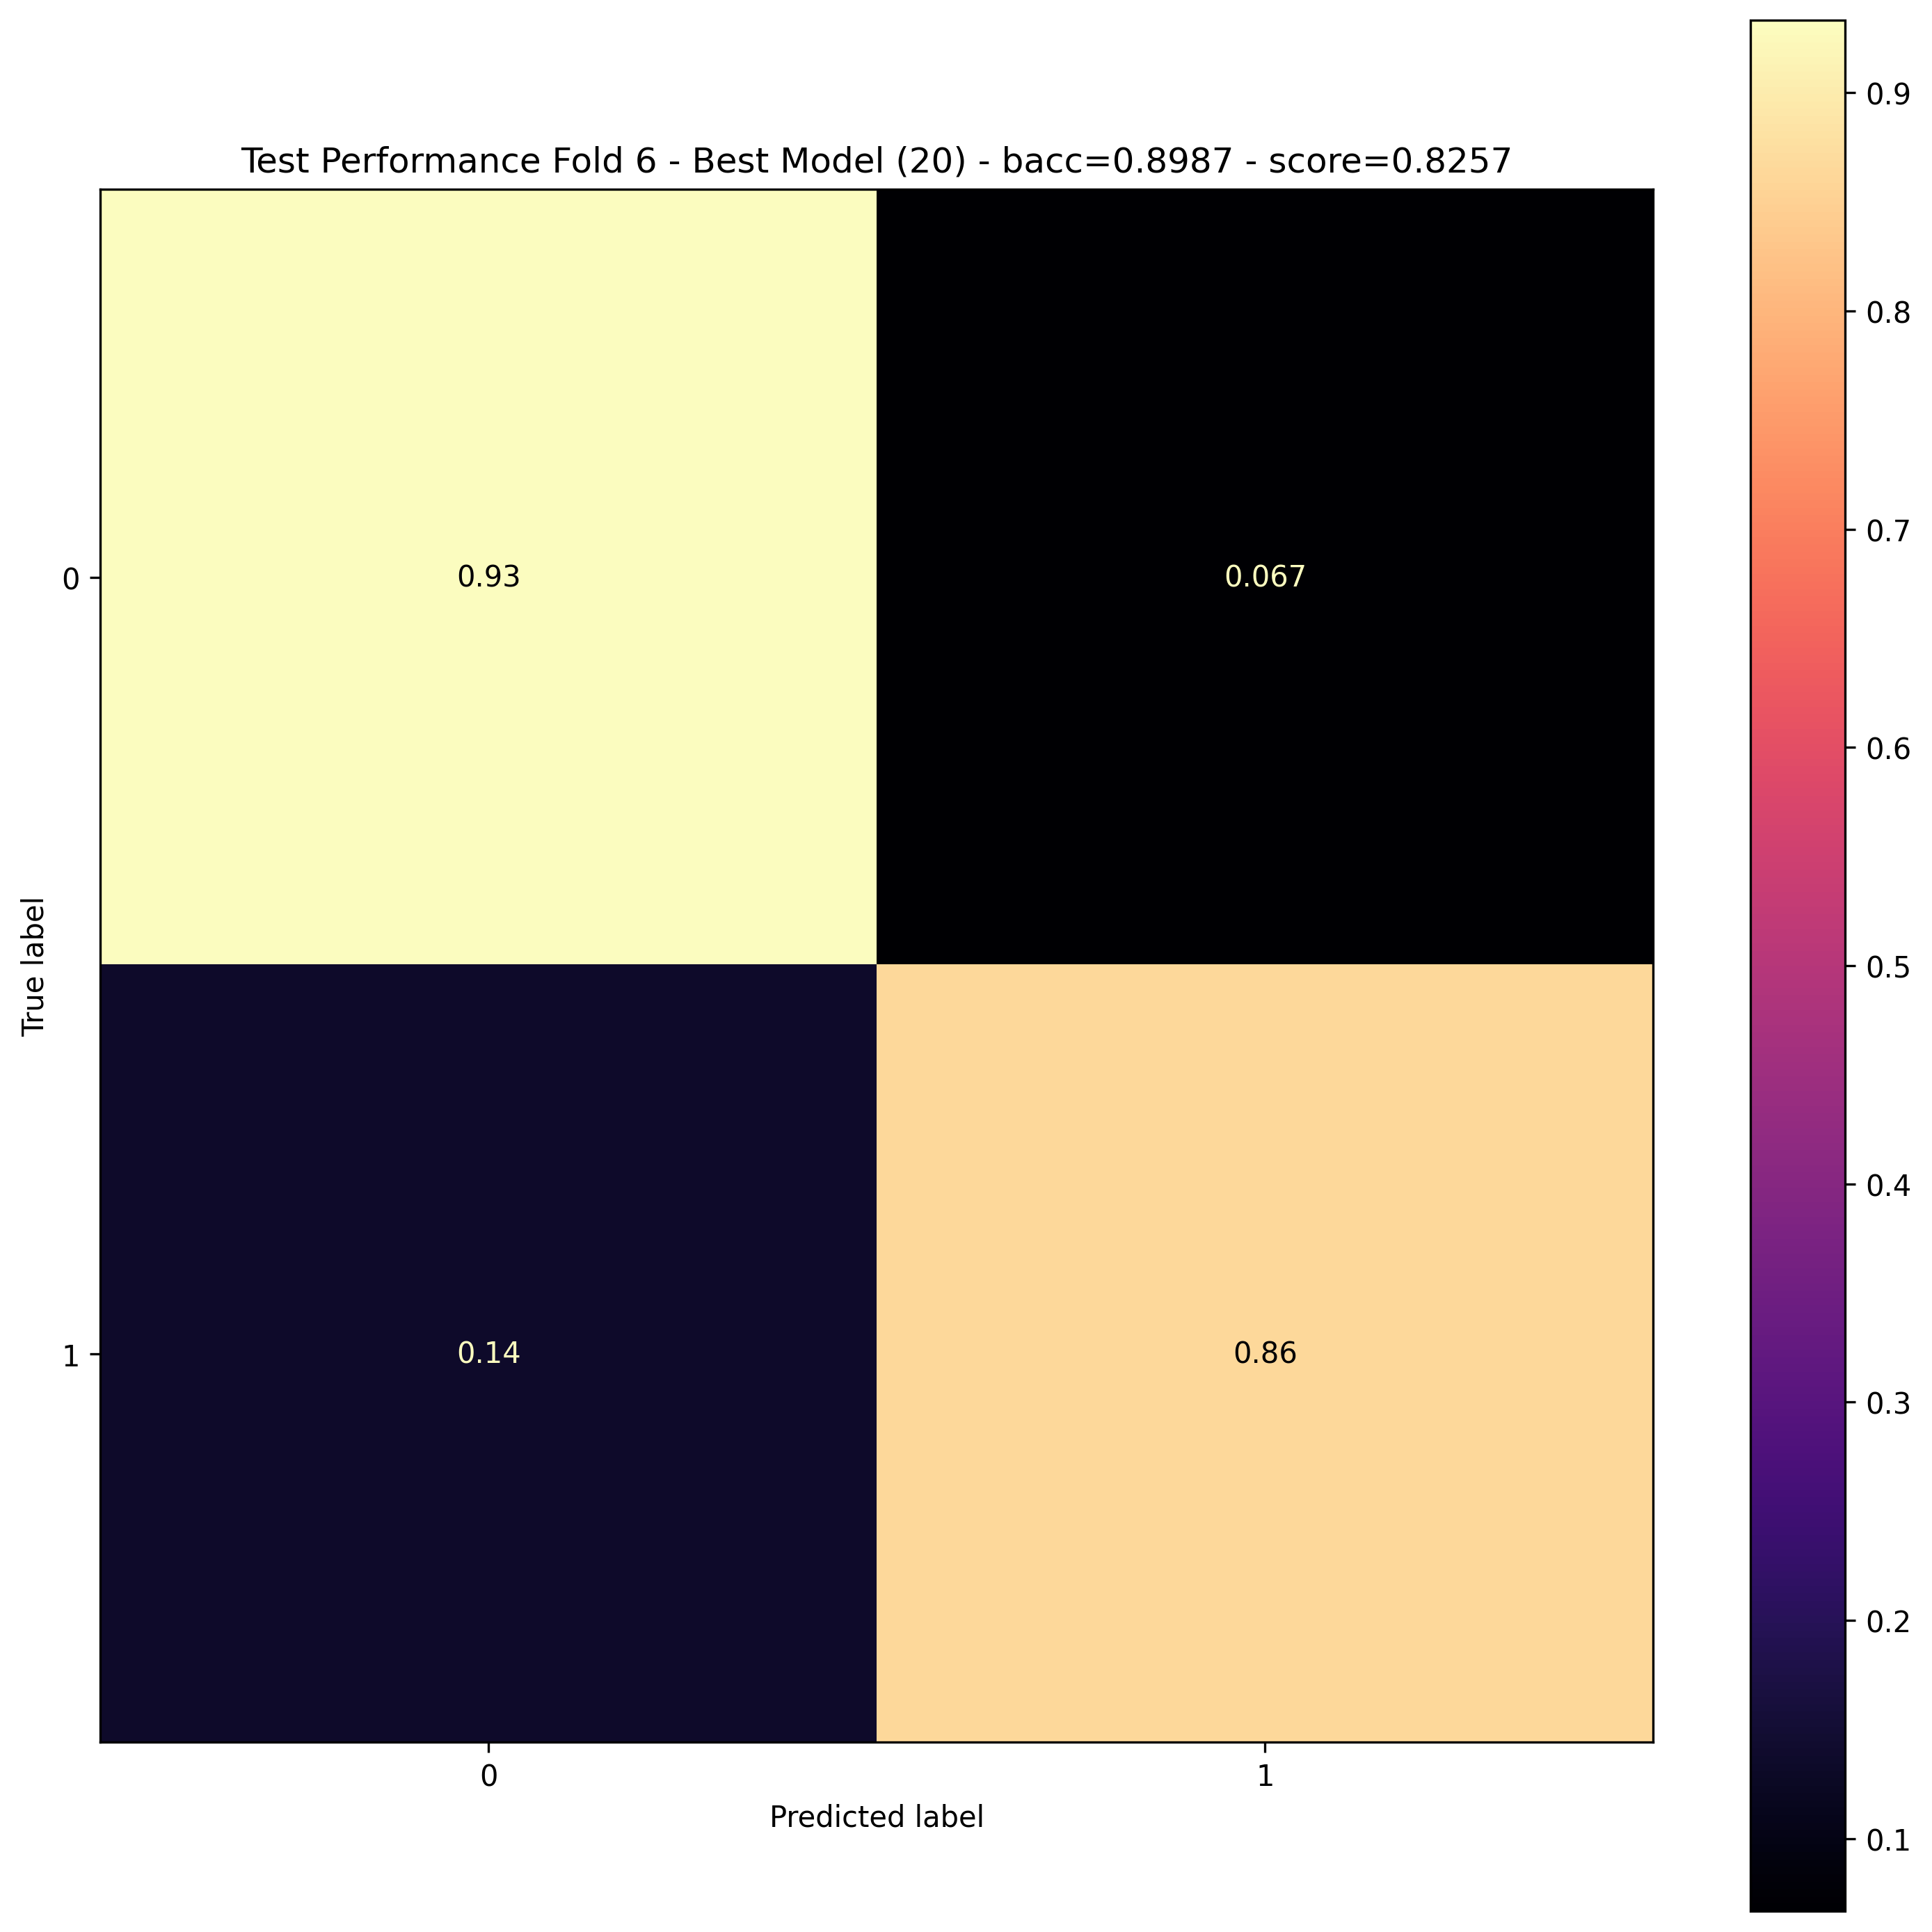

CV Folds:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 7/8 [01:20<00:11, 11.54s/it]

Best Model Test Metrics: epoch =    -1, avg_loss = 0.000039, num_samples = 12000, num_correct = 10954, acc = 0.912833, bacc = 0.898664, score = 0.825667
Saved model with scaler as "bird_no_bird_classifier cv2023-06-15_14.38 fold-6-best eval-score=0.8456 test-score=0.8257"



Executing CV for fold 7
Training fold 7


#### Training ####
##################
AttentionClassifier with 228274 parameters, in_fnn: 86848, attention_stack: 132096, out_fnn: 9330
##################

train label counts = [67159, 27341]
eval label counts  = [ 9744,  3756]

loss weights                    = [ 0.50,  2.46]
eval loss weights (theoretical) = [ 0.50,  2.59]


Training Epoch   1/25 : lr = 1.00E-02, epoch =     1, avg_loss = 0.000070, num_samples = 94500, num_correct = 27440, acc = 0.290370, bacc = 0.500336, score = -0.419259
Evaluation Epoch   1/25 : epoch =     1, avg_loss = 0.000127, num_samples = 13500, num_correct =  3756, acc = 0.278222, bacc = 0.500000, score = -0.443556
Training Epoch   2/25 : lr = 1

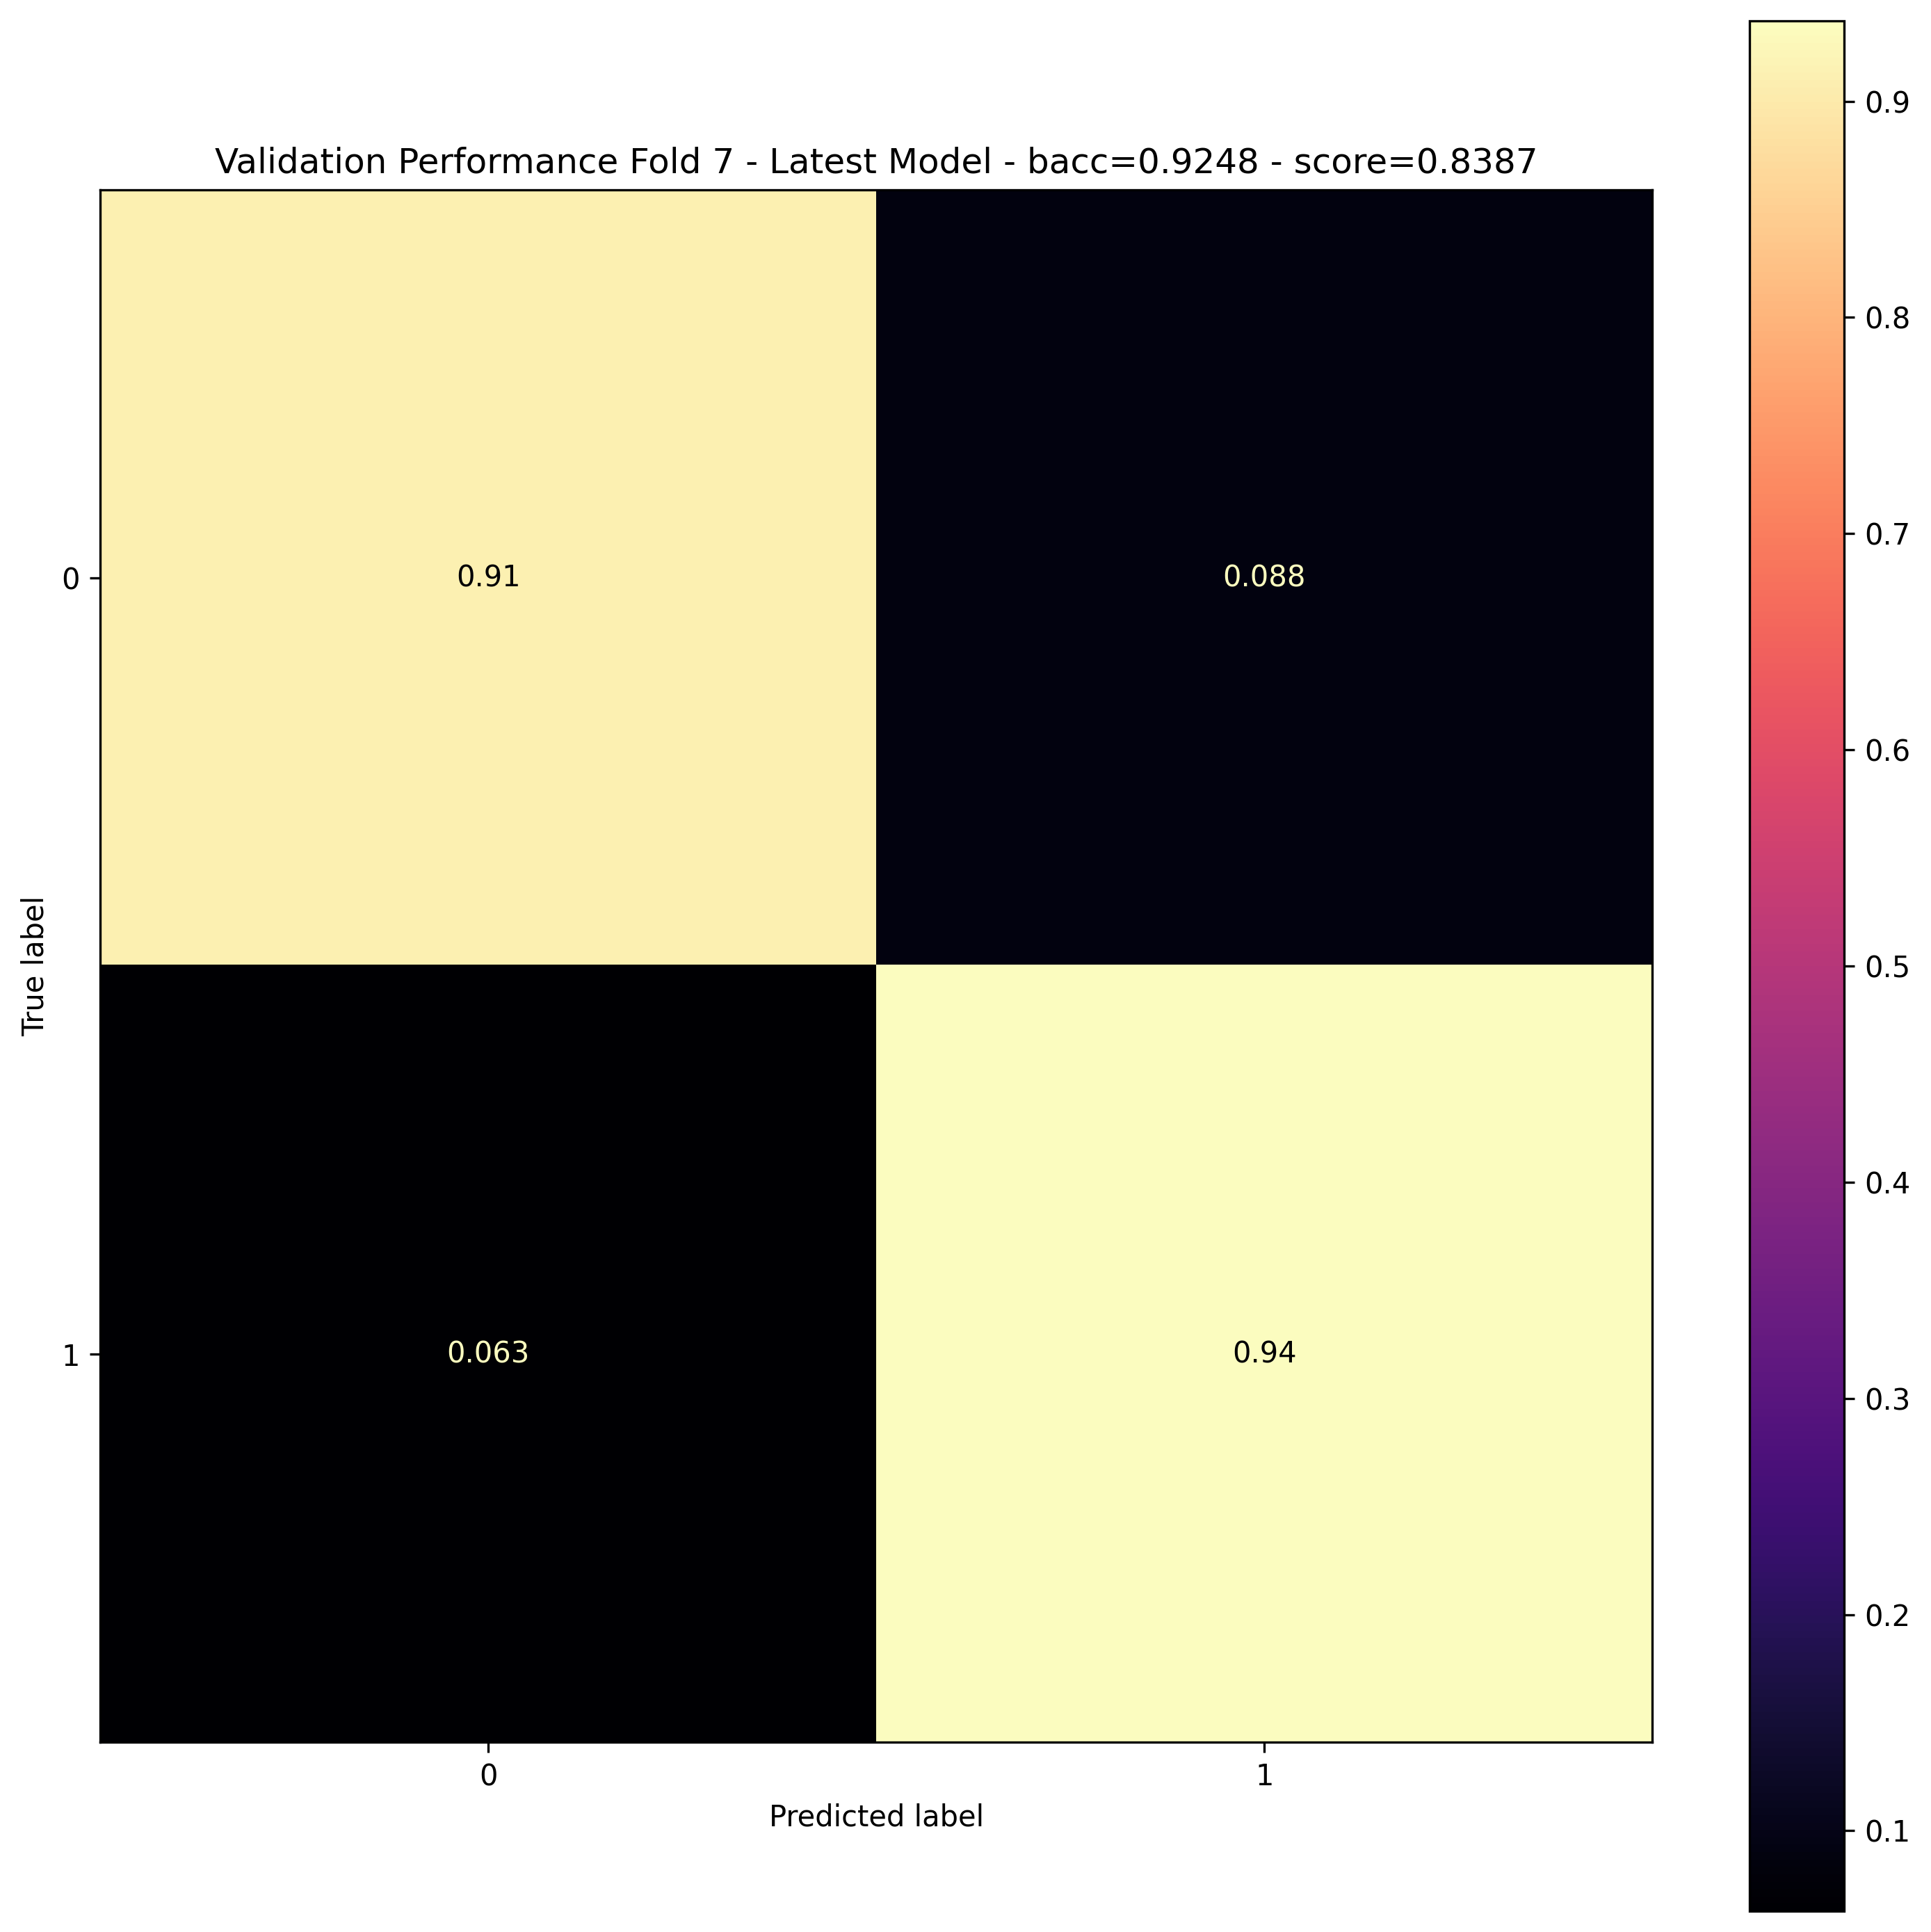

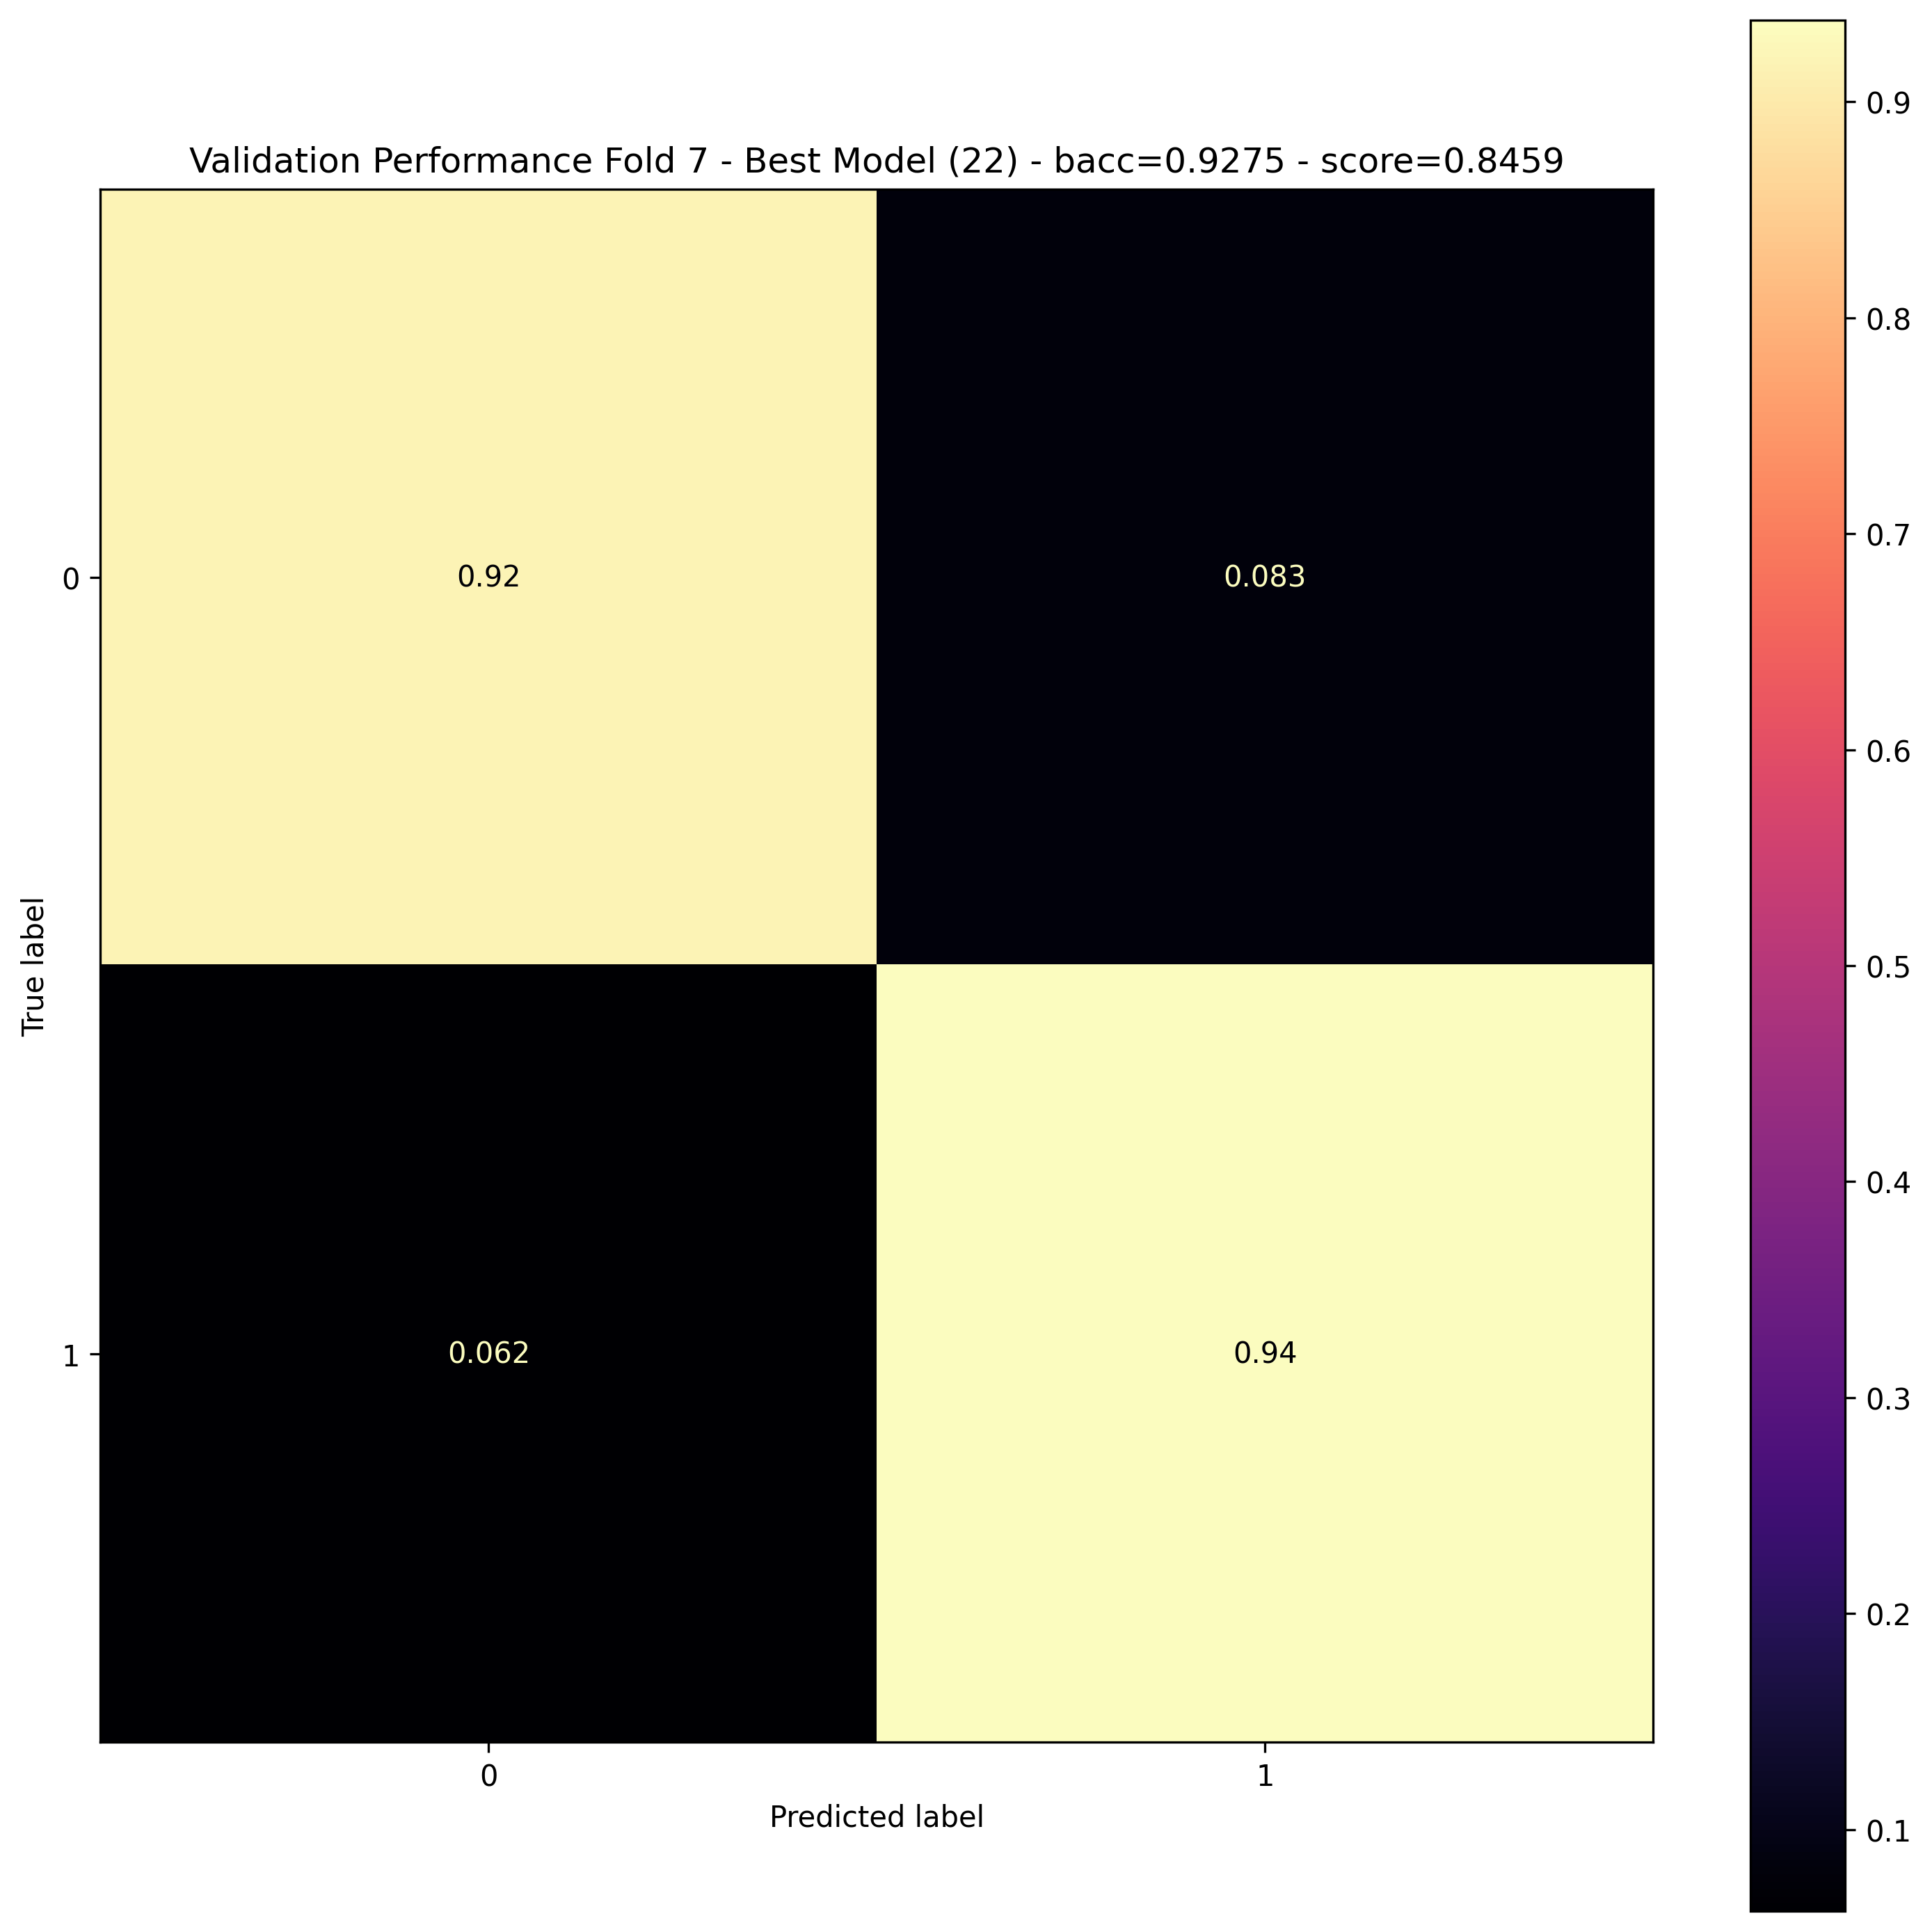


Testing fold 7


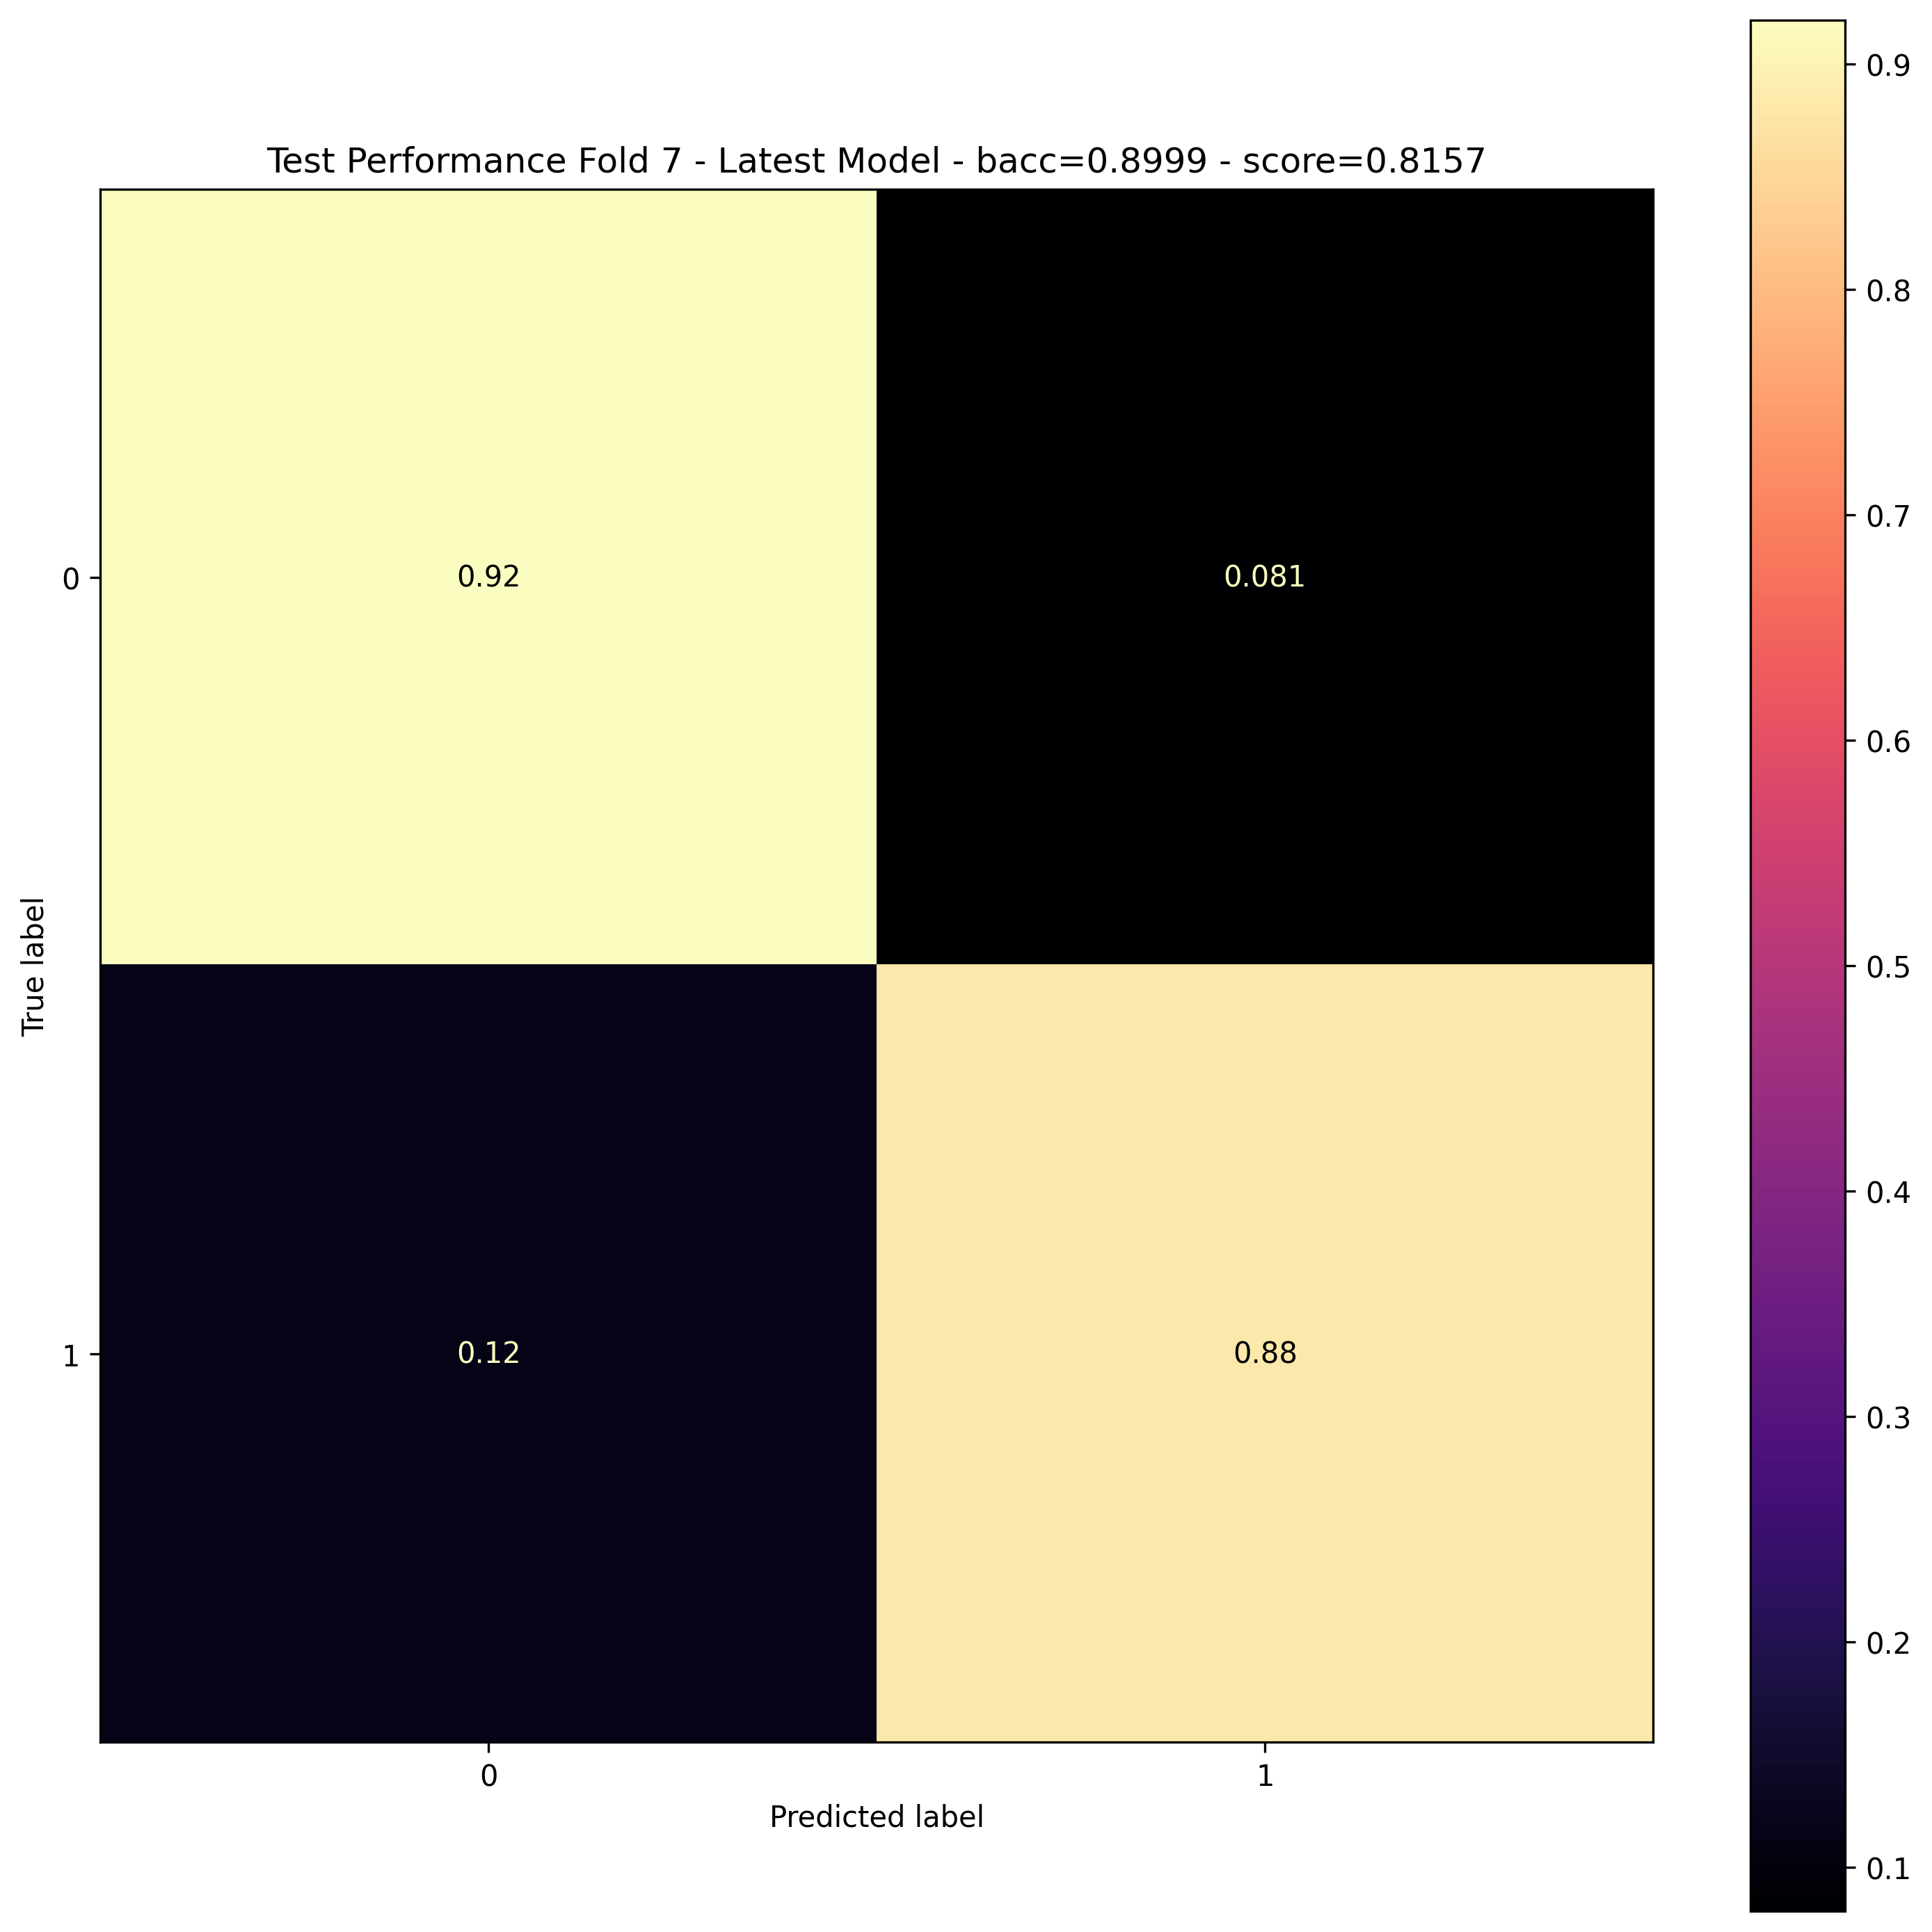

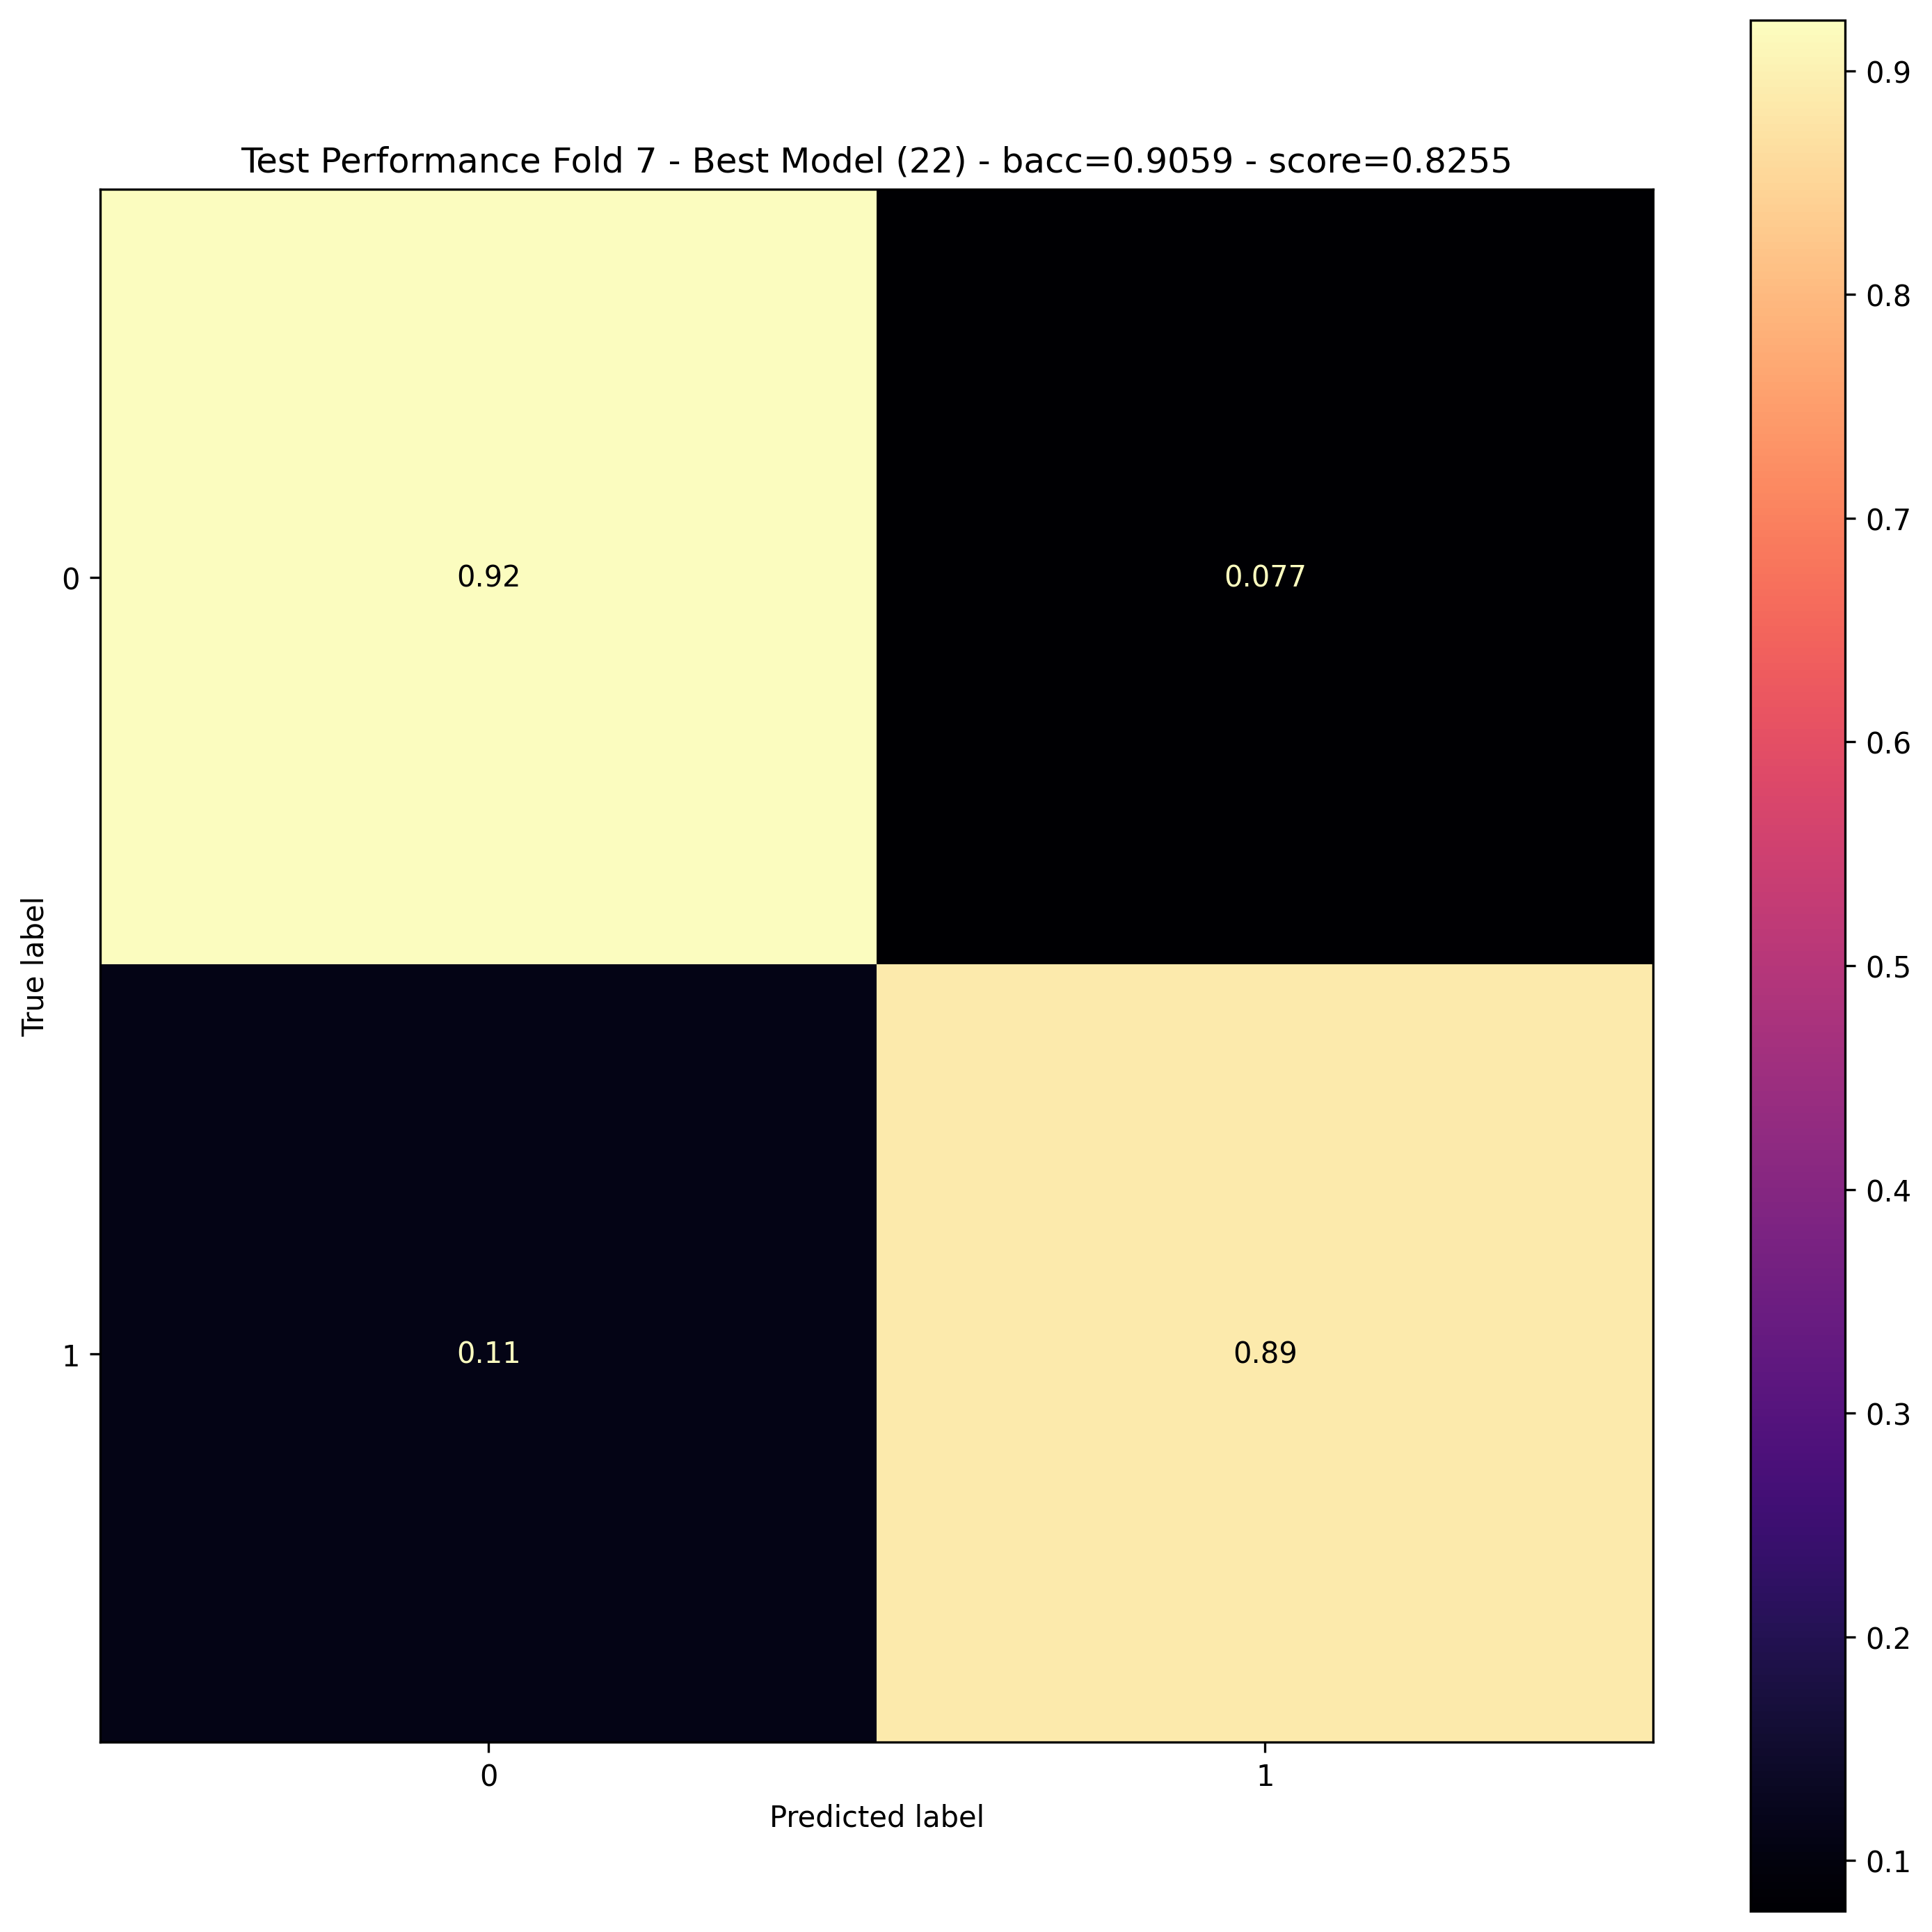

CV Folds: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:32<00:00, 11.51s/it]

Best Model Test Metrics: epoch =    -1, avg_loss = 0.000040, num_samples = 12000, num_correct = 10953, acc = 0.912750, bacc = 0.905894, score = 0.825500
Saved model with scaler as "bird_no_bird_classifier cv2023-06-15_14.38 fold-7-best eval-score=0.8459 test-score=0.8255"


#################
#### Metrics ####
#################


cv_average_best_best_models_eval_metrics = epoch = 22.375000, avg_loss = 0.000032, num_samples = 13500.000000, num_correct = 12431.750000, acc = 0.920870, bacc = 0.923552, score = 0.841741 


cv_average_best_best_models_test_metrics = epoch = -1.000000, avg_loss = 0.000041, num_samples = 12000.000000, num_correct = 10946.500000, acc = 0.912208, bacc = 0.903073, score = 0.824417 




In [36]:
set_random_seed(420)

cv_models_with_scalers, cv_folds_metrics, best_models_metrics = train_model_with_cv(
    lambda: AttentionClassifier(ac_hyper_parameters, batch_first=True),
    training_hyper_parameters, 
    sequences_ds_train_binary_labels,
    sequences_ds_test_binary_labels,
    n_folds=8,
    device=device,
    save_models='best',
    model_saving_name='bird_no_bird_classifier',
)


## Metrics ##
print(
'''

#################
#### Metrics ####
#################

'''
)

cv_average_best_best_models_eval_metrics = calculate_average_metrics([m[1] for m in best_models_metrics])
print(f'{cv_average_best_best_models_eval_metrics = } \n\n')

if best_models_metrics[0][2] is not None:
    cv_average_best_best_models_test_metrics = calculate_average_metrics([m[2] for m in best_models_metrics])
    print(f'{cv_average_best_best_models_test_metrics = } \n\n')

cv_avg_epoch_train_metrics = calculate_average_metrics_per_epoch(cv_folds_metrics)

rows = []
for fold_nr, fold_metrics in enumerate(cv_folds_metrics):
    for epoch_nr, (train_metrics, eval_metrics) in enumerate(fold_metrics):
        rows.append({
            'cv_fold': fold_nr,
            'epoch': epoch_nr,
            'type': 'CV Train BACC',
            'bacc': train_metrics.bacc,
        })
        if eval_metrics is not None:
            rows.append({
                'cv_fold': fold_nr,
                'epoch': epoch_nr,
                'type': 'CV Eval BACC',
                'bacc': eval_metrics.bacc,
            })

cv_metrics_df = pd.DataFrame(rows)

# Plots

In [ ]:
def create_lrs_over_epochs(training_hyper_parameters: TrainingHyperParameters) -> list[float]:
    lrs: list[float] = []
    
    lr = training_hyper_parameters.lr
    for epoch_nr in range(training_hyper_parameters.num_epochs):
        if epoch_nr in training_hyper_parameters.lr_scheduler_milestones:
            lr *= training_hyper_parameters.lr_scheduler_gamma
        lrs.append(lr)
    return lrs
    

def plot_baccs_over_epochs(title: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
    
    cv_epoch_range = np.arange(0, training_hyper_parameters.num_epochs)
    
    sns.lineplot(data=cv_metrics_df, x='epoch', y='bacc', hue='type', ax=ax, palette=['blue', 'green'])
    
    twin_ax = ax.twinx()
    lr_plots_kwargs = {
        'ls': '--',
        'lw': 0.75
    }
    twin_ax.plot(cv_epoch_range, create_lrs_over_epochs(training_hyper_parameters), label='CV LR', c='lightblue', **lr_plots_kwargs)

    ax.set(
        title=title,
        xlabel='Epoch',
        ylabel='BACC',
        yticks=[x * 0.1 for x in range(11)]
    )

    ax.grid(ls=':')
    ax.legend(loc='center right')
    twin_ax.legend(loc='lower right')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
        twin_ax.spines[spine].set_visible(False)

    plt.show()

average_last_epoch_eval_bacc = cv_metrics_df.query('type == "CV Eval BACC"').groupby('epoch').mean().iloc[-1]['bacc']
plot_baccs_over_epochs(f'Attention Classifier, last epoch eval bacc = {average_last_epoch_eval_bacc:6f}')